In [4]:
import torch
from torchgeo.samplers import GeoSampler
from torchgeo.datasets.utils import BoundingBox
from typing import Iterator, Union
from shapely.geometry import Point
from pyproj import Transformer

import geopandas as gpd
from torchgeo.datasets import RasterDataset
from typing import Any, ClassVar, cast
from torch import Tensor
import re
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import pandas as pd

%load_ext autoreload
%autoreload 2

In [5]:
import geopandas as gpd
from shapely.geometry import Point, box
from typing import NamedTuple, Iterator, List, Union
from pyproj import Transformer
from shapely.geometry import box

def get_utm_crs(lon):
    """Dynamically determines the appropriate UTM CRS for a given longitude."""
    utm_zone = int((lon + 180) / 6) + 1
    utm_crs = f"EPSG:326{utm_zone}" if lon >= 0 else f"EPSG:327{utm_zone}"
    return utm_crs

def expand_cell_to_square(points: List[Point], side_length: float, from_crs: str, to_crs: str) -> List[gpd.GeoSeries]:
    """
    Creates square polygons around a list of points in a metric CRS, reprojected to target CRS.
    """
    if points.empty:
        return []

    gdf = gpd.GeoDataFrame(geometry=points, crs=from_crs)
    half_side = side_length / 2

    # Find a metric CRS for buffering - use first point longitude to pick UTM zone
    gdf_wgs84 = gdf.to_crs("EPSG:4326")
    first_lon = gdf_wgs84.geometry.iloc[0].x
    metric_crs = get_utm_crs(first_lon)

    # Reproject to metric CRS for buffering
    gdf_metric = gdf.to_crs(metric_crs)

    # Create square polygons by buffering with cap_style=3 (square)
    gdf_squares = gdf_metric.buffer(half_side, cap_style=3, join_style=2)

    # Reproject squares back to target CRS (usually raster CRS)
    final_gdf = gpd.GeoDataFrame(geometry=gdf_squares, crs=metric_crs).to_crs(to_crs)

    return final_gdf.geometry.tolist()


In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd

def remove_out_of_bounds(df, raster_path_filter='../data/data_layers/predictors_100_QC/alluvion.tif'):
    """
    Remove rows from the DataFrame where the geometry is out of bounds of the raster.
    Prints the number of cells removed.
    """
    with rasterio.open(raster_path_filter) as src:
        raster_bounds_poly = box(*src.bounds)

    mask = gpd.GeoSeries(df['expanded_cells']).within(raster_bounds_poly)
    removed_count = (~mask).sum()
    print(f"Number of cells removed: {removed_count}")

    df = df[mask]
    return df.reset_index(drop=True)

def filter_with_qc_bounds(processed_species):
    gdf = gpd.read_file('../data/boundaries/lpr_000b16a_e/lpr_000b16a_e.shp')
    quebec_gdf = gdf[gdf['PRENAME'] == 'Quebec']

    # apply crs to the geodataframe
    quebec_gdf = quebec_gdf.to_crs(epsg=6624)
    # Ensure expanded_cells_gdf is a GeoDataFrame and set CRS to match quebec_gdf
    processed_species = processed_species.copy()
    processed_species.to_crs(epsg=6624, inplace=True)
    expanded_cells_gdf = gpd.GeoDataFrame(geometry=processed_species['expanded_cells'], crs=quebec_gdf.crs)
    expanded_cells_gdf['geometry'] = processed_species['geometry'].values
    # Ensure Quebec boundary is simplified (optional but helpful)
    quebec_gdf = quebec_gdf.explode(index_parts=False).reset_index(drop=True)

    # Spatial join using 'within' or 'intersects' (use 'intersects' if you want looser filtering)
    filtered_cells = gpd.sjoin(expanded_cells_gdf, quebec_gdf, predicate="within", how="inner")

    print(f"Number of cells removed: {len(processed_species) - len(filtered_cells)}")
    # Drop join column if not needed
    filtered_cells = filtered_cells.drop(columns=["index_right"])

    #only keep the rows in processed_species_ok that are in filtered_cells
    processed_species_ok = processed_species[processed_species['geometry'].isin(filtered_cells['geometry'])].reset_index(drop=True)

    print(f"bounding box of quebec: {quebec_gdf.total_bounds}")
    print(f"bounding box of expanded cells: {expanded_cells_gdf.total_bounds}")
    # # Plot both on the same matplotlib axis
    # fig, ax = plt.subplots(figsize=(10, 10))

    # # Plot the Quebec boundary
    # quebec_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

    # # Plot the expanded cells
    # expanded_cells_gdf.plot(ax=ax, color='blue', alpha=0.4)

    # plt.title("Expanded Cells over Quebec")
    # # Remove plt.axis("off") to avoid ValueError: aspect must be finite and positive
    # plt.show()

    return processed_species_ok

def generate_expanded_cells(processed_species, raster_filter=True, qc_bounds_filter=True):
    # Expand H3 cells to square cells
    expanded_cells = expand_cell_to_square(
        points=processed_species.geometry,
        side_length=10000,
        from_crs=processed_species.crs,
        to_crs='EPSG:6624'
    )
    if 'expanded_cells' in processed_species.columns:
        processed_species = processed_species.drop(columns=['expanded_cells'])
    #merge expanded_cells into processed_species DataFrame as a new column
    processed_species['expanded_cells'] = expanded_cells
    if raster_filter:
        # Filter out cells that are not within the raster bounds
        processed_species = remove_out_of_bounds(processed_species)
        print(f"Number of cells after raster filtering: {len(processed_species)}")
    if qc_bounds_filter:
        # Filter out cells that are not within the Quebec boundaries
        processed_species = filter_with_qc_bounds(processed_species)
        print(f"Number of cells after QC bounds filtering: {len(processed_species)}")
    return processed_species.reset_index(drop=True)




In [7]:
from shapely.wkt import loads as wkt_loads
processed_species_original_locations = gpd.read_file("../data/saved_df/processed_species_original_locations.csv")
processed_species_original_locations['geometry'] = processed_species_original_locations['geometry'].apply(wkt_loads)
processed_species_original_locations = gpd.GeoDataFrame(processed_species_original_locations, geometry='geometry', crs="EPSG:4326")
# processed_species_original_locations['expanded_cells'] = expanded_cells
# processed_species_original_locations.to_crs('EPSG:6624', inplace=True)
processed_species_original_locations = generate_expanded_cells(processed_species_original_locations)

Number of cells removed: 227
Number of cells after raster filtering: 24733
Number of cells removed: 1
bounding box of quebec: [-831089.93304842  117211.3806612   783876.54176348 2103332.26373041]
bounding box of expanded cells: [-741826.67349082  123269.62752555  270670.53068825  942213.72686294]
Number of cells after QC bounds filtering: 24732


In [8]:
import torch
from torchgeo.samplers import GeoSampler
from torchgeo.datasets.utils import BoundingBox
from typing import Iterator
import geopandas as gpd
from pyproj import CRS
import numpy as np

class PointGeoSampler(GeoSampler):
    def __init__(self, dataset, locations: gpd.GeoSeries, side_length_meters: float):
        """
        dataset: raster dataset with .crs attribute
        locations: GeoSeries with points
        side_length_meters: patch side length in meters
        """
        self.dataset = dataset
        self.dataset_crs = dataset.crs
        self.side_length_meters = side_length_meters
        self.locations = locations

        # Reproject points to raster CRS if needed
        if locations.crs != self.dataset_crs:
            self.points_in_dataset_crs = locations.to_crs(self.dataset_crs)
        else:
            self.points_in_dataset_crs = locations

        # Pre-compute all bounding boxes
        self._precompute_bboxes()
        
        # Time bounds
        if hasattr(dataset.bounds, 'mint'):
            self.mint = dataset.bounds.mint
            self.maxt = dataset.bounds.maxt
        else:
            self.mint = 0
            self.maxt = 0

    def _precompute_bboxes(self):
        """Pre-compute all bounding boxes for maximum speed"""
        points = self.points_in_dataset_crs.geometry
        half_side = self.side_length_meters / 2
        
        if self.dataset_crs.is_geographic:
            # Extract coordinates as arrays
            lons = np.array([p.x for p in points])
            lats = np.array([p.y for p in points])
            
            # Vectorized degree conversion
            meters_per_degree_lat = 111_320
            deg_lats = half_side / meters_per_degree_lat
            
            cos_lats = np.cos(np.radians(lats))
            deg_lons = half_side / (meters_per_degree_lat * cos_lats)
            
            # Compute all bounding boxes at once
            minxs = lons - deg_lons
            maxxs = lons + deg_lons
            minys = lats - deg_lats
            maxys = lats + deg_lats
            
        else:
            # Projected CRS
            xs = np.array([p.x for p in points])
            ys = np.array([p.y for p in points])
            
            minxs = xs - half_side
            maxxs = xs + half_side
            minys = ys - half_side
            maxys = ys + half_side
        
        # Store pre-computed bounding boxes
        self.bboxes = list(zip(minxs, maxxs, minys, maxys))

    def __iter__(self) -> Iterator[BoundingBox]:
        for minx, maxx, miny, maxy in self.bboxes:
            yield BoundingBox(minx, maxx, miny, maxy, self.mint, self.maxt)

    def get_all_queries(self):
        return list(self.__iter__())

    def __len__(self) -> int:
        return len(self.bboxes)

In [9]:
import os
from matplotlib.figure import Figure
import rasterio
import zarr
import time
import re
from typing import Any, Sequence, cast

from rasterio.windows import from_bounds
from rasterio.mask import mask
from shapely.geometry import mapping
from pyproj import CRS
from rasterio.features import rasterize

class IndependentBandsDataset(RasterDataset):
    filename_glob = "*.tif"          # Adjust this if needed
    #crs = "EPSG:6624"                # Your CRS
    resolution = (100, 100)                 # Your resolution, if you want to resample
    separate_files = False           # Set True if each band is a separate file
    is_image = True               # Set False if not image data
    filename_regex = r"^(?P<band>.+)\.tif$"  # Extract band name from filename (without extension)

    def __init__(self, paths: str, all_bands: list[str], transforms=None, separate_files=False, resolution=(100, 100)):
        
        super().__init__(paths, transforms=transforms)
        self.separate_files = separate_files
        self.all_bands = all_bands
        self.bands = all_bands
        self.resolution = resolution
        self.crs = "EPSG:6624"  # Set your CRS here
    

    def plot(self, sample: dict, bands: list[str], show_titles: bool = True, suptitle: str | None = None) -> Figure:
        """
        Plot each selected band in its own subplot (no RGB combinations).

        Args:
            sample: dictionary with 'image' key
            bands: list of band names to visualize
            show_titles: show subplot titles
            suptitle: optional figure title

        Returns:
            matplotlib Figure
        """
        # Find indices for requested bands
        band_indices = [self.all_bands.index(band) for band in bands if band in self.all_bands]
        if not band_indices:
            raise ValueError("None of the requested bands are in the dataset!")

        n = len(band_indices)
        max_per_row = 5
        nrows = (n + max_per_row - 1) // max_per_row
        ncols = min(n, max_per_row)

        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
        axs = np.array(axs).reshape(-1)  # flatten in case of single row/column

        for i, band_index in enumerate(band_indices):
            band_data = sample['image'][band_index].numpy()
            ax = axs[i]
            im = ax.imshow(band_data, cmap='viridis')
            ax.axis('off')
            if show_titles:
                ax.set_title(f"Band: {self.all_bands[band_index]}")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Hide unused axes
        for j in range(len(band_indices), len(axs)):
            axs[j].axis('off')

        if suptitle is not None:
            plt.suptitle(suptitle)

        plt.tight_layout()
        return fig


In [10]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from typing import List
import torch.nn.functional as F


class CombinedBandsDataset(RasterDataset):
    def __init__(self, paths: str, all_bands: List[str], transforms=None, resolution: int = 30, separate_files: bool = False, target_size: int | None = None):
        """
        Args:
            root: path to folder containing .tif files (each file is one tile)
            band_names: list of band names, order corresponds to band order in each file
            transforms: optional transforms to apply
            crs: CRS of your dataset
        """
        super().__init__(paths, transforms=transforms)
        self.separate_files = separate_files
        self.all_bands = all_bands
        self.bands = all_bands
        self.resolution = resolution
        self.target_size = target_size  # Optional resizing target size

    def __getitem__(self, query: Union[BoundingBox, int]) -> dict[str, Any]:
        """Retrieve image/mask and metadata indexed by query with optional resizing.

        Args:
            query: BoundingBox coordinates to index, or integer index if sampler is available

        Returns:
            sample of image/mask and metadata at that index

        Raises:
            IndexError: if query is not found in the index
            ValueError: if integer indexing is used without a sampler
        """
        # Handle integer indices (convert to BoundingBox query)
        if isinstance(query, int):
            if not hasattr(self, 'sampler') or self.sampler is None:
                raise ValueError("Integer indexing requires a sampler to be set")
            if not hasattr(self, 'queries'):
                self.queries = self.sampler.get_all_queries()
            bbox_query = self.queries[query]
        else:
            # Direct BoundingBox query
            bbox_query = query

        # Original RasterDataset logic starts here
        hits = self.index.intersection(tuple(bbox_query), objects=True)
        filepaths = [hit.object for hit in hits]  # Removed cast for simplicity

        if not filepaths:
            raise IndexError(
                f'query: {bbox_query} not found in index with bounds: {self.bounds}'
            )

        if self.separate_files:
            data_list = []
            filename_regex = re.compile(self.filename_regex, re.VERBOSE)
            for band in self.bands:
                band_filepaths = []
                for filepath in filepaths:
                    filename = os.path.basename(filepath)
                    directory = os.path.dirname(filepath)
                    match = re.match(filename_regex, filename)
                    if match:
                        if 'band' in match.groupdict():
                            start = match.start('band')
                            end = match.end('band')
                            filename = filename[:start] + band + filename[end:]
                    filepath = os.path.join(directory, filename)
                    band_filepaths.append(filepath)

                data_list.append(self._merge_files(band_filepaths, bbox_query))
            data = torch.cat(data_list)
        else:
            data = self._merge_files(filepaths, bbox_query, self.band_indexes)

        sample = {'crs': self.crs, 'bounds': bbox_query}

        data = data.to(self.dtype)
        
        # NEW: Apply bilinear resizing if target_size is set and this is an image
        if (hasattr(self, 'target_size') and 
            self.target_size is not None and 
            self.is_image and 
            len(data.shape) == 3):  # [C, H, W]
            
            data = F.interpolate(
                data.unsqueeze(0),  # Add batch dimension: [1, C, H, W]
                size=(self.target_size, self.target_size),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)  # Remove batch dimension: [C, H, W]
        
        if self.is_image:
            sample['image'] = data
        else:
            sample['mask'] = data.squeeze(0)

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def plot(self, sample: dict, bands: List[str], show_titles: bool = True, suptitle: str | None = None) -> Figure:
        """
        Plot RGB composite (first 3 bands) and each selected band in its own subplot.
        """
        # Always use first 3 bands for RGB
        rgb_indices = [0, 1, 2]
        rgb_bands = [self.all_bands[i] for i in rgb_indices]
        band_indices = [self.all_bands.index(b) for b in bands if b in self.all_bands]

        n = 1 + len(band_indices)  # 1 for RGB, rest for individual bands
        max_per_row = 5
        nrows = (n + max_per_row - 1) // max_per_row
        ncols = min(n, max_per_row)

        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
        axs = np.array(axs).reshape(-1)

        # Plot RGB composite with 98th percentile normalization
        rgb = sample["image"][rgb_indices].detach().cpu().numpy()
        rgb_img = np.transpose(rgb, (1, 2, 0)) if rgb.shape[0] == 3 else rgb

        # Normalize each channel by its 98th percentile
        rgb_norm = np.zeros_like(rgb_img)
        for i in range(3):
            band = rgb_img[..., i]
            p98 = np.nanpercentile(band, 98)
            rgb_norm[..., i] = np.clip(band / p98, 0, 1) if p98 > 0 else band

        axs[0].imshow(rgb_norm)
        axs[0].axis("off")
        if show_titles:
            axs[0].set_title(f"RGB: {', '.join(rgb_bands)} (98th pct norm)")

        # Plot each selected band
        if(len(band_indices) > 3):
            for i, band_index in enumerate(band_indices[3:]):
                band_data = sample["image"][band_index].detach().cpu().numpy()
                ax = axs[i + 1]
                im = ax.imshow(band_data, cmap="viridis")
                ax.axis("off")
            if show_titles:
                ax.set_title(f"Band: {self.bands[band_index]}")
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        for j in range(n, len(axs)):
            axs[j].axis("off")

        if suptitle:
            plt.suptitle(suptitle)

        plt.tight_layout()
        return fig

In [11]:
def fetch_raster_files_from_directories(directories, include_files=None):
    """
    Fetch raster files from specified directories.
    
    Parameters:
    - directories: List of directories to search for raster files.
    - include_files: Optional list of file names to include.
    
    Returns:
    - List of file paths for raster files.
    """
    raster_files = []
    for directory in directories:
        for root, _, files in os.walk(directory):
            for file in files:
                if include_files is not None:
                    if file.endswith('.tif') and any(include in file for include in include_files):
                        raster_files.append(os.path.join(root, file))
                else:
                    if file.endswith('.tif'):
                        raster_files.append(os.path.join(root, file))
    return raster_files

def get_raster_as_bands(directory):
    #only keep the file name without the directory
    pred100_raster_files = fetch_raster_files_from_directories([directory])
    pred100_raster_names = [os.path.basename(f) for f in pred100_raster_files]
    #remove file extension from paths
    pred100_raster_names = [os.path.splitext(f)[0] for f in pred100_raster_names]   
    pred100_raster_names.sort()
    #transform into a tuple
    pred100_raster_names = tuple(pred100_raster_names)
    print(f"Pred100 raster names: {pred100_raster_names}")
    return pred100_raster_names

In [33]:
from torchgeo.samplers import RandomGeoSampler
pred100_raster_names = get_raster_as_bands("../data/data_layers/predictors_100_QC_normalized")
# Your raster dataset instance
pred_100_dataset = MyCustomRasterDataset("../data/data_layers/predictors_100_QC_normalized", 
                                         all_bands=pred100_raster_names, 
                                         separate_files=True,
                                         #resolution=(100, 100),
                                        )
        
# Your locations as GeoSeries or list of shapely.Point
locations = processed_species_original_locations.geometry

sampler = PointGeoSampler(
    dataset=pred_100_dataset,
    locations=locations,
    side_length_meters=10000,
)

queries = sampler.get_all_queries()
#print("Queries crs:", queries.crs)  # This won't have CRS but ensure from GeoSeries with CRS

Pred100 raster names: ('alluvion', 'annual_precipitation_amount', 'annual_range_of_air_temperature', 'barren', 'bulk_density', 'clay', 'combined_mask', 'coniferous', 'cropland', 'deciduous', 'depot', 'distance_to_roads', 'eau_peu_profonde', 'elevation', 'eolien', 'geomflat', 'geomfootslope', 'glaciaire', 'glaciolacustre', 'human_modification', 'indifferencie', 'isothermality', 'lacustre', 'lai', 'marais', 'marecage', 'mean_annual_air_temperature', 'mean_daily_maximum_air_temperature_of_the_warmest_month', 'mean_daily_mean_air_temperatures_of_the_coldest_quarter', 'mean_daily_mean_air_temperatures_of_the_driest_quarter', 'mean_daily_mean_air_temperatures_of_the_warmest_quarter', 'mean_daily_mean_air_temperatures_of_the_wettest_quarter', 'mean_daily_minimum_air_temperature_of_the_coldest_month', 'mean_diurnal_air_temperature_range', 'mean_monthly_precipitation_amount_of_the_coldest_quarter', 'mean_monthly_precipitation_amount_of_the_driest_quarter', 'mean_monthly_precipitation_amount_of_

In [20]:
queries

[BoundingBox(minx=-747490.7174673307, maxx=-737490.7174673307, miny=335539.81817674654, maxy=345539.81817674654, mint=0.0, maxt=9.223372036854776e+18),
 BoundingBox(minx=-747558.8037014916, maxx=-737558.8037014916, miny=335464.1430090031, maxy=345464.1430090031, mint=0.0, maxt=9.223372036854776e+18),
 BoundingBox(minx=-751879.8713852481, maxx=-741879.8713852481, miny=327609.55493716506, maxy=337609.55493716506, mint=0.0, maxt=9.223372036854776e+18),
 BoundingBox(minx=-750847.2281272755, maxx=-740847.2281272755, miny=326890.70654599386, maxy=336890.70654599386, mint=0.0, maxt=9.223372036854776e+18),
 BoundingBox(minx=-750974.5832241996, maxx=-740974.5832241996, miny=326976.848301429, maxy=336976.848301429, mint=0.0, maxt=9.223372036854776e+18)]

In [21]:
list(pred100_raster_names[:5])

['alluvion',
 'annual_precipitation_amount',
 'annual_range_of_air_temperature',
 'barren',
 'bulk_density']

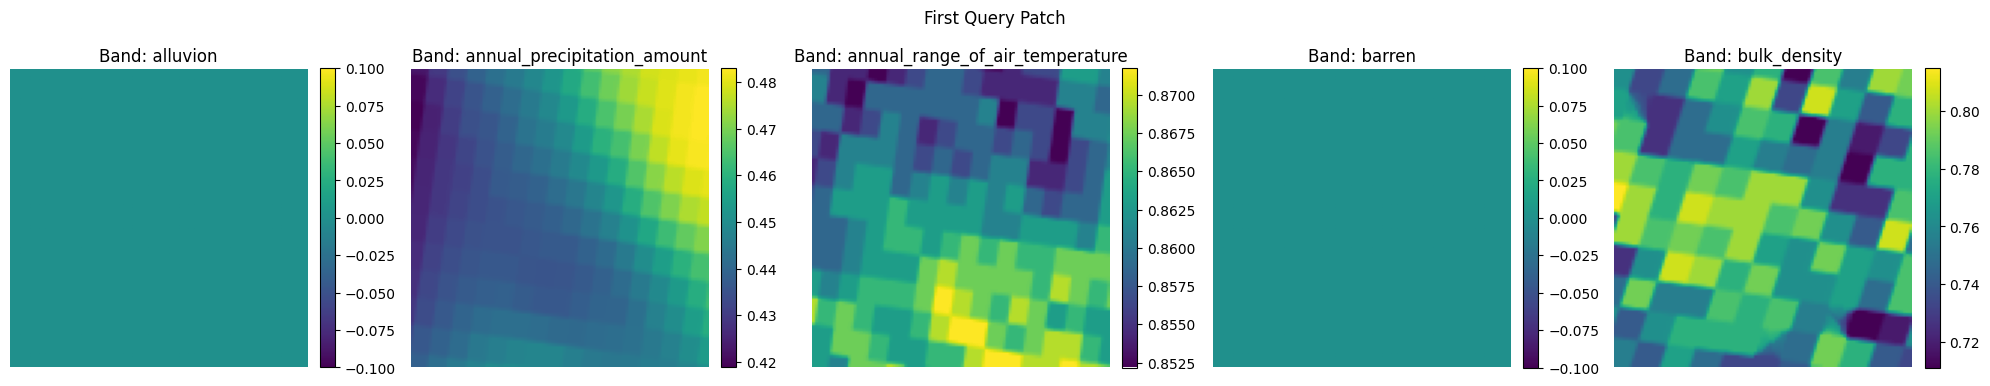

In [34]:
fig = pred_100_dataset.plot(
    sample=pred_100_dataset[queries[3]],
    bands=list(pred100_raster_names[:5]),  # plot first 5 bands as example
    show_titles=True,
    suptitle="First Query Patch"
)
plt.show()

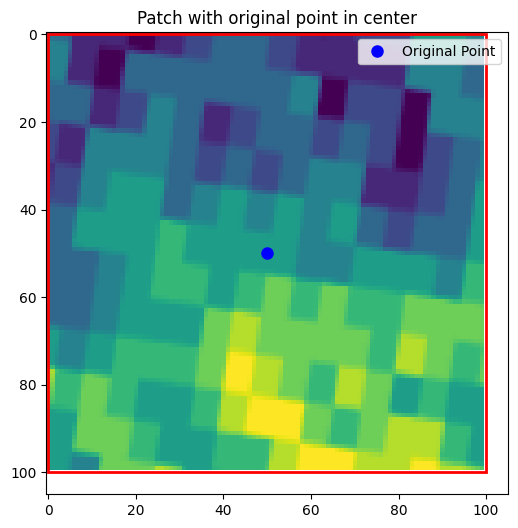

In [491]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Take the first patch
point_index = 3
query = queries[point_index]
patch_data = pred_100_dataset[query]['image']  # shape: [C, H, W]

# Pick a band to visualize (e.g., first band)
band_data = patch_data[2].numpy()  

# Plot the raster patch
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(band_data, cmap='viridis', origin='upper')

# Get patch bounds in raster CRS
xmin, xmax = query.minx, query.maxx
ymin, ymax = query.miny, query.maxy

# Draw rectangle around patch (in pixel coordinates)
rect = patches.Rectangle(
    (0, 0),  # top-left in array coordinates
    band_data.shape[1],  # width in pixels
    band_data.shape[0],  # height in pixels
    linewidth=2, edgecolor='red', facecolor='none'
)
ax.add_patch(rect)

# Plot original point in pixel coordinates relative to patch
# Convert map coordinates to pixels
point = sampler.points_in_dataset_crs.geometry.iloc[point_index]
# You need to know the pixel resolution (meters per pixel) for correct conversion.
# If patch_data.shape matches the patch size in meters, then:
pixel_size_x = (xmax - xmin) / band_data.shape[1]
pixel_size_y = (ymax - ymin) / band_data.shape[0]
x_center = (point.x - xmin) / pixel_size_x
y_center = (ymax - point.y) / pixel_size_y
ax.plot(x_center, y_center, 'bo', markersize=8, label='Original Point')

ax.set_title("Patch with original point in center")
ax.legend()
plt.show()


In [498]:
queries[0]

BoundingBox(minx=-746157.2280517358, maxx=-736157.2280517358, miny=317206.01150085626, maxy=327206.01150085626, mint=0.0, maxt=9.223372036854776e+18)

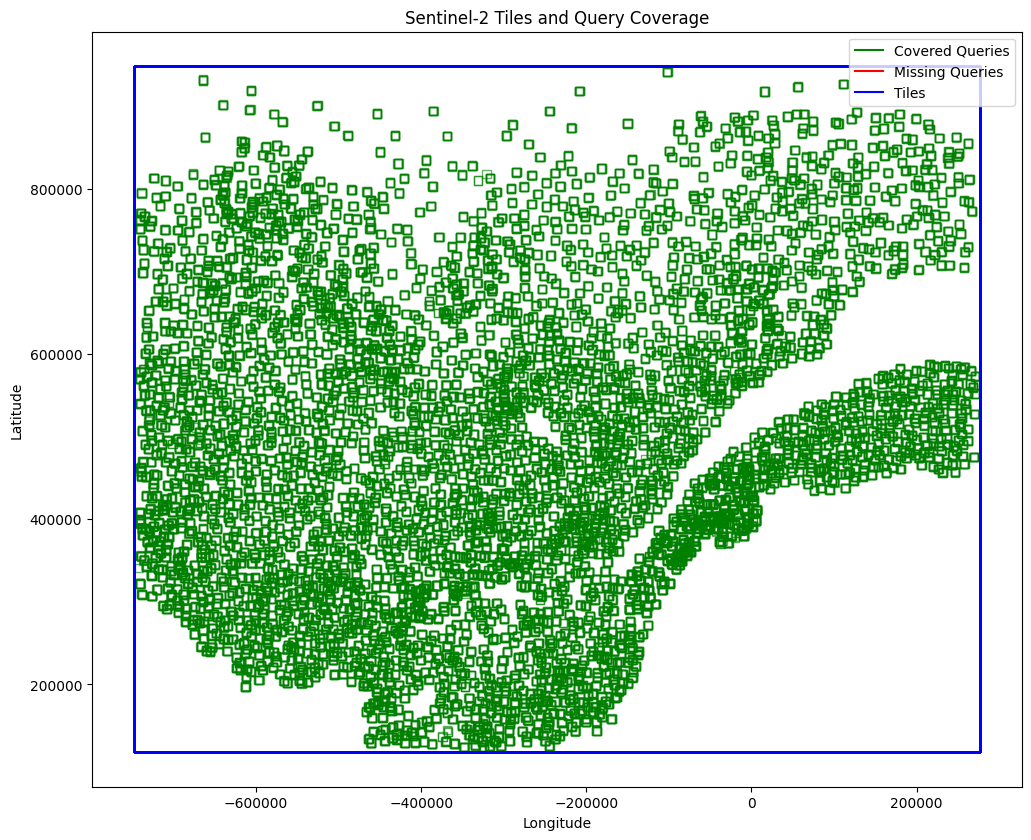

In [69]:
import pandas as pd
import rasterio
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchgeo.datasets import Sentinel2
from pyproj import Transformer

dataset = pred_100_dataset
processed_species_original_locations.to_crs(dataset.crs, inplace=True)  # Ensure locations are in dataset CRS   
point_sampler = PointGeoSampler(
    dataset=dataset,
    locations=processed_species_original_locations.geometry,
    side_length_meters=10000
)
dataset_queries = point_sampler.get_all_queries()


# Convert raster bounds to GeoDataFrame in their CRS, and reproject to common CRS before concatenation
tile_gdfs = []
for fpath in dataset.files:
    with rasterio.open(fpath) as src:
        tile_box = box(*src.bounds)
        gdf_tile = gpd.GeoDataFrame(geometry=[tile_box], crs=src.crs)
        gdf_tile = gdf_tile.to_crs(dataset.crs)  # Reproject to dataset CRS
        tile_gdfs.append(gdf_tile)

# Concatenate all tiles (now all in dataset CRS)
tiles_gdf = gpd.GeoDataFrame(pd.concat(tile_gdfs, ignore_index=True), crs=dataset.crs)

# Function to plot queries and tiles
def plot_query_and_tile_bboxes(covered_queries, missing_queries, tiles_gdf):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    def add_bboxes(queries, color, label, fill=False):
        for q in queries:
            width = q.maxx - q.minx
            height = q.maxy - q.miny
            ax.add_patch(Rectangle(
                (q.minx, q.miny), width, height,
                fill=fill, edgecolor=color, linewidth=1, alpha=0.6
            ))
        ax.plot([], [], color=color, label=label)
    
    add_bboxes(covered_queries, "green", "Covered Queries")
    add_bboxes(missing_queries, "red", "Missing Queries")
    
    #Plot tile bounding boxes
    for geom in tiles_gdf.geometry:
        minx, miny, maxx, maxy = geom.bounds
        ax.add_patch(Rectangle(
            (minx, miny), maxx - minx, maxy - miny,
            fill=False, edgecolor="blue", linewidth=1, alpha=0.5
        ))
    ax.plot([], [], color="blue", label="Tiles")
    
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Sentinel-2 Tiles and Query Coverage")
    ax.legend()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

# Example usage
covered_queries = [q for q in dataset_queries if q not in missing_queries]
plot_query_and_tile_bboxes(covered_queries, missing_queries, tiles_gdf)


### Extracting to zarr

In [9]:
import zarr
import geopandas as gpd
from rasterio.windows import from_bounds
from torchgeo.datasets import RasterDataset
import numpy as np
import time
import numcodecs
import rasterio
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import psutil
import os

def extract_patches_sequentially(
    dataset: RasterDataset,
    locations: gpd.GeoSeries,
    zarr_path: str,
    side_length_meters: float,
    memory_threshold_mb: float = 4096,
    group_name: str = 'pred_100',
    channel_min: list = None,    # Per-band minimum values
    channel_max: list = None,    # Per-band maximum values
    n_workers: int = None,       # Number of worker processes (None = auto)
):
    """
    Extract patches from a RasterDataset, optionally normalize them, and store in a Zarr archive.
    Handles both separate files per band and multiple bands in the same file(s).

    Parameters
    ----------
    dataset : RasterDataset
        TorchGeo dataset containing raster files.
    locations : gpd.GeoSeries
        GeoSeries of point geometries where patches should be extracted.
    zarr_path : str
        Path to the Zarr archive to write to.
    side_length_meters : float
        Side length of each patch in meters.
    memory_threshold_mb : float, optional
        Maximum memory to use across ALL processes before flushing patches to disk.
    group_name : str, optional
        Name of the group in `raster_data/` where patches will be stored.
    channel_min, channel_max : list, optional
        Per-band min/max values for normalization. Must be the same length as number of bands.
    n_workers : int, optional
        Number of worker processes. If None, uses CPU count - 1.
    """
    
    # Open Zarr in append mode to keep existing data
    root = zarr.open(zarr_path, mode='a', zarr_version=2)
    raster_root_group = root.require_group('raster_data')
    current_data_group = raster_root_group.require_group(group_name)
    compressor = numcodecs.Blosc(cname='lz4', clevel=5, shuffle=numcodecs.Blosc.SHUFFLE)
    
    # Create sampler
    point_geo_sampler = PointGeoSampler(
        dataset=dataset,
        locations=locations,
        side_length_meters=side_length_meters,
    )
    queries = point_geo_sampler.get_all_queries()
    print(f"First query: {queries[0]}")
    
    # Generate patch IDs
    patch_ids = [
        f"{pt.x:.4f}_{pt.y:.4f}".replace('.', '_')
        for pt in locations.geometry
    ]

    # Determine data structure and get dimensions
    first_sample = dataset[queries[0]]
    first_patch = first_sample['image'].numpy()
    n_bands, patch_height, patch_width = first_patch.shape
    patch_dtype = np.float32
    
    print(f"Dataset info:")
    print(f"  - separate_files: {dataset.separate_files}")
    print(f"  - n_bands: {n_bands}")
    print(f"  - n_files: {len(dataset.files)}")
    print(f"  - patch_shape: ({n_bands}, {patch_height}, {patch_width})")

    # Pre-allocate Zarr arrays
    print("Pre-allocating Zarr arrays...")
    for patch_id in patch_ids:
        if patch_id not in current_data_group:
            current_data_group.create(
                name=patch_id,
                shape=(n_bands, patch_height, patch_width),
                dtype=patch_dtype,
                chunks=(1, patch_height, patch_width),
                compressor=compressor
            )
    
    # Process based on file structure
    if dataset.separate_files:
        # Original logic for separate files per band
        _process_separate_files(
            dataset, queries, patch_ids, current_data_group,
            memory_threshold_mb, channel_min, channel_max
        )
    else:
        _process_combined_files_seq(
            dataset, queries, patch_ids, current_data_group,
            memory_threshold_mb, channel_min, channel_max
        )

    print(f"Patches saved at {zarr_path}")

def _process_separate_files(dataset, queries, patch_ids, current_data_group,
                           memory_threshold_mb, channel_min, channel_max):
    """Process datasets where each band is in a separate file"""
    print("Processing separate files per band...")
    
    in_memory_patches_by_file = []
    current_memory_usage_mb = 0
    start_time = time.time()
    
    for file_index, filepath in enumerate(dataset.files):
        with rasterio.open(filepath) as src:
            print(f"Processing band {file_index + 1}/{len(dataset.files)}: {filepath}")

            patches_for_this_band = []
            for loc_index, query_bbox in enumerate(queries):
                try:
                    window = from_bounds(
                        query_bbox.minx, query_bbox.miny,
                        query_bbox.maxx, query_bbox.maxy,
                        src.transform
                    )
                    patch = src.read(window=window).squeeze().astype(np.float32)
                    
                    # Normalization (only if channel_min and channel_max are provided)
                    if channel_min is not None and channel_max is not None:
                        min_val = channel_min[file_index]
                        max_val = channel_max[file_index]
                        
                        if max_val > min_val:
                            patch = (patch - min_val) / (max_val - min_val)
                            patch = np.clip(patch, 0, 1)

                    patches_for_this_band.append(patch)
                    current_memory_usage_mb += (patch.size * patch.itemsize) / (1024**2)
                except rasterio.errors.RasterioIOError:
                    patches_for_this_band.append(None)
            
            in_memory_patches_by_file.append(patches_for_this_band)

            # Save when memory limit reached or last file processed
            if current_memory_usage_mb >= memory_threshold_mb or file_index == len(dataset.files) - 1:
                print("Saving batch...")
                save_start_time = time.time()
                for batch_file_index, patches_list in enumerate(in_memory_patches_by_file):
                    original_file_index = file_index - len(in_memory_patches_by_file) + 1 + batch_file_index
                    for loc_index, patch in enumerate(patches_list):
                        if patch is not None:
                            patch_id = patch_ids[loc_index]
                            current_data_group[patch_id][original_file_index, :, :] = patch
                print(f"Batch saved in {time.time() - save_start_time:.2f}s")
                
                in_memory_patches_by_file = []
                current_memory_usage_mb = 0

    print(f"Extraction complete in {time.time() - start_time:.2f}s")

    print(f"Extraction complete in {time.time() - start_time:.2f}s")

from multiprocessing import Process, Queue
import time

def _zarr_saver(save_queue, current_data_group):
    """
    Background process that receives batches of patches and saves them to Zarr.
    """
    while True:
        item = save_queue.get()
        if item is None:  # Poison pill = stop
            break
        batch_patches = item
        save_start = time.time()
        for patch_id, patch in batch_patches.items():
            current_data_group[patch_id][:, :, :] = patch
        print(f"Saved {len(batch_patches)} patches in {time.time() - save_start:.2f}s")


def _process_combined_files_seq(dataset, queries, patch_ids, current_data_group,
                                      memory_threshold_mb, channel_min, channel_max):
    """Sequential extractor with async saving in a separate process"""
    print("Processing combined bands sequentially with async saving...")

    start_time = time.time()

    first_sample = dataset[queries[0]]
    n_bands, patch_height, patch_width = first_sample['image'].shape
    patch_dtype = np.float32

    in_memory_patches = {}
    current_memory_usage_mb = 0

    # Start background saver
    save_queue = Queue(maxsize=1)  # ensures we never buffer >1 batch
    saver = Process(target=_zarr_saver, args=(save_queue, current_data_group))
    saver.start()

    with tqdm(total=len(queries), desc="Processing patches (seq+async)") as pbar:
        for i, query_bbox in enumerate(queries):
            patch_id = patch_ids[i]
            try:
                sample = dataset[query_bbox]
                patch = sample['image'].numpy().astype(patch_dtype)

                # Normalization
                if channel_min is not None and channel_max is not None:
                    for b in range(patch.shape[0]):
                        min_val, max_val = channel_min[b], channel_max[b]
                        if max_val > min_val:
                            patch[b] = np.clip((patch[b] - min_val) / (max_val - min_val), 0, 1)

                # Collect patch in memory
                in_memory_patches[patch_id] = patch
                current_memory_usage_mb += patch.nbytes / (1024 ** 2)

                # If threshold exceeded, push batch to saver
                if current_memory_usage_mb >= memory_threshold_mb:
                    print(f"Queueing batch (~{current_memory_usage_mb:.2f} MB) for saving...")
                    save_queue.put(in_memory_patches)  # blocks if saver is still writing
                    in_memory_patches = {}
                    current_memory_usage_mb = 0

            except Exception as e:
                print(f"Error processing patch {patch_id}: {e}")

            pbar.update(1)

    # Final flush
    if in_memory_patches:
        print(f"Queueing final batch (~{current_memory_usage_mb:.2f} MB) for saving...")
        save_queue.put(in_memory_patches)

    # Stop saver
    save_queue.put(None)
    saver.join()

    print(f"Extraction complete in {time.time() - start_time:.2f}s")


In [503]:
locations

0    POINT (-741157.228 322206.012)
1    POINT (-740968.538 322143.985)
2    POINT (-740825.054 322103.996)
3    POINT (-740548.834 322019.529)
4    POINT (-740734.244 322076.046)
Name: geometry, dtype: geometry

In [563]:
# Path to the output Zarr store
zarr_output_path = '../data/zarr_patches/pred100.zarr'
side_length_meters = 10000
locations = processed_species_original_locations.geometry

# Now, call the optimized function with your data
extract_patches_sequentially(
    dataset=pred_100_dataset,
    locations=locations,
    side_length_meters=side_length_meters,
    zarr_path=zarr_output_path
)

Pre-allocating Zarr arrays...
Processing file 1/67: ../data/data_layers/predictors_100_QC_normalized/alluvion.tif
Processing file 2/67: ../data/data_layers/predictors_100_QC_normalized/annual_precipitation_amount.tif
Processing file 3/67: ../data/data_layers/predictors_100_QC_normalized/annual_range_of_air_temperature.tif
Processing file 4/67: ../data/data_layers/predictors_100_QC_normalized/barren.tif
Processing file 5/67: ../data/data_layers/predictors_100_QC_normalized/bulk_density.tif
Memory threshold reached or last file processed. Saving batch...
Batch saved in 217.05s
Processing file 6/67: ../data/data_layers/predictors_100_QC_normalized/clay.tif
Processing file 7/67: ../data/data_layers/predictors_100_QC_normalized/combined_mask.tif
Processing file 8/67: ../data/data_layers/predictors_100_QC_normalized/coniferous.tif
Processing file 9/67: ../data/data_layers/predictors_100_QC_normalized/cropland.tif
Processing file 10/67: ../data/data_layers/predictors_100_QC_normalized/deciduo

In [56]:
# import zarr
# import matplotlib.pyplot as plt

# # Path to your Zarr group
# zarr_path = "../data/zarr_patches/pred100.zarr"

# # Open the zarr group
# zarr_group = zarr.open_group(zarr_path, mode='r')['raster_data']['pred_100']

# # List all stored patches keys (ids)
# patch_ids = list(zarr_group.array_keys())
# print("Available patch IDs:", patch_ids[:5])  # show first 5 keys

# # Load the first patch (replace with the id you want)
# first_patch_id = patch_ids[3]
# patch = zarr_group[first_patch_id][...]

# print("Patch shape:", patch.shape)  # should be (channels, H, W) or maybe (H, W, channels)

# # # If last dim is channels instead of first dim, transpose:
# # if patch.shape[-1] <= 10:  # heuristic: if last dim is small (bands)
# #     patch = patch.transpose(2, 0, 1)  # (H, W, C) -> (C, H, W)

def visualize_bands(patch, num_bands=5):
    num_bands = min(num_bands, patch.shape[0])
    max_per_row = 5
    nrows = (num_bands + max_per_row - 1) // max_per_row
    ncols = min(num_bands, max_per_row)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axs = np.array(axs).reshape(-1)
    for i in range(num_bands):
        band = patch[i]
        axs[i].imshow(band, cmap='viridis')
        axs[i].set_title(f'Band {i+1}')
        axs[i].axis('off')
    # Hide unused axes
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    plt.tight_layout()
    plt.show()

#visualize_bands(patch, num_bands=5)


-293174_0786_428530_5746


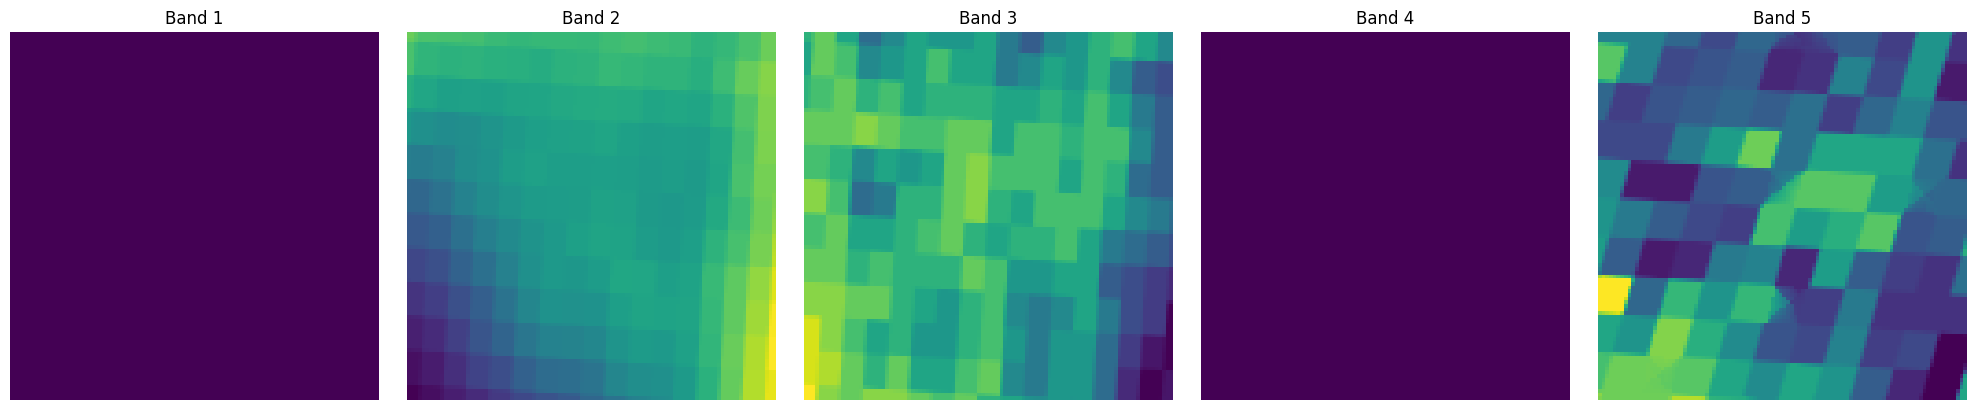

-331648_6281_136309_3800


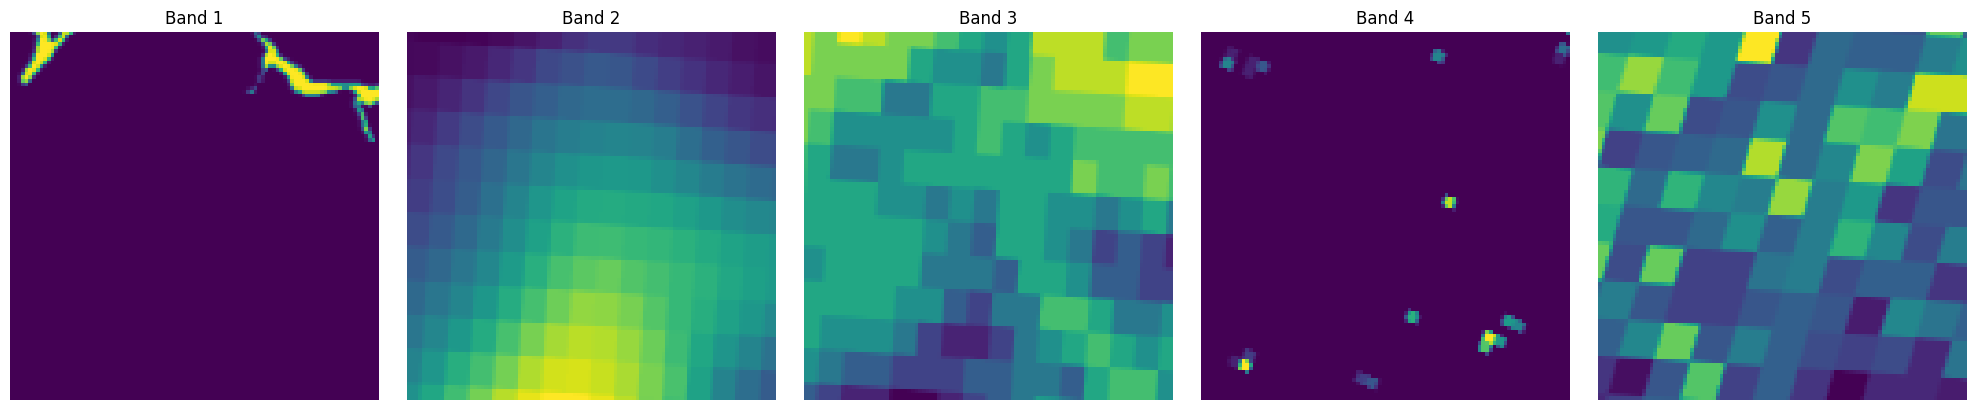

-131052_2708_490049_3918


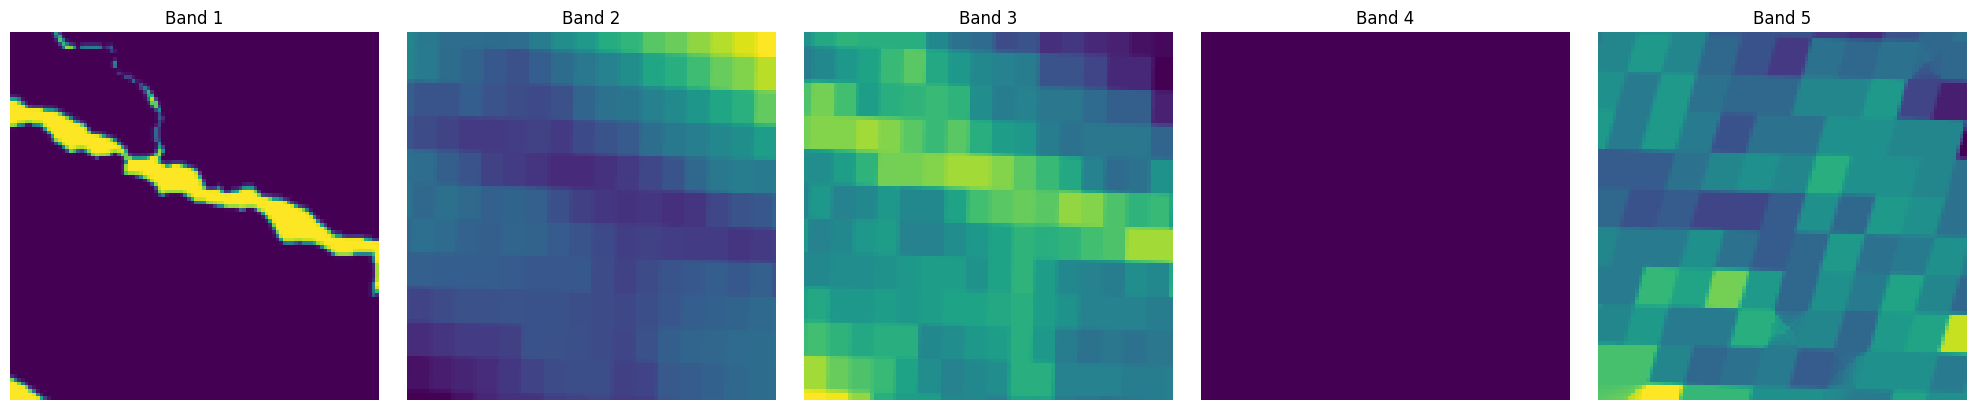

-386587_7695_563208_5866


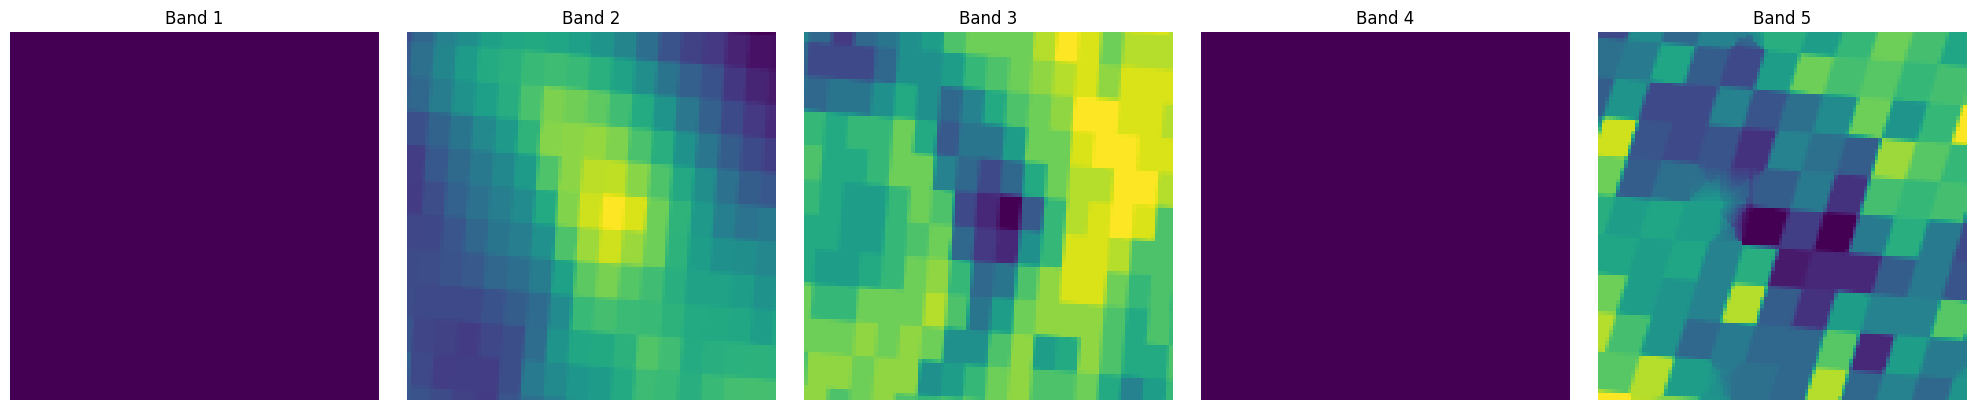

-542478_2951_350609_2562


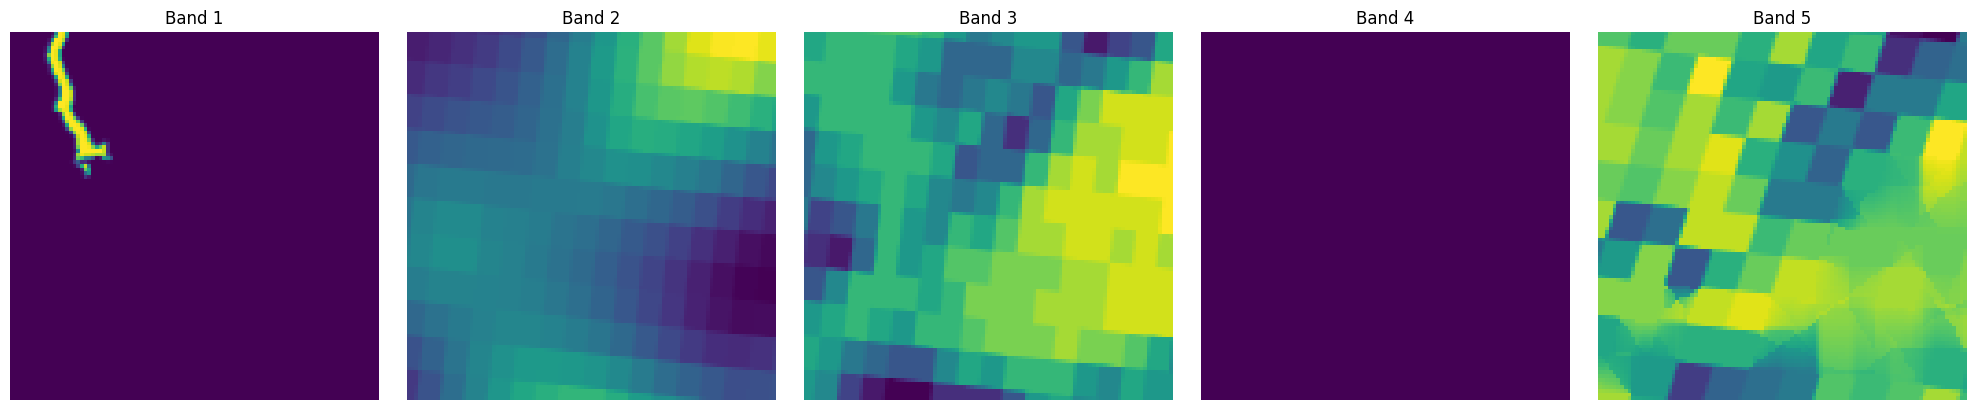

-157842_9873_514743_1391


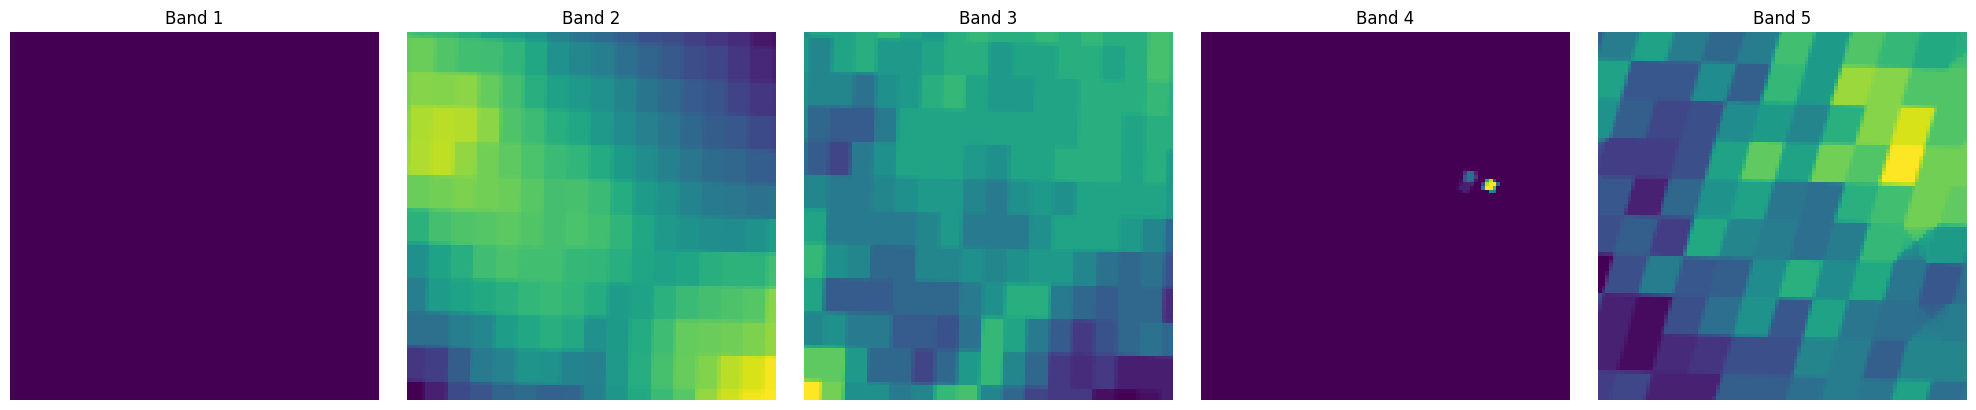

-127697_8246_695413_5510


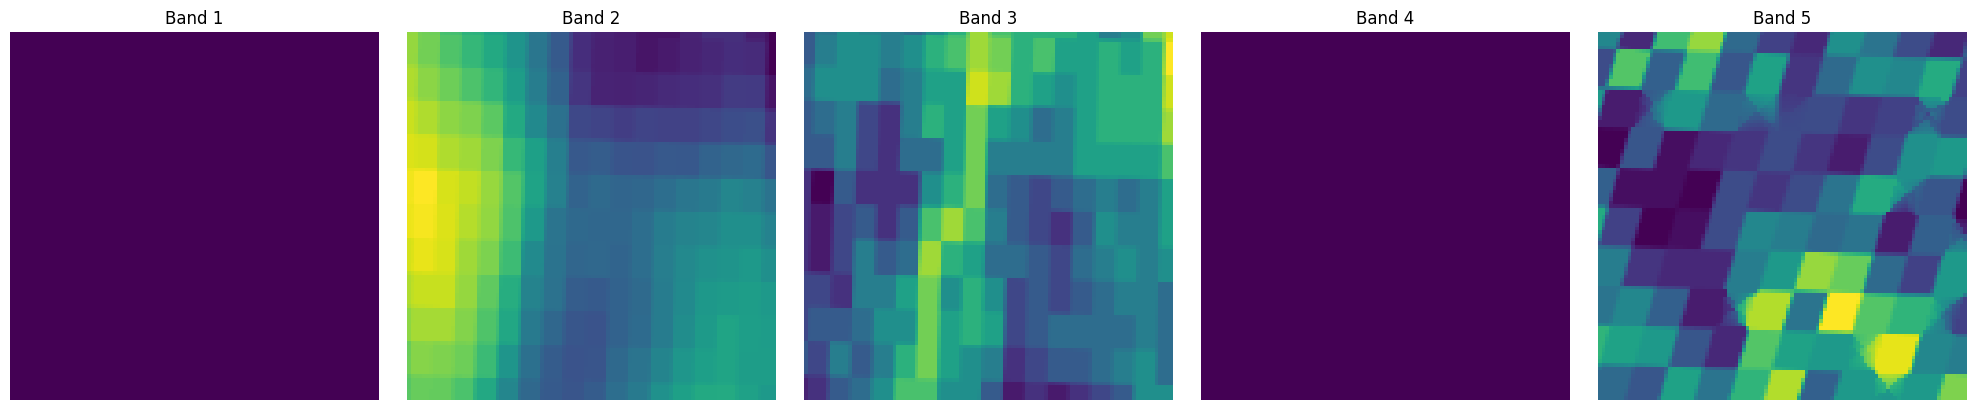

124493_9373_548993_8611


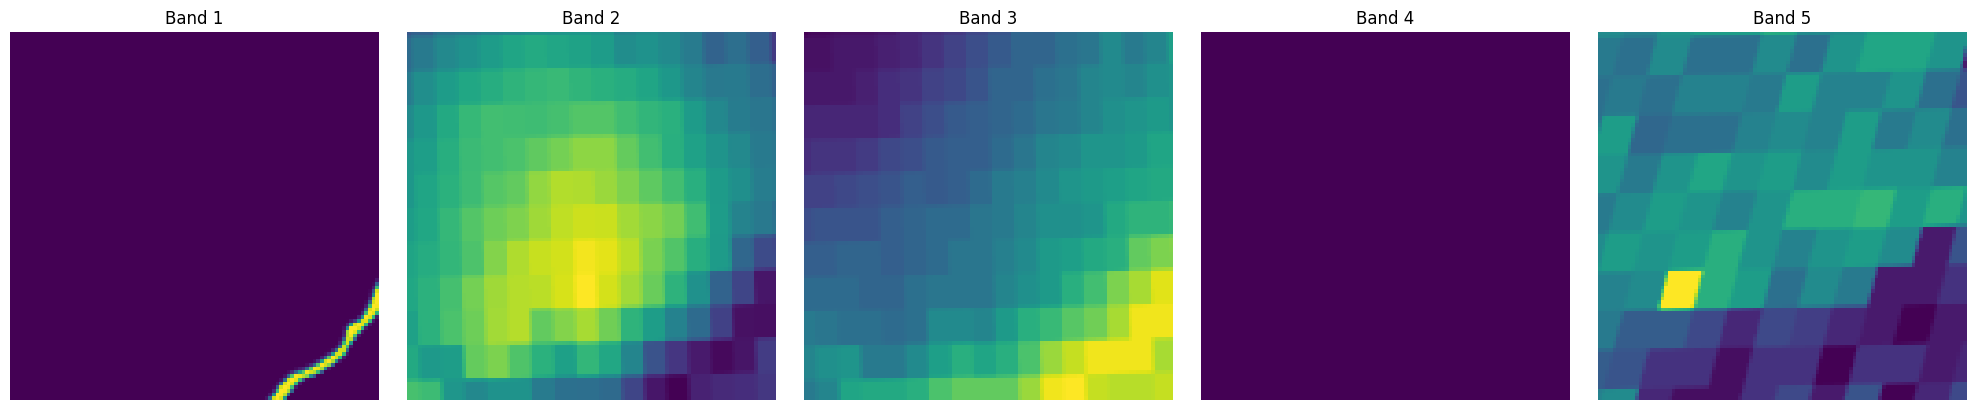

19268_2206_628381_1898


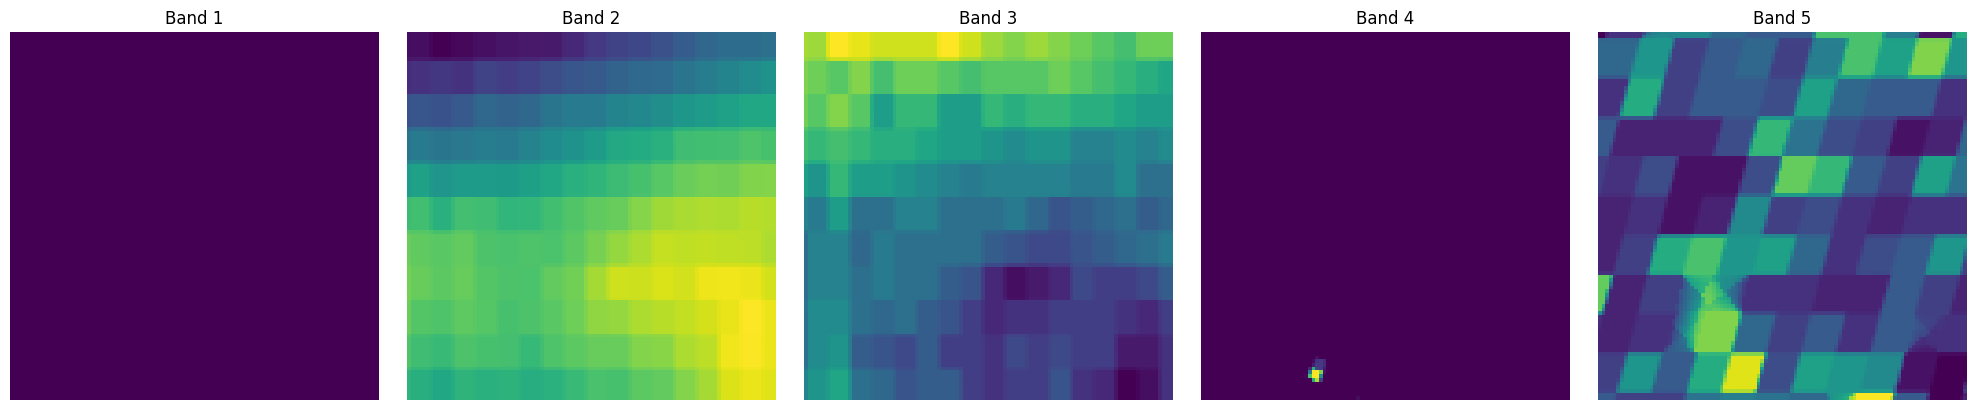

-359186_6970_128069_9272


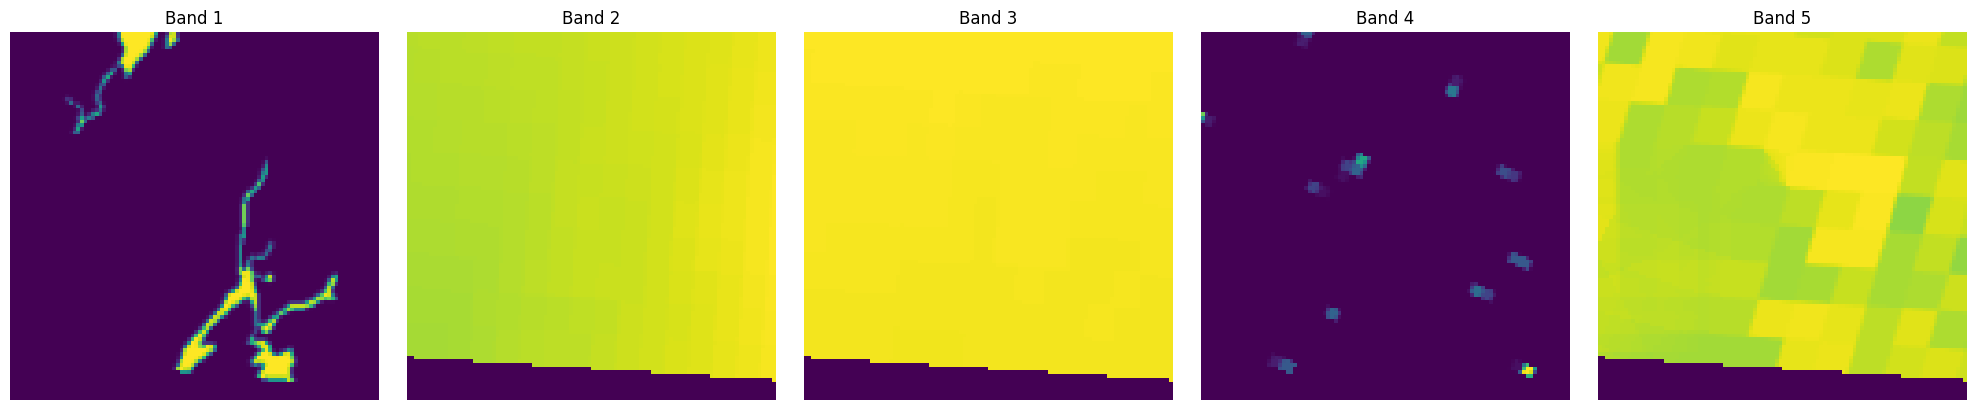

In [565]:
# Load the first patch (replace with the id you want)
for i in range(10):
    first_patch_id = patch_ids[i]
    patch = zarr_group[first_patch_id][...]
    print(patch_ids[i])
    visualize_bands(patch, num_bands=5)


In [91]:
import zarr

zarr_group = zarr.open_group("../data/data_layers/pred_100_dataset.zarr", mode='r')

print("Top-level keys:", list(zarr_group.group_keys()))  # ['raster_data']

raster_data_group = zarr_group["raster_data"]

print("Arrays inside 'raster_data':", list(raster_data_group.array_keys()))  # should list patch IDs


Top-level keys: ['raster_data']
Arrays inside 'raster_data': ['-578.0180_421.9820_-453.4386_546.5614', '-577.8425_422.1575_-453.1483_546.8517', '-578.1797_421.8203_-453.5450_546.4550', '-577.8442_422.1558_-453.1521_546.8479', '-577.9276_422.0724_-453.1859_546.8141', '-578.1722_421.8278_-453.5457_546.4543', '-578.0310_421.9690_-453.3110_546.6890', '-578.1020_421.8980_-453.1426_546.8574', '-578.0341_421.9659_-453.3117_546.6883', '-578.2291_421.7709_-453.3784_546.6216', '-578.2271_421.7729_-453.2434_546.7566', '-578.2727_421.7273_-453.4601_546.5399', '-577.8435_422.1565_-453.1504_546.8496', '-578.2657_421.7343_-453.4625_546.5375', '-578.2224_421.7776_-453.2487_546.7513', '-578.2261_421.7739_-453.3754_546.6246', '-578.1124_421.8876_-453.3461_546.6539', '-578.0360_421.9640_-453.3121_546.6879', '-578.2704_421.7296_-453.4608_546.5392', '-578.2256_421.7744_-453.2451_546.7549', '-577.9916_422.0084_-453.2377_546.7623', '-578.1131_421.8869_-453.3474_546.6526', '-578.1149_421.8851_-453.3508_546.64

### Satelitte data

In [ ]:
# Now use TorchGeo's built-in Sentinel2 dataset
import torch
from torchgeo.datasets import Sentinel2
from pathlib import Path
from torch.utils.data import DataLoader
from torchgeo.samplers import RandomGeoSampler

locations = processed_species_original_locations.geometry
locations = locations.to_crs("EPSG:4326")  # Ensure locations are in WGS84 for sampling
data_dir_sentinel2 = Path("../data/sentinel2_tiles")
sentinel2_dataset = Sentinel2(paths=str(data_dir_sentinel2), bands=['B02'], res=100, transforms=None)

sentinel2_point_sampler = PointGeoSampler(
    dataset=sentinel2_dataset,
    locations=locations,
    side_length_meters=10000,
)
sentinel2_queries = sentinel2_point_sampler.get_all_queries()
print(sentinel2_queries[0])

BoundingBox(minx=-83.184149, maxx=-73.184149, miny=41.45549900000005, maxy=51.45549900000005, mint=1717214400.0, maxt=1720152000.999999)


In [50]:
locations

0         POINT (-78.18415 46.4555)
1         POINT (-78.1816 46.45517)
2        POINT (-78.17968 46.45499)
3        POINT (-78.17597 46.45457)
4        POINT (-78.17846 46.45485)
                    ...            
24727    POINT (-70.66489 45.40489)
24728    POINT (-70.66828 45.40126)
24729    POINT (-70.66694 45.40269)
24730    POINT (-70.66591 45.40381)
24731    POINT (-70.66132 45.40872)
Name: geometry, Length: 24732, dtype: geometry

Patch shape: torch.Size([5, 500, 500])


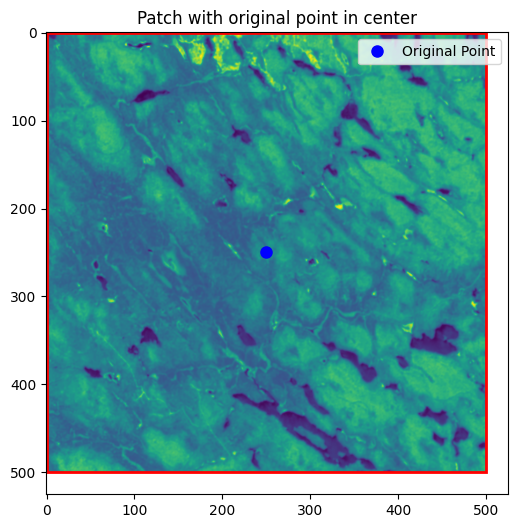

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Take the first patch
point_index = 3
query = sentinel2_queries[point_index]
patch_data = sentinel2_dataset[query]['image']  # shape: [C, H, W]

# Pick a band to visualize (e.g., first band)
band_data = patch_data[4].numpy()  

# Plot the raster patch
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(band_data, cmap='viridis', origin='upper')

# Get patch bounds in raster CRS
xmin, xmax = query.minx, query.maxx
ymin, ymax = query.miny, query.maxy

# Draw rectangle around patch (in pixel coordinates)
rect = patches.Rectangle(
    (0, 0),  # top-left in array coordinates
    band_data.shape[1],  # width in pixels
    band_data.shape[0],  # height in pixels
    linewidth=2, edgecolor='red', facecolor='none'
)
ax.add_patch(rect)

# Plot original point in pixel coordinates relative to patch
# Convert map coordinates to pixels
point = sentinel2_point_sampler.points_in_dataset_crs.geometry.iloc[point_index]
# You need to know the pixel resolution (meters per pixel) for correct conversion.
# If patch_data.shape matches the patch size in meters, then:
pixel_size_x = (xmax - xmin) / band_data.shape[1]
pixel_size_y = (ymax - ymin) / band_data.shape[0]
x_center = (point.x - xmin) / pixel_size_x
y_center = (ymax - point.y) / pixel_size_y
ax.plot(x_center, y_center, 'bo', markersize=8, label='Original Point')

ax.set_title("Patch with original point in center")
ax.legend()
print(f"Patch shape: {patch_data.shape}")  # should be (C, H, W)
plt.show()


In [ ]:
# Path to the output Zarr store
zarr_output_path = '../data/zarr_patches/pred100.zarr'
side_length_meters = 10000
locations = processed_species_original_locations.geometry

# Now, call the optimized function with your data
extract_patches_sequentially(
    dataset=pred_100_dataset,
    locations=locations,
    side_length_meters=side_length_meters,
    zarr_path=zarr_output_path
)

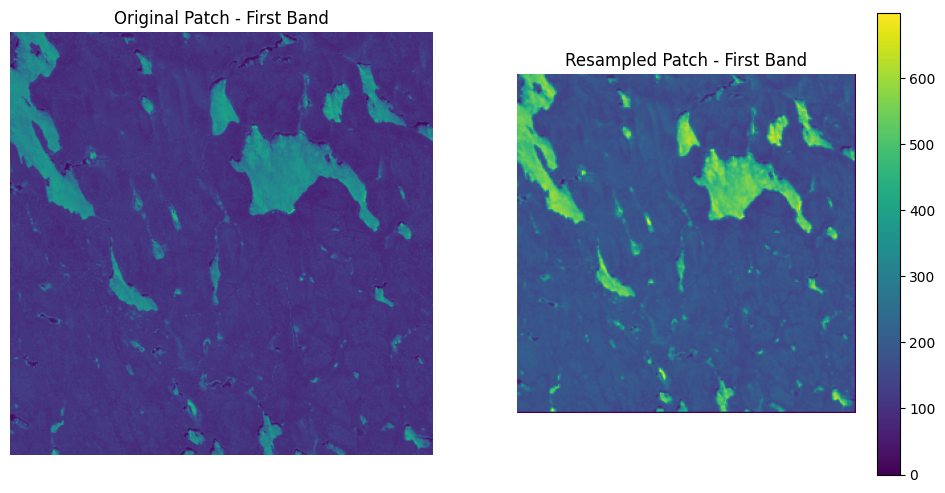

In [621]:
#plot the resampled patch first band next to the original patch first band
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(patch['image'][0], cmap='viridis')
ax[0].set_title("Original Patch - First Band")
ax[0].axis('off')

ax[1].imshow(resampled_patch[0], cmap='viridis')
ax[1].set_title("Resampled Patch - First Band")
ax[1].axis('off')

plt.colorbar(ax[1].images[0], ax=ax[1])
plt.show()

### Download Sentinel-2 data for specific tiles and bands

In [10]:
processed_species_original_locations.to_crs('EPSG:4326', inplace=True)

In [ ]:
import ee
import os
import re
import geemap
import time
import rasterio
import numpy as np
from tqdm import tqdm

ee.Initialize()

# --- User parameters ---
OUTPUT_DIR = "../data/sentinel2_tiles_drive"
os.makedirs(OUTPUT_DIR, exist_ok=True)

START_DATE = "2024-06-01"
END_DATE = "2024-08-28"
CLOUD_COVER = 30

BANDS = ['B2','B3','B4','B8','B11']
DERIVED_BANDS = ['NDVI', 'moisture']
ALL_BANDS = BANDS + DERIVED_BANDS

TILE_SIZE = 1.0  # ~100km tiles

PATTERN = re.compile(
    r"""
    ^T(?P<tile>\d{2}[A-Z]{3})                # Tile, e.g., T17TPL
    _
    (?P<date>\d{8})                           # Date, YYYYMMDD
    (?:T(?P<time>\d{6}))?                     # Optional time, HHMMSS
    _
    (?P<band>(?:B(?:\d{1,2}|8A)|NDVI|moisture)) # Band
    (?:_(?P<res>\d{1,3}m))?                   # Optional resolution
    \.(?P<ext>[^.]+)$                         # File extension
    """,
    re.VERBOSE | re.IGNORECASE,
)

# --- Derived bands ---
def add_derived_bands(composite):
    ndvi = composite.expression('(NIR - RED) / (NIR + RED)',
        {'NIR': composite.select('B8'), 'RED': composite.select('B4')}).rename('NDVI')
    moisture = composite.expression('(SWIR - NIR) / (SWIR + NIR)',
        {'SWIR': composite.select('B11'), 'NIR': composite.select('B8')}).rename('moisture')
    return composite.addBands(ndvi).addBands(moisture)

# --- Validate a tile ---
def is_tile_valid(filepath, nodata=None, min_valid_pixels=10):
    try:
        with rasterio.open(filepath) as src:
            data = src.read(1, masked=True)
            if nodata is not None:
                data = np.ma.masked_equal(data, nodata)
            valid_pixels = np.count_nonzero(~data.mask)
            return valid_pixels >= min_valid_pixels
    except Exception as e:
        print(f"Tile read failed for {filepath}: {e}")
        return False

# --- Export large tile to Drive / local folder ---
def export_tile(tile_geom):
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterBounds(tile_geom)
                  .filterDate(START_DATE, END_DATE)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_COVER))
                  .median()
                  .select(BANDS))
    
    collection = add_derived_bands(collection)
    
    first_img = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                    .filterBounds(tile_geom)\
                    .filterDate(START_DATE, END_DATE)\
                    .sort('system:time_start')\
                    .first()
    timestamp = ee.Date(first_img.get('system:time_start')).format('yyyyMMdd').getInfo()
    mgrs_id = first_img.get('MGRS_TILE').getInfo()
    
    for band in ALL_BANDS:
        if band in ['B8', 'B11']:
            continue
        band_image = collection.select(band)
        filename = f"T{mgrs_id}_{timestamp}_{band}.tif"
        filepath = os.path.join(OUTPUT_DIR, filename)
        
        try:
            geemap.ee_export_image(
                ee_object=band_image,
                filename=filepath,
                scale=20,
                region=tile_geom,
                file_per_band=True
            )
            time.sleep(0.5)

            if not is_tile_valid(filepath):
                print(f"Warning: tile {filename} is invalid or empty, retrying download.")
                os.remove(filepath)
                # Retry once
                geemap.ee_export_image(
                    ee_object=band_image,
                    filename=filepath,
                    scale=20,
                    region=tile_geom,
                    file_per_band=True
                )
                time.sleep(0.5)
                if not is_tile_valid(filepath):
                    print(f"Failed again: {filename}")
                    os.remove(filepath)

        except Exception as e:
            print(f"Failed to export {filename}: {e}")
            if os.path.exists(filepath):
                os.remove(filepath)

# --- Create large tiles over AOI ---
def create_tiles(bbox, tile_size):
    minx, miny, maxx, maxy = bbox
    x_coords = [minx, maxx - tile_size]
    y_coords = [miny, maxy - tile_size]
    tiles = [(x, y, x + tile_size, y + tile_size) for x in x_coords for y in y_coords]
    return tiles

# --- Main ---
if __name__ == "__main__":
    bbox = processed_species_original_locations.total_bounds
    tiles = create_tiles(bbox, TILE_SIZE)
    
    for tile in tqdm(tiles):
        geom = ee.Geometry.Rectangle(tile)
        try:
            export_tile(geom)
        except Exception as e:
            print(f"Failed tile {tile}: {e}")


Downloaded T17UPT_20240602T000000_B2.tif
Downloaded T18TVR_20240601T000000_B2.tif
Downloaded T17UPT_20240602T000000_B3.tif
Downloaded T18TVS_20240701T000000_B2.tif
Downloaded T17TQN_20240619T000000_B2.tif
Downloaded T17UPT_20240602T000000_B2.tif
Downloaded T17UPQ_20240612T000000_B2.tif
Downloaded T18UVU_20240616T000000_B2.tif
Downloaded T18TUS_20240624T000000_B2.tif
Downloaded T17TQL_20240624T000000_B2.tif
Downloaded T18UVB_20240611T000000_B2.tif
Downloaded T18UUA_20240622T000000_B2.tif
Downloaded T18TUR_20240624T000000_B2.tif
Downloaded T17UPT_20240602T000000_B4.tif
Downloaded T18TVS_20240701T000000_B3.tif


Process ForkPoolWorker-197:
Process ForkPoolWorker-199:
Process ForkPoolWorker-203:
Process ForkPoolWorker-204:
Process ForkPoolWorker-201:
Process ForkPoolWorker-202:


KeyboardInterrupt: 

In [10]:
import os
import re
from pathlib import Path

# Updated pattern: allow NDVI and moisture as bands
PATTERN = re.compile(
    r"""
    ^T(?P<tile>\d{2}[A-Z]{3})                # Tile, e.g., T17TPL
    _
    (?P<date>\d{8})                           # Date, YYYYMMDD
    (?:T(?P<time>\d{6}))?                     # Optional time, HHMMSS
    _
    (?P<band>(?:B(?:\d{1,2}|8A)|NDVI|moisture)) # Band: B2, B02, B8A, NDVI, moisture
    (?:_(?P<res>\d{1,3}m))?                   # Optional resolution, e.g., 10m
    (?:\.(?P=band))?                          # Optional stray .{band}
    \.(?P<ext>[^.]+)$                         # File extension
    """,
    re.VERBOSE | re.IGNORECASE,
)

def normalize_band(band: str) -> str:
    """Normalize numeric bands to B02/B03 but keep NDVI and moisture as-is."""
    band_upper = band.upper()
    if band_upper in {"NDVI", "MOISTURE"}:
        return band_upper
    if band_upper.startswith("B"):
        tail = band_upper[1:]
        if tail.isdigit():
            return f"B{int(tail):02d}"
        return f"B{tail}"
    return band_upper

def build_target_name(tile, date, time, band, res, ext) -> str:
    """Build a corrected filename."""
    time = time if time else "000000"
    band = normalize_band(band)
    core = f"T{tile}_{date}T{time}_{band}"
    if res:
        core += f"_{res}"
    return f"{core}.{ext}"

def plan_rename(name: str):
    """Return the corrected filename if renaming is needed, else None."""
    m = PATTERN.match(name)
    if not m:
        return None
    tile = m.group("tile")
    date = m.group("date")
    time = m.group("time")
    band = m.group("band")
    res = m.group("res")
    ext = m.group("ext")
    target = build_target_name(tile, date, time, band, res, ext)
    return target if target != name else None

def fix_s2_filenames(base_path, recursive=True, commit=True, verbose=True):
    """
    Fix Sentinel-2/NDVI/moisture filenames and delete .zip files.

    Args:
        base_path (str or Path): directory or file to process.
        recursive (bool): scan subdirectories if True.
        commit (bool): apply changes if True, else dry-run.
        verbose (bool): print actions.
    """
    base_path = Path(base_path)
    renamed = deleted = examined = 0

    if base_path.is_file():
        paths = [base_path]
    else:
        paths = base_path.rglob("*") if recursive else base_path.iterdir()

    for path in paths:
        if not path.is_file():
            continue
        examined += 1
        name = path.name

        # Delete .zip files
        if name.lower().endswith(".zip"):
            if verbose:
                print(f"DELETE: {name}")
            if commit:
                path.unlink()
            deleted += 1
            continue

        # Plan rename
        new_name = plan_rename(name)
        if new_name:
            if verbose:
                print(f"RENAME: {name} -> {new_name}")
            if commit:
                target = path.with_name(new_name)
                if target.exists():
                    if verbose:
                        print(f"  !! Skipped, target exists: {target}")
                else:
                    path.rename(target)
            renamed += 1
        else:
            if verbose:
                if PATTERN.match(name):
                    print(f"OK   : {name}")
                else:
                    print(f"SKIP : {name} (not a recognized file)")

    if verbose:
        print(f"Examined: {examined} | Renamed: {renamed} | Deleted .zip: {deleted}")


# Example:
# fix_s2_filenames("/path/to/files", recursive=True, commit=True)


In [12]:
# Dry run (preview changes)
fix_s2_filenames("../data/sentinel2_tiles", recursive=False, commit=True)

RENAME: T18TVT_20240701_NDVI.NDVI.tif -> T18TVT_20240701T000000_NDVI.tif
RENAME: T17UPP_20240612_moisture.moisture.tif -> T17UPP_20240612T000000_MOISTURE.tif
OK   : T18UUB_20240611T000000_B04.tif
OK   : T17UQP_20240619T000000_B04.tif
RENAME: T17UPQ_20240612_NDVI.NDVI.tif -> T17UPQ_20240612T000000_NDVI.tif
RENAME: T19TFM_20240604_moisture.moisture.tif -> T19TFM_20240604T000000_MOISTURE.tif
RENAME: T18UUA_20240611_moisture.moisture.tif -> T18UUA_20240611T000000_MOISTURE.tif
RENAME: T19UDR_20240607_NDVI.NDVI.tif -> T19UDR_20240607T000000_NDVI.tif
RENAME: T18UXV_20240601_moisture.moisture.tif -> T18UXV_20240601T000000_MOISTURE.tif
OK   : T19UES_20240625T000000_B03.tif
OK   : T19UCP_20240625T000000_B04.tif
OK   : T19UDU_20240603T000000_B03.tif
RENAME: T19TCN_20240603_moisture.moisture.tif -> T19TCN_20240603T000000_MOISTURE.tif
OK   : T18UUB_20240611T000000_B02.tif
OK   : T17TPM_20240617T000000_B02.tif
OK   : T19UCQ_20240603T000000_B02.tif
RENAME: T18UXB_20240603_NDVI.NDVI.tif -> T18UXB_2024

### validating tiles coverage

In [ ]:
from os import cpu_count
from multiprocessing import Pool
from tqdm import tqdm
def _check_query_worker(args):
    """
    Worker function to check a single query.
    Re-initializes the dataset in each process.
    """
    # Unpack the arguments
    paths, bands, separate_files, query = args
    try:
        # Create a new dataset instance within this worker process
        dataset = IndependentBandsDataset(
            paths=paths,
            all_bands=bands,
            separate_files=separate_files
        )
        _ = dataset[query]
        return query, False
    except Exception:
        return query, True


def find_missing_queries_parallel(
    dataset_params, all_queries: list, num_workers=None, chunksize=1
):
    """
    Finds missing queries by attempting to load data in parallel.

    Args:
        dataset_params (dict): Dictionary of parameters to re-create the dataset.
        all_queries (list): List of BoundingBox objects.
        num_workers (int, optional): Number of worker processes (defaults to CPU cores).
        chunksize (int, optional): How many queries to send to each worker at a time.

    Returns:
        list: Missing BoundingBox queries.
    """
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)  # leave 1 core free

    missing_queries = []
    #print(f"Checking each query in parallel with {num_workers} workers...")

    # Prepare arguments for the workers
    worker_args = [
        (
            dataset_params["root"],
            dataset_params["all_bands"],
            dataset_params["separate_files"],
            #dataset_params["crs"],
            q,
        )
        for q in all_queries
    ]

    with Pool(processes=num_workers) as pool:
        for query, is_missing in tqdm(
            pool.imap_unordered(_check_query_worker, worker_args, chunksize),
            total=len(all_queries),
        ):
            if is_missing:
                missing_queries.append(query)

    print(f"\nTotal queries: {len(all_queries)}")
    print(f"Queries covered: {len(all_queries) - len(missing_queries)}")
    print(f"Queries missing: {len(missing_queries)}")

    return missing_queries




# Example usage:
# Assuming `sentinel2_dataset` and `sentinel2_queries` are already defined
dataset_params = {
    "root": "../data/data_layers/predictors_100_QC_normalized",
    "all_bands": ["alluvion", "barren"],
    "separate_files": True,
    #"resolution": 100,
}
dataset = IndependentBandsDataset(paths= "../data/data_layers/predictors_100_QC_normalized",
                                         all_bands=['alluvion', 'barren'],
                                         separate_files=True)
# Assuming processed_species_original_locations is defined
# e.g., from a GeoDataFrame
# import geopandas as gpd
# processed_species_original_locations = gpd.read_file(...)
point_sampler = PointGeoSampler(
    dataset=sentinel2_dataset,
    locations=processed_species_original_locations.geometry,
    side_length_meters=10000
)
queries = sentinel2_point_sampler.get_all_queries()

missing_queries = find_missing_queries_parallel(
    dataset_params=dataset_params, all_queries=queries
)

100%|██████████| 24732/24732 [00:00<00:00, 28699.58it/s]


Total queries: 24732
Queries covered: 0
Queries missing: 24732


In [ ]:
sentinel2_dataset = IndependentBandsDataset(paths= "../data/data_layers/predictors_100_QC_normalized",
                                         all_bands=['alluvion', 'barren'],
                                         separate_files=True)

sentinel2_dataset[sentinel2_queries[0]]['image'].shape  # Test loading a query

torch.Size([2, 100, 100])

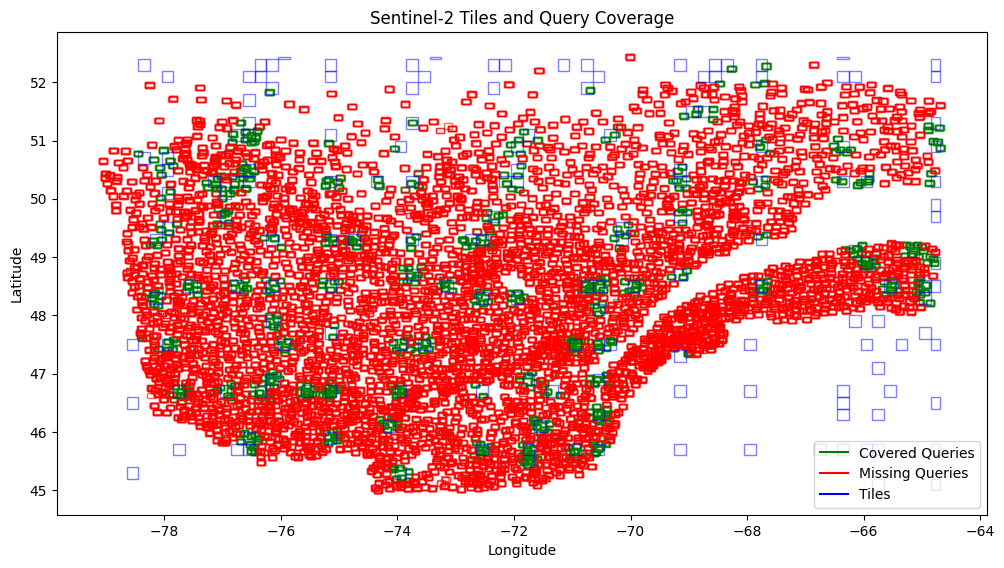

In [74]:
import pandas as pd
import rasterio
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchgeo.datasets import Sentinel2
from pyproj import Transformer

dataset = sentinel2_dataset
processed_species_original_locations.to_crs(dataset.crs, inplace=True)  # Ensure locations are in dataset CRS   
point_sampler = PointGeoSampler(
    dataset=dataset,
    locations=processed_species_original_locations.geometry,
    side_length_meters=10000
)
dataset_queries = point_sampler.get_all_queries()


# Convert raster bounds to GeoDataFrame in their CRS, and reproject to common CRS before concatenation
tile_gdfs = []
for fpath in dataset.files:
    with rasterio.open(fpath) as src:
        tile_box = box(*src.bounds)
        gdf_tile = gpd.GeoDataFrame(geometry=[tile_box], crs=src.crs)
        gdf_tile = gdf_tile.to_crs(dataset.crs)  # Reproject to dataset CRS
        tile_gdfs.append(gdf_tile)

# Concatenate all tiles (now all in dataset CRS)
tiles_gdf = gpd.GeoDataFrame(pd.concat(tile_gdfs, ignore_index=True), crs=dataset.crs)

# Function to plot queries and tiles
def plot_query_and_tile_bboxes(covered_queries, missing_queries, tiles_gdf):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    def add_bboxes(queries, color, label, fill=False):
        for q in queries:
            width = q.maxx - q.minx
            height = q.maxy - q.miny
            ax.add_patch(Rectangle(
                (q.minx, q.miny), width, height,
                fill=fill, edgecolor=color, linewidth=1, alpha=0.6
            ))
        ax.plot([], [], color=color, label=label)
    
    add_bboxes(covered_queries, "green", "Covered Queries")
    add_bboxes(missing_queries, "red", "Missing Queries")
    
    #Plot tile bounding boxes
    for geom in tiles_gdf.geometry:
        minx, miny, maxx, maxy = geom.bounds
        ax.add_patch(Rectangle(
            (minx, miny), maxx - minx, maxy - miny,
            fill=False, edgecolor="blue", linewidth=1, alpha=0.5
        ))
    ax.plot([], [], color="blue", label="Tiles")
    
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Sentinel-2 Tiles and Query Coverage")
    ax.legend()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

# Example usage
covered_queries = [q for q in dataset_queries if q not in missing_queries]
plot_query_and_tile_bboxes(covered_queries, missing_queries, tiles_gdf)


In [79]:
#export as shapefile the bounding box of sentinel2 dataset
import geopandas as gpd

from shapely.geometry import box

# Convert dataset.bounds (BoundingBox) to a shapely box
bbox_geom = box(dataset.bounds.minx, dataset.bounds.miny, dataset.bounds.maxx, dataset.bounds.maxy)
bbox = gpd.GeoDataFrame(geometry=[bbox_geom], crs=dataset.crs)

# Export to shapefile
bbox.to_file("sentinel2_bbox.shp")

In [12]:
# Transformer from EPSG:32617 -> EPSG:4326
transformer = Transformer.from_crs("EPSG:32617", "EPSG:4326", always_xy=True)
#convert missing_queries to a dictionary format
bboxes_dict = {"EPSG:32617": []}
for bbox in missing_queries:
    bboxes_dict["EPSG:32617"].append({
        "minx": bbox.minx,
        "miny": bbox.miny,
        "maxx": bbox.maxx,
        "maxy": bbox.maxy,
        "mint": bbox.mint,
        "maxt": bbox.maxt
    })
# Convert all bounding boxes dynamically
bboxes_4326 = []
for bbox in bboxes_dict["EPSG:32617"]:
    min_lon, min_lat = transformer.transform(bbox["minx"], bbox["miny"])
    max_lon, max_lat = transformer.transform(bbox["maxx"], bbox["maxy"])
    
    # Create shapely box and store time info
    shapely_box = box(min_lon, min_lat, max_lon, max_lat)
    bboxes_4326.append(list(shapely_box.exterior.coords))

# Example: print the first converted box
bboxes_4326

[[(-78.33440890189017, 47.62147461407378),
  (-78.33440890189017, 47.708345695663866),
  (-78.47192912113702, 47.708345695663866),
  (-78.47192912113702, 47.62147461407378),
  (-78.33440890189017, 47.62147461407378)],
 [(-78.33578559566013, 47.622520800100716),
  (-78.33578559566013, 47.709393510591184),
  (-78.47330642041314, 47.709393510591184),
  (-78.47330642041314, 47.622520800100716),
  (-78.33578559566013, 47.622520800100716)],
 [(-78.33674242970679, 47.62321323332924),
  (-78.33674242970679, 47.710087078075645),
  (-78.47426358174714, 47.710087078075645),
  (-78.47426358174714, 47.62321323332924),
  (-78.33674242970679, 47.62321323332924)],
 [(-78.33800011420915, 47.62419549051326),
  (-78.33800011420915, 47.71107082172527),
  (-78.47552189072819, 47.71107082172527),
  (-78.47552189072819, 47.62419549051326),
  (-78.33800011420915, 47.62419549051326)]]

In [ ]:
#count the unique tiles in data_dir_sentinel2
import os
def count_unique_tiles(data_dir: str):
    """
    Counts unique Sentinel-2 tiles in the specified directory.

    Args:
        data_dir (str): Path to the directory containing Sentinel-2 data.

    Returns:
        int: Number of unique tiles found.
    """
    unique_tiles = set()
    
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.tif'):
                # Extract tile name from the file name
                tile_name = file.split('_')[0]  # Assuming tile name is the first part before '_'
                print(f"Found tile: {tile_name}")
                unique_tiles.add(tile_name)
    return len(unique_tiles)
# Count unique tiles in the Sentinel-2 data directory
unique_tile_count = count_unique_tiles(data_dir_sentinel2)
print(f"Number of unique Sentinel-2 tiles: {unique_tile_count}")

Found tile: T19UCR
Found tile: T19UDP
Found tile: T17TQM
Found tile: T19UGR
Found tile: T19UEU
Found tile: T19UEU
Found tile: T18TUR
Found tile: T19UCR
Found tile: T20UMB
Found tile: T18TYQ
Found tile: T18UVB
Found tile: T17UPT
Found tile: T18TWR
Found tile: T18TVR
Found tile: T18TVT
Found tile: T19UDR
Found tile: T18TUR
Found tile: T19UCU
Found tile: T18UYC
Found tile: T17TPM
Found tile: T19UGQ
Found tile: T19UEU
Found tile: T17UQQ
Found tile: T19UGR
Found tile: T19UCT
Found tile: T19TCM
Found tile: T18UYD
Found tile: T19UCP
Found tile: T18UWC
Found tile: T19TDL
Found tile: T20ULV
Found tile: T18UUU
Found tile: T18TUS
Found tile: T19UEP
Found tile: T17UQQ
Found tile: T18TYR
Found tile: T18TXT
Found tile: T19UDP
Found tile: T18TYS
Found tile: T19UGQ
Found tile: T20ULU
Found tile: T20UMB
Found tile: T18TWR
Found tile: T17TPM
Found tile: T18TUS
Found tile: T19UFU
Found tile: T19UCU
Found tile: T19UDR
Found tile: T18TWR
Found tile: T18UVB
Found tile: T17UQT
Found tile: T17TQM
Found tile: 

In [6]:
import ee
import geemap
import geopandas as gpd

# Assurez-vous d'avoir initialisé Earth Engine
ee.Authenticate()
ee.Initialize()

# Supposons que votre GeoDataFrame soit nommé 'gdf'
# Convertissez le GeoDataFrame en une FeatureCollection Earth Engine
points_ee = geemap.geopandas_to_ee(processed_species_original_locations.iloc[:5])

def create_square_aoi(feature):
    # Get the centroid of the feature's geometry.
    center = feature.geometry().centroid()

    # Create a 5000m buffer around the center.
    # Earth Engine will automatically use a local projected coordinate system
    # to perform the calculation, ensuring the distance is accurate in meters.
    aoi_circle = center.buffer(5000)

    # Get the bounding box of the circular buffer to create a square.
    aoi_square = aoi_circle.bounds()

    # Return the square as a new feature.
    return ee.Feature(aoi_square)

# Apply the function to your collection of points.
aois_squares = points_ee.map(create_square_aoi)
# Convert the resulting FeatureCollection to a GeoDataFrame



In [7]:
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2024-06-01', '2024-09-01') \
    .filterBounds(aois_squares) \
    .median() \
    .select(['SR_B2', 'SR_B3', 'SR_B4'], ['blue', 'green', 'red']) # sélectionnez les bandes qui vous intéressent



Raster shape: (9, 334, 484)
Available bands:
  Band 1: blue
  Band 2: green
  Band 3: red
  Band 4: nir
  Band 5: swir1
  Band 6: swir2
  Band 7: ndvi
  Band 8: ndwi
  Band 9: evi


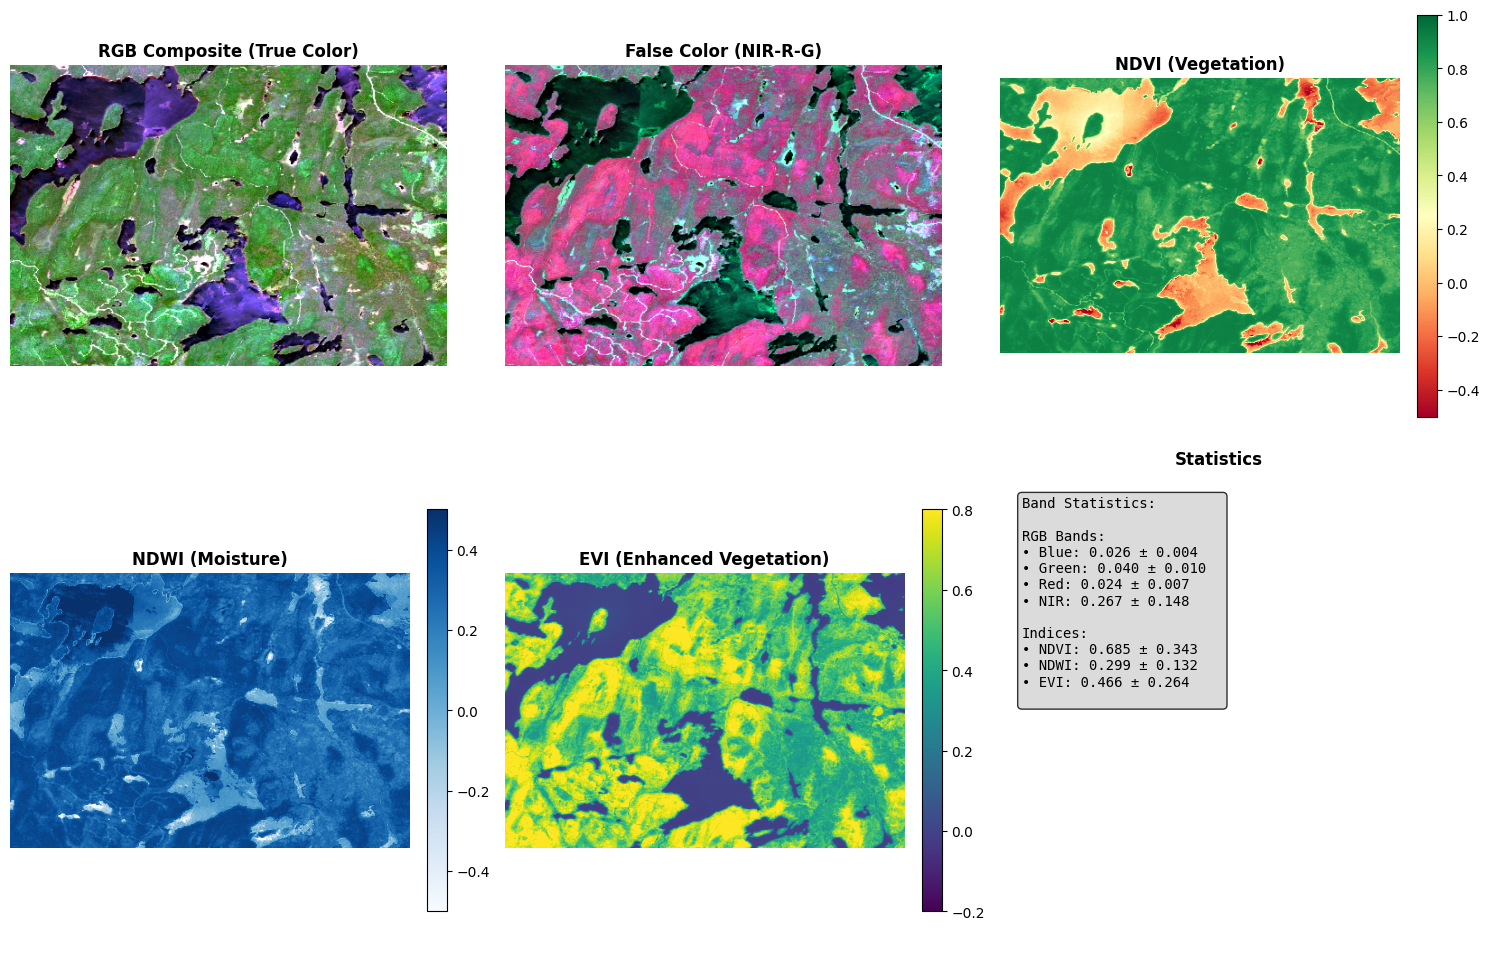


Image dimensions: 334 x 484 pixels
Pixel size: | 0.00, 0.00,-78.30|
| 0.00,-0.00, 46.66|
| 0.00, 0.00, 1.00|
CRS: EPSG:4326


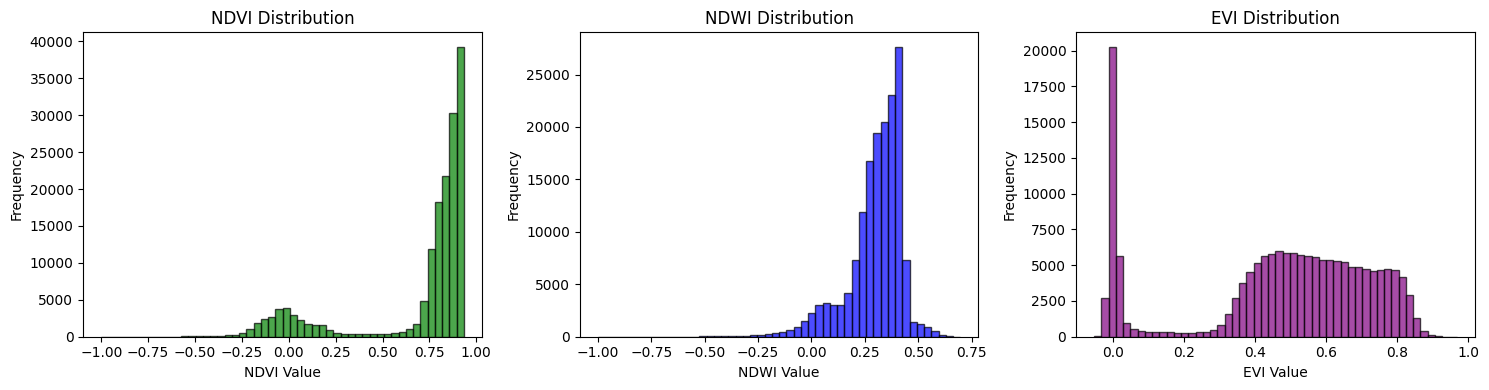

In [44]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the raster data from a .tif file
tif_path = "../data/sentinel2_tiles_normalized/s2_-78.23343_46.617181000000016_multiband.tif"
with rasterio.open(tif_path) as src:
    band_data = src.read()  # shape: (bands, height, width) for multi-band
    print(f"Raster shape: {band_data.shape}")
    metadata = src.meta

# Band order from our export:
# Band 1: blue, Band 2: green, Band 3: red, Band 4: nir, 
# Band 5: swir1, Band 6: swir2, Band 7: ndvi, Band 8: ndwi, Band 9: evi
band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'ndvi', 'ndwi', 'evi']

print("Available bands:")
for i, name in enumerate(band_names[:band_data.shape[0]]):
    print(f"  Band {i+1}: {name}")

def robust_normalize(band, percentile_range=(2, 98)):
    """Normalize band using percentile clipping to handle outliers"""
    # Remove NaN values for percentile calculation
    valid_pixels = band[~np.isnan(band)]
    if len(valid_pixels) == 0:
        return np.zeros_like(band)
    
    # Use percentile clipping for better visualization
    p_low, p_high = np.percentile(valid_pixels, percentile_range)
    normalized = np.clip((band - p_low) / (p_high - p_low), 0, 1)
    return normalized

def create_rgb_composite(red_band, green_band, blue_band):
    """Create RGB composite with proper normalization"""
    # Normalize each band independently
    red_norm = robust_normalize(red_band)
    green_norm = robust_normalize(green_band)  
    blue_norm = robust_normalize(blue_band)
    
    # Stack into RGB
    rgb = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    return rgb

def visualize_sentinel2_data(band_data, band_names):
    """Visualize RGB composite, NDVI, NDWI, and EVI"""
    
    # Check if we have the required bands
    if band_data.shape[0] < 9:
        print(f"Warning: Expected 9 bands, got {band_data.shape[0]}")
    
    # Extract specific bands (0-indexed)
    blue = band_data[0]    # Band 1: blue
    green = band_data[1]   # Band 2: green  
    red = band_data[2]     # Band 3: red
    nir = band_data[3]     # Band 4: nir
    ndvi = band_data[6]    # Band 7: ndvi
    ndwi = band_data[7]    # Band 8: ndwi (moisture)
    evi = band_data[8]     # Band 9: evi
    
    # Create RGB composite
    rgb_composite = create_rgb_composite(red, green, blue)
    
    # Set up the plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # RGB Composite
    axes[0, 0].imshow(rgb_composite)
    axes[0, 0].set_title('RGB Composite (True Color)', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # False Color Composite (NIR, Red, Green) - good for vegetation
    false_color = create_rgb_composite(nir, red, green)
    axes[0, 1].imshow(false_color)
    axes[0, 1].set_title('False Color (NIR-R-G)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # NDVI
    ndvi_display = np.clip(ndvi, -1, 1)  # NDVI should be between -1 and 1
    im_ndvi = axes[0, 2].imshow(ndvi_display, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    axes[0, 2].set_title('NDVI (Vegetation)', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    plt.colorbar(im_ndvi, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # NDWI (Moisture)
    ndwi_display = np.clip(ndwi, -1, 1)  # NDWI should be between -1 and 1
    im_ndwi = axes[1, 0].imshow(ndwi_display, cmap='Blues', vmin=-0.5, vmax=0.5)
    axes[1, 0].set_title('NDWI (Moisture)', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im_ndwi, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # EVI
    evi_display = np.clip(evi, -1, 1)  # EVI typically ranges from -1 to 1
    im_evi = axes[1, 1].imshow(evi_display, cmap='viridis', vmin=-0.2, vmax=0.8)
    axes[1, 1].set_title('EVI (Enhanced Vegetation)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(im_evi, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    # Individual band statistics
    stats_text = f"""Band Statistics:
    
RGB Bands:
• Blue: {np.nanmean(blue):.3f} ± {np.nanstd(blue):.3f}
• Green: {np.nanmean(green):.3f} ± {np.nanstd(green):.3f}  
• Red: {np.nanmean(red):.3f} ± {np.nanstd(red):.3f}
• NIR: {np.nanmean(nir):.3f} ± {np.nanstd(nir):.3f}

Indices:
• NDVI: {np.nanmean(ndvi):.3f} ± {np.nanstd(ndvi):.3f}
• NDWI: {np.nanmean(ndwi):.3f} ± {np.nanstd(ndwi):.3f}
• EVI: {np.nanmean(evi):.3f} ± {np.nanstd(evi):.3f}
    """
    
    axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, 
                    fontsize=10, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1, 2].set_title('Statistics', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some diagnostic info
    print(f"\nImage dimensions: {red.shape[0]} x {red.shape[1]} pixels")
    print(f"Pixel size: {metadata.get('transform', 'Unknown')}")
    print(f"CRS: {metadata.get('crs', 'Unknown')}")

# Visualize the data
visualize_sentinel2_data(band_data, band_names)

# Optional: Create a simple histogram of index values
def plot_index_histograms(band_data):
    """Plot histograms of the vegetation indices"""
    if band_data.shape[0] >= 9:
        ndvi = band_data[6].flatten()
        ndwi = band_data[7].flatten()
        evi = band_data[8].flatten()
        
        # Remove NaN values
        ndvi = ndvi[~np.isnan(ndvi)]
        ndwi = ndwi[~np.isnan(ndwi)]
        evi = evi[~np.isnan(evi)]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        axes[0].hist(ndvi, bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[0].set_title('NDVI Distribution')
        axes[0].set_xlabel('NDVI Value')
        axes[0].set_ylabel('Frequency')
        
        axes[1].hist(ndwi, bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[1].set_title('NDWI Distribution')
        axes[1].set_xlabel('NDWI Value')
        axes[1].set_ylabel('Frequency')
        
        axes[2].hist(evi, bins=50, alpha=0.7, color='purple', edgecolor='black')
        axes[2].set_title('EVI Distribution')
        axes[2].set_xlabel('EVI Value')
        axes[2].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

# Create histograms
plot_index_histograms(band_data)

In [6]:
processed_species_original_locations.crs

<Projected CRS: EPSG:6624>
Name: NAD83(CSRS)v2 / Quebec Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Canada - Quebec.
- bounds: (-79.85, 44.99, -57.1, 62.62)
Coordinate Operation:
- name: Quebec Albers Projection
- method: Albers Equal Area
Datum: North American Datum of 1983 (CSRS) version 2
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
import ee
import geemap
import pickle
import os

# Auth & init
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

def mask_s2_clouds(image):
    """Mask clouds in Sentinel-2 using QA60 band and SCL"""
    qa = image.select('QA60')
    scl = image.select('SCL')
    
    # QA60 bits 10 and 11 are clouds and cirrus
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    
    # Create masks
    qa_mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
              qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    
    # SCL mask: keep vegetation(4), not_vegetated(5), water(6), snow_ice(11)
    # Remove clouds(9), cloud_shadows(3), cirrus(10)
    scl_mask = scl.neq(9).And(scl.neq(3)).And(scl.neq(10)).And(scl.neq(8))  # 8 = cloud medium probability
    
    return image.updateMask(qa_mask.And(scl_mask))

def add_indices(image):
    """Add vegetation and moisture indices"""
    # NDVI using Sentinel-2 bands
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    # NDWI (moisture) using NIR and SWIR
    ndwi = image.normalizedDifference(['B8', 'B11']).rename('NDWI')
    
    # EVI (Enhanced Vegetation Index) - often better than NDVI
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8').divide(10000),
            'RED': image.select('B4').divide(10000), 
            'BLUE': image.select('B2').divide(10000)
        }).rename('EVI')
    
    return image.addBands([ndvi, ndwi, evi])

def save_progress(current_index, total_count, progress_file="s2_progress.pkl"):
    """Save current progress"""
    progress = {
        'current_index': current_index,
        'total_count': total_count,
        'processed_ids': []  # Could add this later if needed
    }
    with open(progress_file, 'wb') as f:
        pickle.dump(progress, f)
    print(f"Progress saved: {current_index}/{total_count}")

def load_progress(progress_file="s2_progress.pkl"):
    """Load previous progress"""
    if os.path.exists(progress_file):
        with open(progress_file, 'rb') as f:
            progress = pickle.load(f)
        print(f"Resuming from: {progress['current_index']}/{progress['total_count']}")
        return progress['current_index']
    else:
        print("No previous progress found, starting from beginning")
        return 0

def process_sentinel2_with_resume(processed_species_original_locations, start_index=None):
    """Process Sentinel-2 data with simple resume capability"""
    
    # Load progress or use provided start_index
    if start_index is None:
        start_index = load_progress()
    
    total_count = len(processed_species_original_locations)
    print(f"Processing {total_count - start_index} locations (starting from index {start_index})")
    
    # Sentinel-2 Surface Reflectance collection
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterDate('2024-06-01', '2024-09-01')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
          .map(mask_s2_clouds)
          #.map(add_indices)
          )
    
    # Start processing from the saved index
    for i, (_, row) in enumerate(processed_species_original_locations.iloc[start_index:].iterrows(), start=start_index):
        feature_id = str(row['id'])
        lon, lat = row['geometry'].x, row['geometry'].y
        
        print(f"\n[{i+1}/{total_count}] Processing {feature_id} at ({lat:.4f}, {lon:.4f})")
        
        try:
            # Create AOI (10km x 10km)
            aoi = ee.Geometry.Point([lon, lat]).buffer(5000).bounds()
            
            # Filter collection for this location
            s2_filtered = s2.filterBounds(aoi)
            
            # Check available images
            count = s2_filtered.size().getInfo()
            print(f"  Found {count} Sentinel-2 images")
            
            if count == 0:
                print(f"  No suitable images found for {feature_id}")
                save_progress(i + 1, total_count)  # Save progress even for skipped
                continue
            
            # Create composite - median works well for Sentinel-2
            composite = s2_filtered.median().clip(aoi)

            # Select all 13 Sentinel-2 surface reflectance bands
            sr_bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
            all_bands = (composite
                .select(sr_bands)
                .multiply(0.0001)    # == divide(10000)
                .clamp(0, 1)         # optional
                .toFloat()
            )

            # Add your indices (optional)
            indices = composite.select(['NDVI', 'NDWI', 'EVI']).toFloat()

            # Combine into one multiband image
            multi_band_image = (all_bands
                .addBands(indices.select(['NDVI', 'NDWI', 'EVI']))
                .toFloat())

            
            print(f"  Exporting 9-band composite at 30m resolution...")
            
            # Single export with all bands
            task = ee.batch.Export.image.toDrive(
                image=multi_band_image,
                description=f"s2_{feature_id}_13bands",
                folder='EE_Export_Data',
                fileNamePrefix=f"s2_{feature_id}_13bands",
                region=aoi,
                scale=30,  # resample all to 30m
                crs='EPSG:4326',
                maxPixels=1e9,
                fileFormat='GeoTIFF'
            )

            task.start()
            
            print(f"  ✓ Task submitted for {feature_id}")
            print(f"    Bands: blue, green, red, nir, swir1, swir2, ndvi, ndwi, evi")
            
            # Save progress after each successful submission
            save_progress(i + 1, total_count)
            
        except Exception as e:
            print(f"  ❌ Error processing {feature_id}: {str(e)}")
            print(f"  Saving progress at index {i} and stopping")
            save_progress(i, total_count)  # Save current position (not +1 since this one failed)
            
            # Print resume instructions
            print(f"\n=== RESUME INSTRUCTIONS ===")
            print(f"To resume from where you left off, run:")
            print(f"process_sentinel2_with_resume(processed_species_original_locations, start_index={i})")
            
            # Re-raise the exception so you can see what went wrong
            raise e
    
    print(f"\n✅ All processing complete! Processed {total_count - start_index} locations")
    
    # Clean up progress file when done
    if os.path.exists("s2_progress.pkl"):
        os.remove("s2_progress.pkl")
        print("Progress file cleaned up")

# === USAGE ===

# First run (starts from beginning):
# process_sentinel2_with_resume(processed_species_original_locations)

# Resume after crash (automatically loads saved progress):
# process_sentinel2_with_resume(processed_species_original_locations)

# Resume from specific index:
process_sentinel2_with_resume(processed_species_original_locations, start_index=0)

print("=== READY TO PROCESS ===")
print("Run: process_sentinel2_with_resume(processed_species_original_locations)")
print("If it crashes, just run the same command again to resume from where it stopped")

Processing 21799 locations (starting from index 3161)

[3162/24960] Processing -72.130668_46.509060000000005 at (46.5091, -72.1307)
  Found 9 Sentinel-2 images
  Exporting 9-band composite at 30m resolution...
  ✓ Task submitted for -72.130668_46.509060000000005
    Bands: blue, green, red, nir, swir1, swir2, ndvi, ndwi, evi
Progress saved: 3162/24960

[3163/24960] Processing -72.133387_46.50401800000001 at (46.5040, -72.1334)
  Found 9 Sentinel-2 images
  Exporting 9-band composite at 30m resolution...
  ✓ Task submitted for -72.133387_46.50401800000001
    Bands: blue, green, red, nir, swir1, swir2, ndvi, ndwi, evi
Progress saved: 3163/24960

[3164/24960] Processing -72.053482_46.39665400000001 at (46.3967, -72.0535)
  Found 9 Sentinel-2 images
  Exporting 9-band composite at 30m resolution...
  ✓ Task submitted for -72.053482_46.39665400000001
    Bands: blue, green, red, nir, swir1, swir2, ndvi, ndwi, evi
Progress saved: 3164/24960

[3165/24960] Processing -72.053164_46.39933100000

EEException: Too many tasks already in the queue (3000, limit 3000).

In [13]:
import os
import re

def find_missing_tiles(folder):
    # Regex to extract tile number
    pattern = re.compile(r"S2_LARGE_tile_(\d+)\.tif$")

    # Collect all found tile numbers
    tiles = []
    for fname in os.listdir(folder):
        match = pattern.match(fname)
        if match:
            tiles.append(int(match.group(1)))

    if not tiles:
        print("No tiles found.")
        return []

    tiles = sorted(set(tiles))
    min_tile, max_tile = tiles[0], tiles[-1]

    # Expected full range
    full_range = set(range(min_tile, max_tile + 1))

    # Missing tiles
    missing = sorted(full_range - set(tiles))

    return missing

# Example usage
folder_path = "../data/sentinel2_tiles_ee"
missing_tiles = find_missing_tiles(folder_path)

if missing_tiles:
    print("Missing tiles:", missing_tiles)
else:
    print("No tiles missing.")


Missing tiles: [7, 8, 9, 17, 26, 34, 35, 44, 47, 48, 49, 50, 51, 53, 62, 71, 89, 90, 99, 100, 107, 108, 109, 117, 118, 119, 126, 127, 128, 134, 135, 136, 137, 141, 143, 144, 145, 146, 149]


In [22]:
import os
from pathlib import Path
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow

# Google Drive API scopes
SCOPES = ['https://www.googleapis.com/auth/drive']

def authenticate_drive():
    creds = None
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            if not os.path.exists('credentials.json'):
                raise FileNotFoundError("credentials.json not found!")
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
    return build('drive', 'v3', credentials=creds)

def find_folders(service, folder_name="EE_Export_Data"):
    query = f"name='{folder_name}' and mimeType='application/vnd.google-apps.folder'"
    results = service.files().list(q=query, fields="files(id, name)").execute()
    return results.get('files', [])

def delete_folder(service, folder_id, folder_name):
    try:
        service.files().delete(fileId=folder_id).execute()
        print(f"🗑️  Deleted folder: {folder_name} (ID: {folder_id})")
        return True
    except Exception as e:
        print(f"❌ Failed to delete folder {folder_name}: {e}")
        return False

def bulk_delete_error_folders(target_folder_name="EE_Export_Data"):
    service = authenticate_drive()
    while True:
        folders = find_folders(service, target_folder_name)
        print(f"Found {len(folders)} '{target_folder_name}' folders to delete.")

        deleted_count = 0
        for folder in folders:
            if delete_folder(service, folder['id'], folder['name']):
                deleted_count += 1

        if deleted_count == 0:
            print(f"✅ No more folders to delete.")
            break


    print(f"✅ Deleted {deleted_count} folders.")

# Example usage
bulk_delete_error_folders(target_folder_name="EE_Large_Tiles")


Found 94 'EE_Large_Tiles' folders to delete.
🗑️  Deleted folder: EE_Large_Tiles (ID: 1QYCMF2OVwAitgVVt0zX897P-zyz8LEol)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1ljux9OMetnPMB0OWcE1HxO0gVfa_nY_H)
🗑️  Deleted folder: EE_Large_Tiles (ID: 17I_FJsmyrdS3rLt-YTk9jbCBeQtggLCj)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1vR9zSaoj-QrJSleC2OMDsGqx3BTteT4N)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1xGKCQEFVmoTWZsCKmvnv2--F_G1yzjJ6)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1PhHgWwAAcaVhnJ_1i3GM7APgTRbEqoiX)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1lupcd6Kkne4JfBP7cIb5aNL3L1GYV45D)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1AAZjTC0orpZdENk_hVT7eYF9mZ7MrFFC)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1gDc7qCej7tYdjmUh9lYZGjrNjHV3TaAQ)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1PX2avmjhHXx3veG2RMHXFnH0E82evGYc)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1_w0taBVCpij_-1ubr5f1rUq_F6A_xvTJ)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1W86tog87r_xgNwyIHR579vPiIbEWyEkS)
🗑️  Deleted folder: EE_Large_Tiles (ID: 192xRqeJP4tTVMw

In [22]:
def create_tile_grid(locations_df, tile_size_km=100, buffer_km=10):
    """
    Create a grid of large tiles that cover all your locations
    
    Args:
        locations_df: DataFrame with geometry column containing Points
        tile_size_km: Size of each tile in kilometers
        buffer_km: Buffer around locations to ensure coverage
    """
    bounds = locations_df.bounds
    
    # Add buffer (degrees ≈ km / 111)
    min_x = bounds['minx'].min() - buffer_km/111  
    max_x = bounds['maxx'].max() + buffer_km/111
    min_y = bounds['miny'].min() - buffer_km/111
    max_y = bounds['maxy'].max() + buffer_km/111
    
    print(f"Study area bounds: ({min_x:.3f}, {min_y:.3f}) to ({max_x:.3f}, {max_y:.3f})")
    
    tile_size_deg = tile_size_km / 111
    tiles = []
    tile_id = 0
    
    x = min_x
    while x < max_x:
        y = min_y
        while y < max_y:
            tile_bounds = box(
                x, y,
                min(x + tile_size_deg, max_x),
                min(y + tile_size_deg, max_y)
            )
            
            tile_gdf = gpd.GeoDataFrame(
                [{'tile_id': tile_id, 'geometry': tile_bounds}], 
                crs=locations_df.crs
            )
            
            intersects = gpd.sjoin(locations_df, tile_gdf, how='inner', predicate='within')
            
            if len(intersects) > 0:
                tiles.append({
                    'tile_id': f"tile_{tile_id:03d}",
                    'bounds': tile_bounds.bounds,
                    'geometry': tile_bounds,
                    'location_count': len(intersects),
                    'location_ids': intersects['id'].tolist() if 'id' in intersects.columns else []
                })
            
            tile_id += 1
            y += tile_size_deg
        x += tile_size_deg
    
    tiles_gdf = gpd.GeoDataFrame(tiles, crs=locations_df.crs)
    print(f"Created {len(tiles)} tiles covering {len(locations_df)} locations")
    print(f"Average locations per tile: {len(locations_df)/len(tiles):.1f}")
    
    return tiles_gdf

In [ ]:
import ee
import numpy as np
import pandas as pd
from shapely.geometry import Point, box
import geopandas as gpd

# Auth & init
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()



def export_large_sentinel2_tiles(tiles_gdf, 
                                export_scale=30, 
                                date_range=('2024-06-01', '2024-09-01'),
                                start_tile_number=None):
    """Export large Sentinel-2 tiles with 13 reflectance bands only"""
    
    def mask_s2_clouds(image):
        qa = image.select('QA60')
        scl = image.select('SCL')
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11
        qa_mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
                  qa.bitwiseAnd(cirrus_bit_mask).eq(0))
        scl_mask = scl.neq(9).And(scl.neq(3)).And(scl.neq(10)).And(scl.neq(8))
        return image.updateMask(qa_mask.And(scl_mask))

    # Sentinel-2 SR with cloud mask
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterDate(date_range[0], date_range[1])
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
          .map(mask_s2_clouds))

    # Sentinel-2 reflectance bands (scaled 1e-4)
    sr_bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10', 'B11','B12']
    
    print(f"Exporting {len(tiles_gdf)} large tiles...")

    tasks = []

    for idx, tile in tiles_gdf.iterrows():
        tile_id = tile['tile_id']
        tile_number = int(tile_id.split('_')[1])

        if start_tile_number is not None and tile_number < start_tile_number:
            print(f"Skipping {tile_id} (already processed)")
            continue

        bounds = tile['bounds']
        location_count = tile['location_count']

        print(f"\nTile {tile_id}: {location_count} locations")
        print(f"  Bounds: {bounds}")

        aoi = ee.Geometry.Rectangle(bounds)
        s2_filtered = s2.filterBounds(aoi)
        count = s2_filtered.size().getInfo()

        if count == 0:
            print(f"  Skipping {tile_id} - no images")
            continue

        composite = s2_filtered.median().clip(aoi)

        reflectance = (composite.select(sr_bands)
                       .multiply(0.0001)
                       .clamp(0,1)
                       .toFloat())

        task = ee.batch.Export.image.toDrive(
            image=reflectance,
            description=f"S2_LARGE_{tile_id}",
            folder='EE_Large_Tiles',
            fileNamePrefix=f"S2_LARGE_{tile_id}",
            region=aoi,
            scale=export_scale,
            crs='EPSG:4326',
            maxPixels=1e9,
            fileFormat='GeoTIFF'
        )

        task.start()
        tasks.append({'tile_id': tile_id, 'task': task, 'location_count': location_count})
        print(f"  ✓ Export started for {tile_id} (13 bands)")

    print(f"\n✅ Started {len(tasks)} large tile exports")
    tiles_gdf.to_file('large_tiles_metadata.geojson', driver='GeoJSON')
    print("✓ Saved tile metadata to 'large_tiles_metadata.geojson'")
    return tasks

def estimate_efficiency_gains(locations_df, tile_size_km=100):
    n_locations = len(locations_df)
    current_exports = n_locations
    current_downloads = n_locations
    tiles = create_tile_grid(locations_df, tile_size_km)
    large_exports = len(tiles)
    large_downloads = len(tiles)
    
    print(f"\n=== EFFICIENCY COMPARISON ===")
    print(f"Locations to process: {n_locations:,}")
    print(f"Tile size: {tile_size_km} km\n")
    print(f"CURRENT APPROACH (small tiles):")
    print(f"  Exports: {current_exports:,}")
    print(f"  Downloads: {current_downloads:,}\n")
    print(f"LARGE TILE APPROACH:")
    print(f"  Exports: {large_exports:,}")
    print(f"  Downloads: {large_downloads:,}\n")
    print(f"EFFICIENCY GAINS:")
    print(f"  Export reduction: {current_exports/large_exports:.1f}x fewer")
    print(f"  Download reduction: {current_downloads/large_downloads:.1f}x fewer")
    print(f"  Queue pressure: {large_exports/3000*100:.1f}% of queue limit")
    
    return tiles

# === USAGE ===
print("=== LARGE TILE SENTINEL-2 PROCESSING ===")
print("tiles = create_tile_grid(processed_species_original_locations, tile_size_km=100)")
print("tasks = export_large_sentinel2_tiles(tiles, start_tile_number=38)")

tiles = create_tile_grid(processed_species_original_locations, tile_size_km=100)
tasks = export_large_sentinel2_tiles(tiles)

=== LARGE TILE SENTINEL-2 PROCESSING ===
tiles = create_tile_grid(processed_species_original_locations, tile_size_km=100)
tasks = export_large_sentinel2_tiles(tiles, start_tile_number=38)
Study area bounds: (-79.140, 44.911) to (-64.589, 52.529)
Created 116 tiles covering 24732 locations
Average locations per tile: 213.2
Exporting 116 large tiles...

Tile tile_002: 42 locations
  Bounds: (-79.13965209009008, 46.7126567117117, -78.23875118918917, 47.6135576126126)
  ✓ Export started for tile_002 (13 bands)

Tile tile_003: 121 locations
  Bounds: (-79.13965209009008, 47.6135576126126, -78.23875118918917, 48.5144585135135)
  ✓ Export started for tile_003 (13 bands)

Tile tile_004: 137 locations
  Bounds: (-79.13965209009008, 48.5144585135135, -78.23875118918917, 49.415359414414404)
  ✓ Export started for tile_004 (13 bands)

Tile tile_005: 137 locations
  Bounds: (-79.13965209009008, 49.415359414414404, -78.23875118918917, 50.316260315315304)
  ✓ Export started for tile_005 (13 bands)

Ti

In [24]:
processed_species_original_locations.to_crs(epsg=4326, inplace=True)

In [24]:
#count the files in folder
import os
def count_files_in_folder(folder_path):
    """Count the number of files in a folder"""
    if not os.path.exists(folder_path):
        print(f"Folder does not exist: {folder_path}")
        return 0
    
    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count
folder_path = "../data/sentinel2_tiles_ee"
count_files_in_folder(folder_path)

Number of files in '../data/sentinel2_tiles_ee': 118


118

In [ ]:
# find row with geometry.x = -72.130668
processed_species_original_locations[processed_species_original_locations['geometry'].x == -72.132175]

3160    POINT (-72.13218 46.50612)
Name: geometry, dtype: geometry

In [112]:
# Get the first square from your collection
first_square = aois_squares.first()

# Clip the predictors image to this square's boundary
clipped_image = bio.clip(first_square)

# Convert the clipped image to a NumPy array
# This might take some time depending on the size and bands of your data
import numpy as np
import geemap
image_array = geemap.ee_to_numpy(clipped_image)

# Check the shape of the array
# This should be (height, width, number of bands)
print(image_array.shape)

(12, 16, 19)


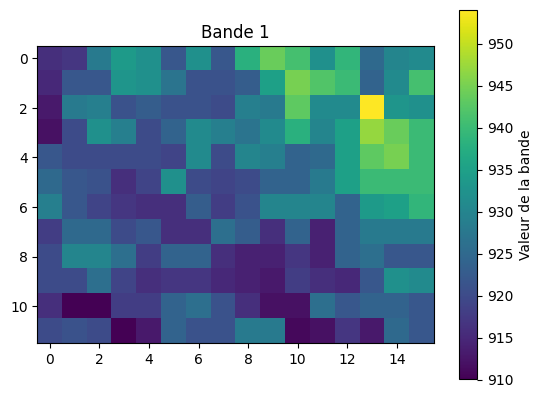

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que votre tableau NumPy se nomme image_array
# Affichez la première bande (indice 0)
plt.imshow(image_array[:, :, 11], cmap='viridis')
plt.title('Bande 1')
plt.colorbar(label='Valeur de la bande')
plt.show()

In [ ]:
sentinel2_dataset = SimpleRasterDataset(
    paths="../data/sentinel2_tiles_ee",
    all_bands=["blue", "green", "red", "nir", "swir1", "swir2", "ndvi", "ndwi", "evi"],
    transforms=None,
    crs="EPSG:4326"
)
point_geo_sampler = PointGeoSampler(
    sentinel2_dataset,
    processed_species_original_locations,
    side_length_meters=10000
)
print(f"Total points to sample: {len(point_geo_sampler)}")
queries = point_geo_sampler.get_all_queries()



Total points to sample: 24732


Sample shape: torch.Size([9, 333, 484])


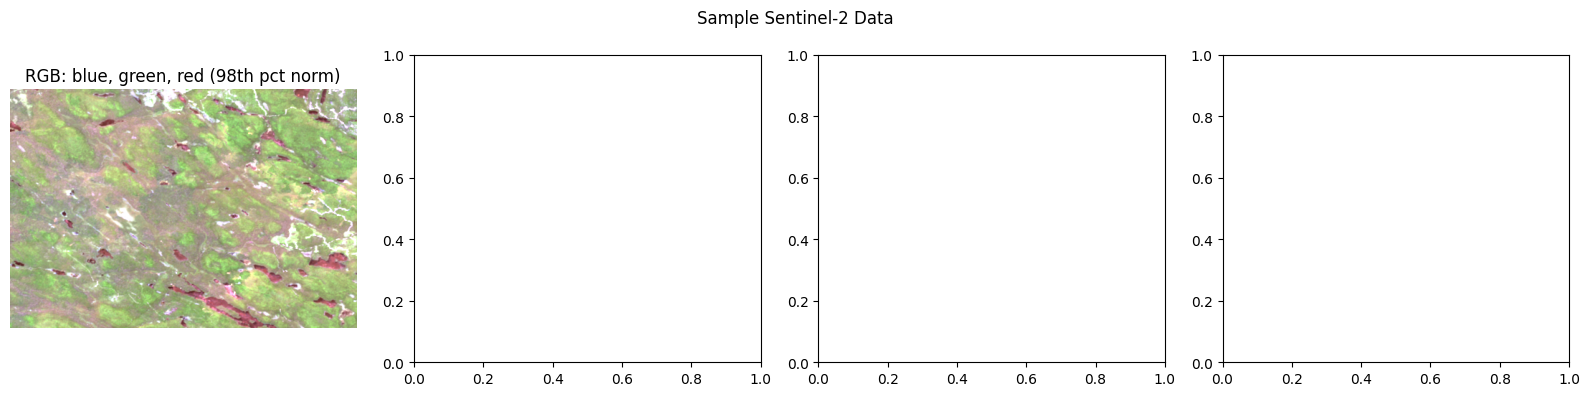

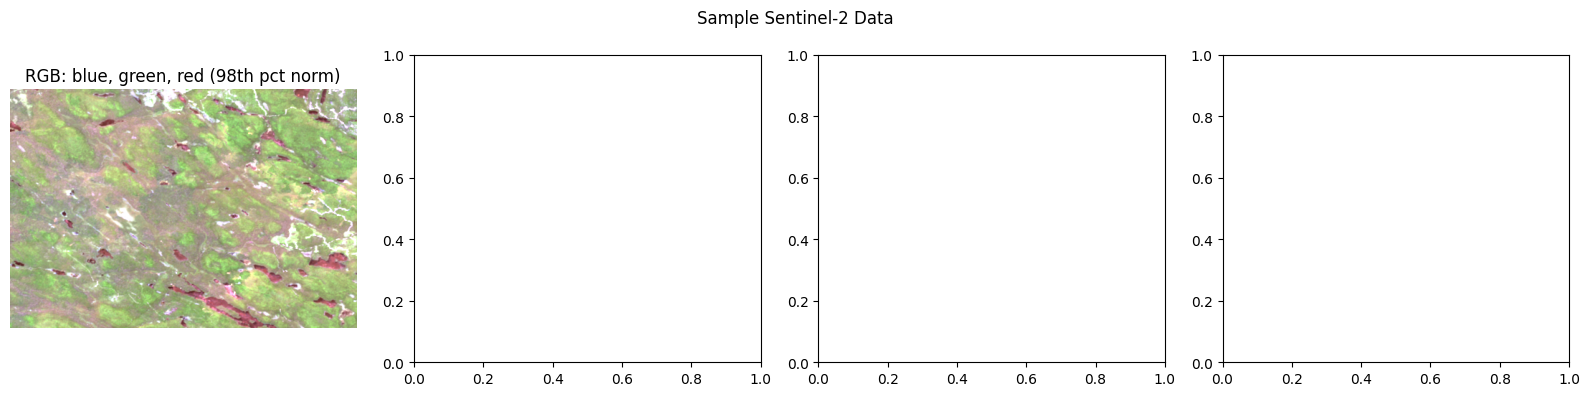

In [53]:
sample = sentinel2_dataset[queries[1]]
print(f"Sample shape: {sample['image'].shape}")
sentinel2_dataset.plot(sample, bands=["blue", "green", "red"], show_titles=True, suptitle="Sample Sentinel-2 Data")

Sample shape: torch.Size([9, 256, 256])


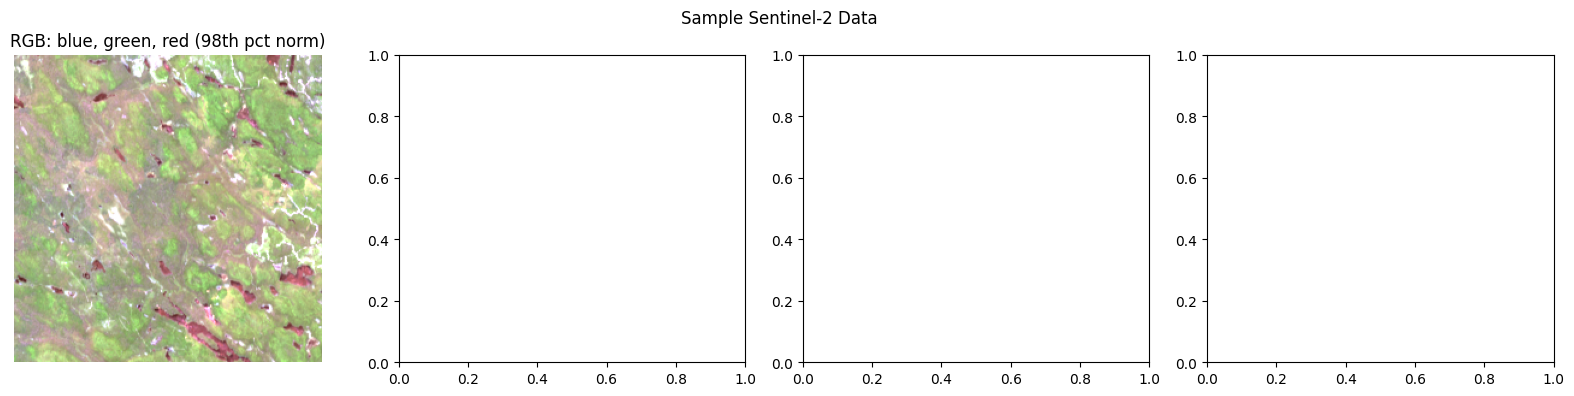

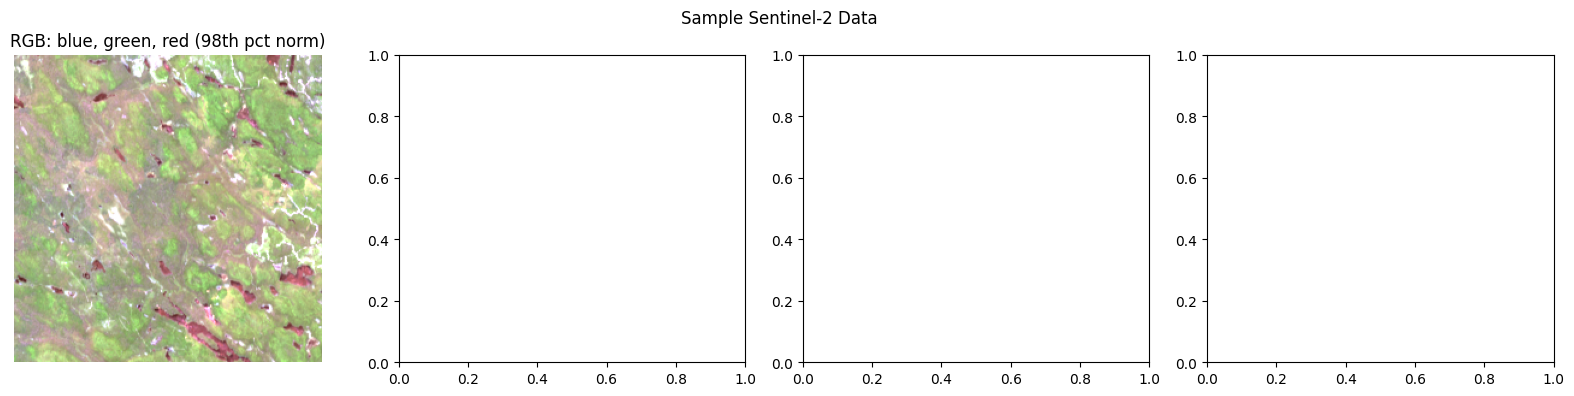

In [51]:
sample = sentinel2_dataset[queries[1]]
print(f"Sample shape: {sample['image'].shape}")
sentinel2_dataset.plot(sample, bands=["blue", "green", "red"], show_titles=True, suptitle="Sample Sentinel-2 Data")

In [75]:
sample = sentinel2_dataset[queries[1]]
sample['image'][0]

tensor([[0.0232, 0.0223, 0.0233,  ..., 0.0207, 0.0207, 0.0197],
        [0.0229, 0.0231, 0.0235,  ..., 0.0220, 0.0208, 0.0195],
        [0.0233, 0.0232, 0.0253,  ..., 0.0220, 0.0209, 0.0206],
        ...,
        [0.0231, 0.0230, 0.0232,  ..., 0.0200, 0.0204, 0.0245],
        [0.0226, 0.0212, 0.0212,  ..., 0.0197, 0.0204, 0.0236],
        [0.0244, 0.0251, 0.0245,  ..., 0.0188, 0.0198, 0.0196]])

In [1]:
import os
import numpy as np
import rasterio
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def _compute_min_max(file_path):
    """Read a multi-band raster and compute min/max per band."""
    try:
        with rasterio.open(file_path) as src:
            results = []
            for i in range(1, src.count + 1):  # 1-based index
                data = src.read(i)
                valid_stats = data[~np.isnan(data)]
                min_val = valid_stats.min() if valid_stats.size > 0 else None
                max_val = valid_stats.max() if valid_stats.size > 0 else None
                results.append((min_val, max_val))
            return results
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def compute_tile_min_max(folder_path, num_bands, num_workers=None):
    """
    Computes per-band min/max for all multi-band .tif tiles in a folder.
    Assumes each tile has `num_bands` stacked along axis 0.
    """
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)

    # List all tif files
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".tif")]

    print(f"Processing {len(all_files)} tiles with {num_workers} workers...")

    # Collect results
    band_results = [[] for _ in range(num_bands)]

    with Pool(num_workers) as pool:
        for r in tqdm(pool.imap_unordered(_compute_min_max, all_files), total=len(all_files)):
            if r is not None:
                for band_idx, (bmin, bmax) in enumerate(r):
                    band_results[band_idx].append((bmin, bmax))

    # Aggregate min/max across all tiles
    results = {}
    for band_idx in range(num_bands):
        if band_results[band_idx]:
            mins, maxs = zip(*band_results[band_idx])
            results[f"band_{band_idx+1}"] = {
                "min": np.min(mins),
                "max": np.max(maxs),
            }
        else:
            results[f"band_{band_idx+1}"] = {"min": None, "max": None}

    return results



In [18]:
sentinel2_dataset = CombinedBandsDataset(
    paths="../data/sentinel2_tiles_ee",
    all_bands=['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'],
    transforms=None
)

In [15]:

# Example usage
folder = sentinel2_dataset.paths
ALL_BANDS = sentinel2_dataset.all_bands  # or whatever you pass
band_stats = compute_tile_min_max(folder, len(ALL_BANDS))
print(band_stats)

Processing 116 tiles with 11 workers...


100%|██████████| 116/116 [01:35<00:00,  1.21it/s]

{'band_1': {'min': np.float32(0.0), 'max': np.float32(0.76985)}, 'band_2': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_3': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_4': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_5': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_6': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_7': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_8': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_9': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_10': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_11': {'min': np.float32(0.0), 'max': np.float32(1.0)}, 'band_12': {'min': np.float32(0.0), 'max': np.float32(1.0)}}


In [84]:
import os
import rasterio
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import traceback

def _normalize_tile(file_path, output_folder, band_stats, clip=True):
    """
    Normalizes a single raster tile (with stacked bands) using provided per-band min/max.
    Saves the normalized tile to output_folder.
    """
    try:
        basename = os.path.basename(file_path)

        with rasterio.open(file_path) as src:
            profile = src.profile
            data = src.read().astype(np.float32)  # shape = (bands, H, W)

            # Normalize each band
            for band_idx in range(data.shape[0]):
                band_key = f'band_{band_idx+1}'
                if band_key not in band_stats:
                    print(f"Skipping {band_key} in {basename}: no stats available")
                    continue

                min_val = band_stats[band_key]['min']
                max_val = band_stats[band_key]['max']

                if min_val is None or max_val is None:
                    print(f"Skipping {band_key} in {basename}: invalid stats")
                    continue

                # Clip + normalize
                band_data = data[band_idx]
                if clip:
                    band_data = np.clip(band_data, min_val, max_val)

                data[band_idx] = (band_data - min_val) / (max_val - min_val + 1e-6)

            # Update profile for float32 output
            profile.update(dtype=rasterio.float32, compress='lzw')

            # Save normalized tile
            out_path = os.path.join(output_folder, basename)
            os.makedirs(output_folder, exist_ok=True)
            with rasterio.open(out_path, 'w', **profile) as dst:
                dst.write(data)

    except Exception as e:
        print(f"Error normalizing {file_path}: {e}")
        # traceback.print_exc()


def normalize_tiles(folder_path, output_folder, band_stats, num_workers=None):
    """
    Normalizes all stacked .tif tiles in a folder using per-band stats.
    Saves normalized tiles to output_folder.
    """
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)

    # List all tif files
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".tif")]

    print(f"Normalizing {len(all_files)} tiles with {num_workers} workers...")

    args = [(f, output_folder, band_stats) for f in all_files]

    with Pool(num_workers) as pool:
        for _ in tqdm(pool.starmap(_normalize_tile, args), total=len(args)):
            pass


# Example usage
folder = "../data/sentinel2_tiles_ee"
output_folder = "../data/sentinel2_tiles_ee_normalized"

normalize_tiles(folder, output_folder, band_stats, num_workers=8)


Normalizing 118 tiles with 8 workers...


100%|██████████| 118/118 [00:00<00:00, 1846745.79it/s]


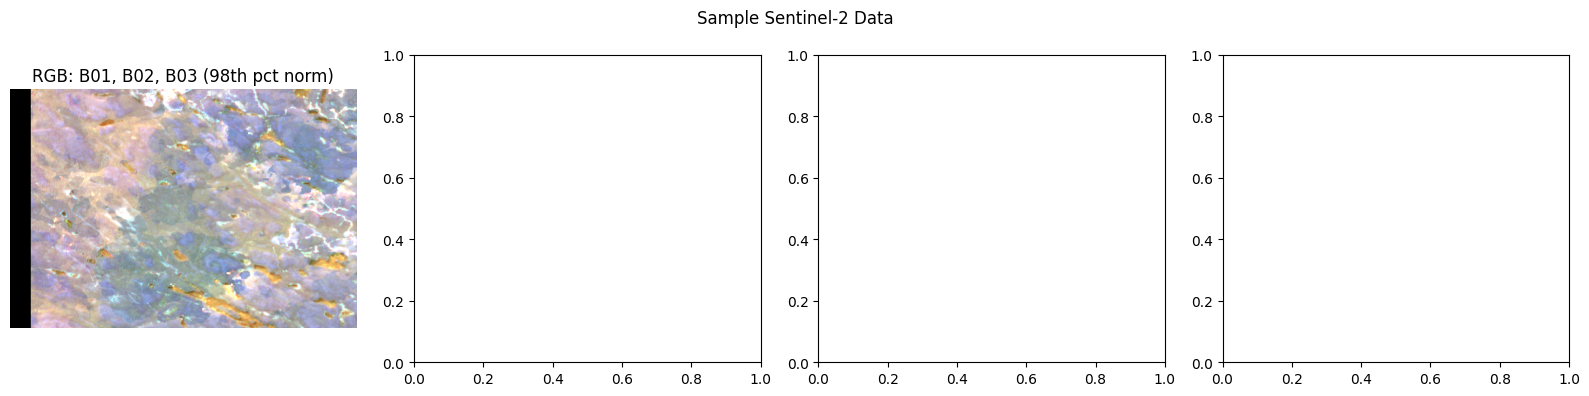

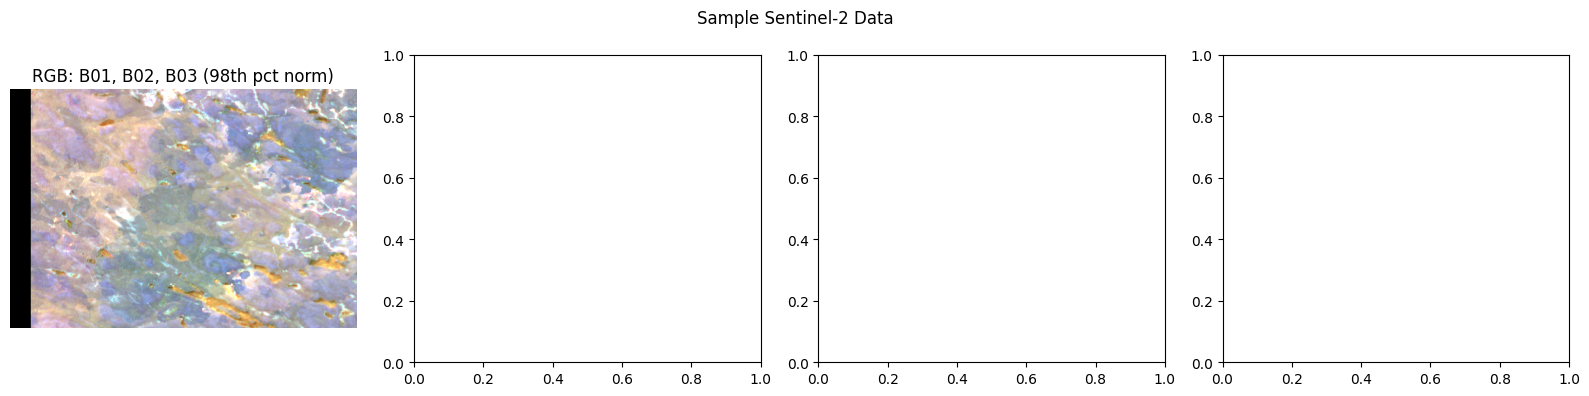

In [16]:
point_geo_sampler = PointGeoSampler(
    sentinel2_dataset,
    processed_species_original_locations,
    side_length_meters=10000
)

queries = point_geo_sampler.get_all_queries()

sample = sentinel2_dataset[queries[1]]
sentinel2_dataset.plot(sample, bands=["B01", "B02", "B03"], show_titles=True, suptitle="Sample Sentinel-2 Data")

In [67]:
sentinel2_dataset[queries[100]]['image'].shape

torch.Size([12, 333, 485])

In [ ]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm

# sentinel2_dataset = SimpleRasterDataset(
#     paths="../data/sentinel2_tiles_ee_normalized",
#     all_bands=["blue"],
#     transforms=None,
#     crs="EPSG:4326"
# )
# point_geo_sampler = PointGeoSampler(
#     sentinel2_dataset,
#     processed_species_original_locations,
#     side_length_meters=10000
# )
# queries = point_geo_sampler.get_all_queries()
# patch_shapes = []
# for idx in tqdm(range(len(queries))):
#     # get first band only
#     patch = sentinel2_dataset[queries[idx]]['image'][0]
#     patch_shapes.append(patch.shape)  # (height, width)

# # Compute min height and width
# heights, widths = zip(*patch_shapes)
# min_height = min(heights)
# min_width = min(widths)
# print(f"Minimum patch size across all locations: ({min_height}, {min_width})")


100%|██████████| 24960/24960 [06:39<00:00, 62.41it/s] 

Minimum patch size across all locations: (333, 471)


In [10]:
# Path to the output Zarr store
zarr_output_path = '../data/zarr_patches/pred100.zarr'
side_length_meters = 10000
locations = processed_species_original_locations.geometry
sentinel2_dataset = SimpleRasterDataset(
    paths="../data/sentinel2_tiles_ee_normalized",
    all_bands=["blue", "green", "red", "nir", "swir1", "swir2", "ndvi", "ndwi", "evi"],
    transforms=None,
    crs="EPSG:4326",
    target_size=256  # Resize patches to 256x256 pixels
)

# Now, call the optimized function with your data
extract_patches_sequentially(
    dataset=sentinel2_dataset,
    locations=locations,
    side_length_meters=side_length_meters,
    zarr_path=zarr_output_path,
    group_name="sentinel2",
    memory_threshold_mb=4096
)

First query: BoundingBox(minx=np.float64(-78.24934627240191), maxx=np.float64(-78.1189517275981), miny=np.float64(46.4105834412505), maxy=np.float64(46.500414558749604), mint=0.0, maxt=9.223372036854776e+18)
Dataset info:
  - separate_files: False
  - n_bands: 9
  - n_files: 118
  - patch_shape: (9, 256, 256)
Pre-allocating Zarr arrays...
Processing combined bands sequentially with async saving...


Processing patches (seq+async):   7%|▋         | 1817/24732 [00:27<06:23, 59.73it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  12%|█▏        | 2914/24732 [00:53<06:08, 59.29it/s]

Saved 1821 patches in 15.55s


Processing patches (seq+async):  15%|█▍        | 3635/24732 [01:04<04:26, 79.26it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  19%|█▉        | 4766/24732 [01:26<07:01, 47.39it/s]

Saved 1821 patches in 10.82s


Processing patches (seq+async):  22%|██▏       | 5459/24732 [01:36<04:09, 77.13it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  26%|██▋       | 6511/24732 [01:57<05:18, 57.28it/s]

Saved 1821 patches in 11.47s


Processing patches (seq+async):  29%|██▉       | 7279/24732 [02:10<05:12, 55.80it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  33%|███▎      | 8265/24732 [02:32<05:05, 53.93it/s]

Saved 1821 patches in 11.17s


Processing patches (seq+async):  37%|███▋      | 9100/24732 [02:44<04:49, 53.91it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  40%|███▉      | 9846/24732 [03:07<07:09, 34.70it/s]  

Saved 1821 patches in 11.10s


Processing patches (seq+async):  44%|████▍     | 10925/24732 [03:27<03:52, 59.44it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  48%|████▊     | 11775/24732 [03:48<04:30, 47.95it/s]

Saved 1821 patches in 10.95s


Processing patches (seq+async):  52%|█████▏    | 12744/24732 [04:08<03:35, 55.67it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  55%|█████▌    | 13614/24732 [04:28<03:19, 55.60it/s]

Saved 1821 patches in 11.19s


Processing patches (seq+async):  59%|█████▉    | 14567/24732 [04:44<02:11, 77.25it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  63%|██████▎   | 15510/24732 [05:05<02:54, 52.86it/s]

Saved 1821 patches in 11.03s


Processing patches (seq+async):  66%|██████▋   | 16388/24732 [05:22<03:06, 44.68it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  69%|██████▉   | 17041/24732 [05:43<02:59, 42.83it/s]

Saved 1821 patches in 10.86s


Processing patches (seq+async):  74%|███████▎  | 18204/24732 [06:07<01:50, 58.91it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  76%|███████▋  | 18912/24732 [06:37<01:46, 54.61it/s]

Saved 1821 patches in 19.47s


Processing patches (seq+async):  81%|████████  | 20024/24732 [06:53<01:07, 70.11it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  85%|████████▌ | 21098/24732 [07:14<01:06, 54.57it/s]

Saved 1821 patches in 11.30s


Processing patches (seq+async):  88%|████████▊ | 21850/24732 [07:25<00:36, 79.36it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  93%|█████████▎| 23093/24732 [07:46<00:21, 76.25it/s]

Saved 1821 patches in 11.18s


Processing patches (seq+async):  96%|█████████▌| 23672/24732 [07:54<00:15, 70.24it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async): 100%|██████████| 24732/24732 [08:14<00:00, 50.03it/s]

Saved 1821 patches in 11.80s


Queueing final batch (~2382.75 MB) for saving...
Saved 1059 patches in 5.77s
Extraction complete in 506.25s
Patches saved at ../data/zarr_patches/pred100.zarr


### Extracting the location data


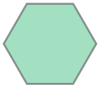

In [54]:
# create an hexagon around a location
import geopandas as gpd
from shapely.geometry import Polygon


def create_hexagon(center, square_meters):
    """
    Create a hexagon polygon around a center point with a specified area in square meters.
    
    Parameters:
    - center (tuple): (x, y) coordinates of the hexagon's center.
    - square_meters (float): Desired area of the hexagon in square meters.
    
    Returns:
    - Polygon: A shapely Polygon object representing the hexagon.
    
    Raises:
    - ValueError: If square_meters is non-positive.
    """
    if square_meters <= 0:
        raise ValueError("Area must be positive.")
    
    # Calculate radius for a regular hexagon with given area
    # Area = (3 * sqrt(3) / 2) * r^2
    radius = np.sqrt((2 * square_meters) / (3 * np.sqrt(3)))
    
    # Generate angles for 6 vertices plus closing point
    angle = np.linspace(0, 2 * np.pi, 7)
    
    # Calculate x, y coordinates of vertices
    x = center[0] + radius * np.cos(angle)
    y = center[1] + radius * np.sin(angle)
    
    # Create and return the Polygon
    return Polygon(zip(x, y))
create_hexagon(processed_species_original_locations.geometry.iloc[0].coords[0], 307.092)#same area as h3 at resolution 12

In [9]:
import os
import numpy as np
import rasterio
import pandas as pd
from shapely.geometry import Point
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def _raster_at_points_worker(args):
    """Worker to extract raster values at a set of points."""
    raster_path, points = args
    values = []
    with rasterio.open(raster_path) as src:
        coords = [(pt.x, pt.y) for pt in points]
        for val in src.sample(coords):
            value = val[0]
            if src.nodata is not None and value == src.nodata:
                values.append(None)
            elif np.isnan(value):
                values.append(None)
            else:
                values.append(float(value))
    return values

def raster_values_at_points_parallel(raster_path, points, n_jobs=None):
    """
    Extract raster values at points using multiprocessing (no chunking).
    Each worker opens the raster and samples the *full point set*.
    
    Parameters
    ----------
    raster_path : str
        Path to the raster file.
    points : list of shapely.geometry.Point
        Points in same CRS as raster.
    n_jobs : int, optional
        Number of processes (default: cpu_count()).
    
    Returns
    -------
    list of float or None
        Raster values at each point.
    """
    if n_jobs is None:
        n_jobs = cpu_count()

    # just one worker in this case would be same speed,
    # but we allow multiple in case you want per-raster parallelism
    args = [(raster_path, points)]
    with Pool(processes=n_jobs) as pool:
        results = list(tqdm(pool.imap(_raster_at_points_worker, args),
                            total=len(args), desc="Sampling points"))
    return results[0]

def raster_values_from_folder(raster_folder, points, n_jobs=None):
    """
    Extract raster values at points for all .tif files in a folder.
    Returns a DataFrame with one column per raster.
    """
    tif_files = [f for f in os.listdir(raster_folder) if f.endswith(".tif")]
    tif_files.sort()

    results = {}
    for fname in tif_files:
        raster_path = os.path.join(raster_folder, fname)
        print(f"Extracting values from {fname} ...")
        vals = raster_values_at_points_parallel(raster_path, points, n_jobs=n_jobs)
        band_name = os.path.splitext(fname)[0]  # drop .tif
        results[band_name] = vals

    return pd.DataFrame(results)

points = processed_species_original_locations.geometry.apply(lambda geom: Point(geom.x, geom.y))
raster_folder = "../data/data_layers/predictors_100_QC_normalized"
raster_values_df = raster_values_from_folder(raster_folder, points, n_jobs=6)

Extracting values from alluvion.tif ...


Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

Extracting values from annual_precipitation_amount.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Extracting values from annual_range_of_air_temperature.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Extracting values from barren.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from bulk_density.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Extracting values from clay.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Extracting values from combined_mask.tif ...



Sampling points: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

Extracting values from coniferous.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Extracting values from cropland.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from deciduous.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Extracting values from depot.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Extracting values from distance_to_roads.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

Extracting values from eau_peu_profonde.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Extracting values from elevation.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Extracting values from eolien.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from geomflat.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Extracting values from geomfootslope.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Extracting values from glaciaire.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from glaciolacustre.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from human_modification.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Extracting values from indifferencie.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Extracting values from isothermality.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Extracting values from lacustre.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from lai.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Extracting values from marais.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Extracting values from marecage.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Extracting values from mean_annual_air_temperature.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Extracting values from mean_daily_maximum_air_temperature_of_the_warmest_month.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Extracting values from mean_daily_mean_air_temperatures_of_the_coldest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Extracting values from mean_daily_mean_air_temperatures_of_the_driest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Extracting values from mean_daily_mean_air_temperatures_of_the_warmest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Extracting values from mean_daily_mean_air_temperatures_of_the_wettest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Extracting values from mean_daily_minimum_air_temperature_of_the_coldest_month.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Extracting values from mean_diurnal_air_temperature_range.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Extracting values from mean_monthly_precipitation_amount_of_the_coldest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Extracting values from mean_monthly_precipitation_amount_of_the_driest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Extracting values from mean_monthly_precipitation_amount_of_the_warmest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Extracting values from mean_monthly_precipitation_amount_of_the_wettest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Extracting values from mixed.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Extracting values from ndvi.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Extracting values from nitrogen.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Extracting values from organic_carbon_density.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from organique.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from ph.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Extracting values from polar_grass.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from prairie_humide.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Extracting values from precipitation_amount_of_the_driest_month.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Extracting values from precipitation_amount_of_the_wettest_month.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Extracting values from precipitation_seasonality.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Extracting values from quaternaire.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Extracting values from roche.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Extracting values from ruggedness.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Extracting values from sand.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Extracting values from silt.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from soil_organic_carbon.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Extracting values from taiga.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Extracting values from temperate_grass.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Extracting values from temperate_shrub.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Extracting values from temperature_seasonality.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Extracting values from till.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Extracting values from tourbiere_boisee.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Extracting values from tourbiere_indifferenciee.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Extracting values from tourbiere_minerotrophe.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Extracting values from tourbiere_ombrotrophe.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from urban.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from water.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Extracting values from wetland.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


In [12]:
processed_species_original_locations_point_data = processed_species_original_locations.copy()
processed_species_original_locations_point_data = processed_species_original_locations_point_data.reset_index(drop=True)
processed_species_original_locations_point_data = pd.concat([processed_species_original_locations_point_data, raster_values_df], axis=1)
processed_species_original_locations_point_data.drop(columns=['species_count', 'id', 'expanded_cells'], inplace=True)  # remove geometry column
processed_species_original_locations_point_data.to_csv("../data/saved_df/processed_species_original_locations_point_data.csv", index=False)

In [11]:
def create_target_species_df(species_name, df):
    df_present = df[['species_list', 'geometry']].copy()
    # Use single brackets to get the Series and apply to each list directly
    df_present[species_name] = df_present['species_list'].apply(lambda x: 1 if species_name in x else 0)
    return df_present[species_name]

In [18]:
target_df = create_target_species_df("ERP", processed_species_original_locations_point_data)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def feature_importance_from_stats(stats_list, target_df, threshold=0.01):
    """
    Train RandomForest on zonal stats to predict binary target,
    return feature importances and model performance.
    
    Parameters
    ----------
    stats_list : list of dict
        Output from zonal_stats_simple
    target_df : pd.DataFrame
        Must contain a column 'target' with 0/1 values,
        same length/order as stats_list
    
    Returns
    -------
    feature_importances : pd.Series
    model : trained RandomForestClassifier
    """
    # Convert stats list to DataFrame
    X = pd.DataFrame(stats_list)
    
    # Align with target
    X["target"] = target_df.values
    y = X.pop("target")
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Model
    model = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    )
    model.fit(X_train, y_train)
    
    # Feature importances
    feature_importances = pd.Series(
        model.feature_importances_, index=X.columns
    ).sort_values(ascending=False)

    # Apply threshold
    feature_importances = feature_importances[feature_importances > threshold]
    return feature_importances


In [30]:
feature_importance = feature_importance_from_stats(
    processed_species_original_locations_point_data.drop(columns=['species_list', 'geometry']),
    target_df=target_df,
    threshold=0.01
)

### Extracting into a npy file

In [41]:
import os
import numpy as np
from tqdm import tqdm
import rasterio
from rasterio.windows import from_bounds
from torchgeo.datasets import RasterDataset
import geopandas as gpd

def extract_patches_to_npy(
    dataset: RasterDataset,
    locations: gpd.GeoSeries,
    output_file: str,
    side_length_meters: float,
    target_shape: tuple = None,
    channel_min: list = None,
    channel_max: list = None
):
    """
    Extract patches from a RasterDataset and save to .npy file as uint8.
    Uses memmap during creation but saves metadata for easy loading.
    
    Parameters
    ----------
    dataset : RasterDataset
        TorchGeo dataset.
    locations : gpd.GeoSeries
        Point geometries.
    output_file : str
        Path to output .npy file.
    side_length_meters : float
        Patch size.
    target_shape : tuple, optional
        Target (height, width) for all patches. If None, uses first sample's shape.
        All patches will be cropped/padded to this size.
    channel_min, channel_max : list, optional
        Per-band normalization.
    """
    # Sampler
    point_geo_sampler = PointGeoSampler(
        dataset=dataset,
        locations=locations,
        side_length_meters=side_length_meters
    )
    queries = point_geo_sampler.get_all_queries()
    n_patches = len(queries)

    # Determine patch dimensions
    first_sample = dataset[queries[0]]
    first_patch = first_sample['image'].numpy()
    
    # Define band selection
    band_indices = [3, 2, 1, 4, 5, 6, 7, 10, 11]
    
    if dataset.separate_files:
        n_bands = len(dataset.files)
        if target_shape is not None:
            patch_height, patch_width = target_shape
        else:
            patch_height, patch_width = first_patch.shape[-2:]
    else:
        # FIXED: Update n_bands after band selection
        n_bands = len(band_indices)  # This should be 9, not the original band count
        if target_shape is not None:
            patch_height, patch_width = target_shape
        else:
            _, patch_height, patch_width = first_patch.shape

    print(f"Patches: {n_patches}, Bands: {n_bands}, Target patch shape: ({patch_height}, {patch_width})")
    if target_shape is not None:
        print(f"Using custom target shape: {target_shape}")

    # Create temporary memmap for float32 processing
    temp_file = output_file.replace('.npy', '_temp.npy')
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    all_patches = np.memmap(temp_file, dtype=np.float32, mode='w+',
                            shape=(n_patches, n_bands, patch_height, patch_width))

    if dataset.separate_files:
        # Open each band file once and extract all patches sequentially
        for b_idx, filepath in enumerate(dataset.files):
            print(f"Processing band {b_idx+1}/{n_bands}: {filepath}")
            with rasterio.open(filepath) as src:
                for i, query_bbox in enumerate(tqdm(queries, desc=f"Band {b_idx+1}")):
                    try:
                        window = from_bounds(
                            query_bbox.minx, query_bbox.miny,
                            query_bbox.maxx, query_bbox.maxy,
                            src.transform
                        )
                        patch = src.read(window=window).squeeze().astype(np.float32)

                        # Normalize to [0,1]
                        if channel_min and channel_max:
                            min_val = channel_min[b_idx]
                            max_val = channel_max[b_idx]
                            if max_val > min_val:
                                patch = np.clip((patch - min_val)/(max_val-min_val), 0, 1)

                        all_patches[i, b_idx] = patch
                    except Exception as e:
                        print(f"Error patch {i}, band {b_idx}: {e}")
                        all_patches[i, b_idx] = 0
    else:
        # Combined bands
        for i, query_bbox in enumerate(tqdm(queries, desc="Extracting patches")):
            try:
                sample = dataset[query_bbox]
                patch = sample['image'].numpy().astype(np.float32)
                
                # Select bands
                patch = patch[band_indices, :, :]
                
                # FIXED: Use the correct n_bands (9) for normalization
                # Normalize to [0,1]
                if channel_min and channel_max:
                    for b in range(n_bands):  # Now correctly uses 9 instead of 12
                        min_val, max_val = channel_min[b], channel_max[b]
                        if max_val > min_val:
                            patch[b] = np.clip((patch[b]-min_val)/(max_val-min_val), 0, 1)

                # Handle variable patch sizes by center cropping/padding to target dimensions
                if patch.shape != (n_bands, patch_height, patch_width):
                    processed_patch = np.zeros((n_bands, patch_height, patch_width), dtype=np.float32)
                    
                    for b in range(n_bands):
                        band_data = patch[b]
                        processed_patch[b] = crop_or_pad_to_size(band_data, patch_height, patch_width)
                    
                    patch = processed_patch

                all_patches[i] = patch
            except Exception as e:
                print(f"Error patch {i}: {e}")
                all_patches[i] = 0

    # Convert to uint8 in chunks to avoid memory issues
    print("Converting to uint8 and saving...")
    
    # Create final uint8 memmap
    uint8_patches = np.memmap(output_file, dtype=np.uint8, mode='w+',
                             shape=(n_patches, n_bands, patch_height, patch_width))
    
    # Convert in chunks
    chunk_size = 1000  # Adjust based on your RAM
    for i in tqdm(range(0, n_patches, chunk_size), desc="Converting to uint8"):
        end_idx = min(i + chunk_size, n_patches)
        chunk = all_patches[i:end_idx]
        uint8_patches[i:end_idx] = (chunk * 255).astype(np.uint8)
    
    # Flush and cleanup
    uint8_patches.flush()
    del all_patches, uint8_patches
    
    # Remove temporary file
    os.remove(temp_file)
    
    # Save metadata for easy loading
    metadata = {
        'shape': (n_patches, n_bands, patch_height, patch_width),
        'dtype': 'uint8',
        'description': 'Patches stored as uint8 [0,255], original range [0,1]'
    }
    
    metadata_file = output_file.replace('.npy', '_metadata.json')
    import json
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"All patches saved to {output_file} as uint8")
    print(f"Metadata saved to {metadata_file}")
    print(f"To load: data = load_patches('{output_file}')")

def crop_or_pad_to_size(patch, target_h, target_w):
    """
    Crop or pad a 2D patch to target size using center crop and zero padding
    
    Parameters
    ----------
    patch : np.ndarray
        2D array to resize
    target_h, target_w : int
        Target height and width
        
    Returns
    -------
    np.ndarray
        Resized patch
    """
    h, w = patch.shape
    
    # Center crop if larger than target
    if h > target_h or w > target_w:
        h_start = max(0, (h - target_h) // 2)
        w_start = max(0, (w - target_w) // 2)
        h_end = min(h, h_start + target_h)
        w_end = min(w, w_start + target_w)
        patch = patch[h_start:h_end, w_start:w_end]
        h, w = patch.shape
    
    # Pad if smaller than target
    if h < target_h or w < target_w:
        padded = np.zeros((target_h, target_w), dtype=patch.dtype)
        h_offset = (target_h - h) // 2
        w_offset = (target_w - w) // 2
        padded[h_offset:h_offset+h, w_offset:w_offset+w] = patch
        patch = padded
    
    return patch

def load_patches(npy_file, as_float=True, mmap_mode='r'):
    """
    Load uint8 patches with automatic shape detection.
    
    Parameters
    ----------
    npy_file : str
        Path to .npy file
    as_float : bool
        If True, convert to float32 [0,1]. If False, keep as uint8 [0,255]
    mmap_mode : str
        Memory mapping mode ('r', 'r+', None)
    
    Returns
    -------
    np.ndarray
        Loaded patches
    """
    # Try to load metadata first
    metadata_file = npy_file.replace('.npy', '_metadata.json')
    if os.path.exists(metadata_file):
        import json
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        # Load with known shape
        data = np.memmap(npy_file, dtype=np.uint8, mode=mmap_mode, 
                        shape=tuple(metadata['shape']))
        print(f"Loaded with shape: {metadata['shape']}")
    else:
        # Fallback: try to infer or load normally
        try:
            # This might work if numpy can infer the shape
            data = np.load(npy_file, mmap_mode=mmap_mode)
        except:
            raise ValueError(f"Cannot determine shape. Please provide metadata file: {metadata_file}")
    
    if as_float:
        if mmap_mode is None:
            # Load into memory and convert
            return data.astype(np.float32) / 255.0
        else:
            # Return a view that converts on access (memory efficient)
            class Float32View:
                def __init__(self, uint8_data):
                    self._data = uint8_data
                    self.shape = uint8_data.shape
                    self.dtype = np.float32
                
                def __getitem__(self, key):
                    return self._data[key].astype(np.float32) / 255.0
                
                def __array__(self):
                    return self._data.astype(np.float32) / 255.0
            
            return Float32View(data)
    
    return data, metadata['shape']

In [33]:
patches, shape = load_patches('../data/npy_data/pred100_patches.npy', as_float=False, mmap_mode='r')

Loaded with shape: [24732, 67, 100, 100]


In [ ]:
pred100_raster_names = get_raster_as_bands("../data/data_layers/predictors_100_QC_normalized")
# Your raster dataset instance
# pred_100_dataset = MyCustomRasterDataset("../data/data_layers/predictors_100_QC_normalized", 
#                                          all_bands=pred100_raster_names, 
#                                          separate_files=True,
#                                          #resolution=(100, 100),
#                                         )

pred_100_point_geo_sampler = PointGeoSampler(
    dataset=pred_100_dataset,
    locations=processed_species_original_locations,
    side_length_meters=10000  # 10 km
)
queries = pred_100_point_geo_sampler.get_all_queries()
output_file = "../data/npy_data/pred100_patches.npy"
side_length_meters = 10000  # 10 km
locations = processed_species_original_locations.geometry

extract_patches_to_npy(
    dataset=pred_100_dataset,
    locations=locations,
    output_file=output_file,
    side_length_meters=side_length_meters
)

Pred100 raster names: ('alluvion', 'annual_precipitation_amount', 'annual_range_of_air_temperature', 'barren', 'bulk_density', 'clay', 'combined_mask', 'coniferous', 'cropland', 'deciduous', 'depot', 'distance_to_roads', 'eau_peu_profonde', 'elevation', 'eolien', 'geomflat', 'geomfootslope', 'glaciaire', 'glaciolacustre', 'human_modification', 'indifferencie', 'isothermality', 'lacustre', 'lai', 'marais', 'marecage', 'mean_annual_air_temperature', 'mean_daily_maximum_air_temperature_of_the_warmest_month', 'mean_daily_mean_air_temperatures_of_the_coldest_quarter', 'mean_daily_mean_air_temperatures_of_the_driest_quarter', 'mean_daily_mean_air_temperatures_of_the_warmest_quarter', 'mean_daily_mean_air_temperatures_of_the_wettest_quarter', 'mean_daily_minimum_air_temperature_of_the_coldest_month', 'mean_diurnal_air_temperature_range', 'mean_monthly_precipitation_amount_of_the_coldest_quarter', 'mean_monthly_precipitation_amount_of_the_driest_quarter', 'mean_monthly_precipitation_amount_of_

Band 1: 100%|██████████| 24732/24732 [00:05<00:00, 4722.08it/s]


Processing band 2/67: ../data/data_layers/predictors_100_QC_normalized/annual_precipitation_amount.tif


Band 2: 100%|██████████| 24732/24732 [00:04<00:00, 5425.05it/s]


Processing band 3/67: ../data/data_layers/predictors_100_QC_normalized/annual_range_of_air_temperature.tif


Band 3: 100%|██████████| 24732/24732 [00:03<00:00, 6518.86it/s]


Processing band 4/67: ../data/data_layers/predictors_100_QC_normalized/barren.tif


Band 4: 100%|██████████| 24732/24732 [00:03<00:00, 6434.98it/s]


Processing band 5/67: ../data/data_layers/predictors_100_QC_normalized/bulk_density.tif


Band 5: 100%|██████████| 24732/24732 [00:05<00:00, 4938.54it/s]


Processing band 6/67: ../data/data_layers/predictors_100_QC_normalized/clay.tif


Band 6: 100%|██████████| 24732/24732 [00:03<00:00, 6329.86it/s]


Processing band 7/67: ../data/data_layers/predictors_100_QC_normalized/combined_mask.tif


Band 7: 100%|██████████| 24732/24732 [00:03<00:00, 8117.91it/s]


Processing band 8/67: ../data/data_layers/predictors_100_QC_normalized/coniferous.tif


Band 8: 100%|██████████| 24732/24732 [00:04<00:00, 5444.21it/s]


Processing band 9/67: ../data/data_layers/predictors_100_QC_normalized/cropland.tif


Band 9: 100%|██████████| 24732/24732 [00:04<00:00, 5388.61it/s]


Processing band 10/67: ../data/data_layers/predictors_100_QC_normalized/deciduous.tif


Band 10: 100%|██████████| 24732/24732 [00:03<00:00, 6977.09it/s]


Processing band 11/67: ../data/data_layers/predictors_100_QC_normalized/depot.tif


Band 11: 100%|██████████| 24732/24732 [00:03<00:00, 6671.12it/s]


Processing band 12/67: ../data/data_layers/predictors_100_QC_normalized/distance_to_roads.tif


Band 12: 100%|██████████| 24732/24732 [00:06<00:00, 4024.68it/s]


Processing band 13/67: ../data/data_layers/predictors_100_QC_normalized/eau_peu_profonde.tif


Band 13: 100%|██████████| 24732/24732 [00:03<00:00, 7134.08it/s]


Processing band 14/67: ../data/data_layers/predictors_100_QC_normalized/elevation.tif


Band 14: 100%|██████████| 24732/24732 [00:03<00:00, 6857.16it/s]


Processing band 15/67: ../data/data_layers/predictors_100_QC_normalized/eolien.tif


Band 15: 100%|██████████| 24732/24732 [00:04<00:00, 5311.95it/s]


Processing band 16/67: ../data/data_layers/predictors_100_QC_normalized/geomflat.tif


Band 16: 100%|██████████| 24732/24732 [00:03<00:00, 6778.04it/s]


Processing band 17/67: ../data/data_layers/predictors_100_QC_normalized/geomfootslope.tif


Band 17: 100%|██████████| 24732/24732 [00:03<00:00, 6721.53it/s]


Processing band 18/67: ../data/data_layers/predictors_100_QC_normalized/glaciaire.tif


Band 18: 100%|██████████| 24732/24732 [00:04<00:00, 5155.07it/s]


Processing band 19/67: ../data/data_layers/predictors_100_QC_normalized/glaciolacustre.tif


Band 19: 100%|██████████| 24732/24732 [00:03<00:00, 6664.01it/s]


Processing band 20/67: ../data/data_layers/predictors_100_QC_normalized/human_modification.tif


Band 20: 100%|██████████| 24732/24732 [00:03<00:00, 7180.09it/s]


Processing band 21/67: ../data/data_layers/predictors_100_QC_normalized/indifferencie.tif


Band 21: 100%|██████████| 24732/24732 [00:03<00:00, 6884.29it/s]


Processing band 22/67: ../data/data_layers/predictors_100_QC_normalized/isothermality.tif


Band 22: 100%|██████████| 24732/24732 [00:05<00:00, 4885.19it/s]


Processing band 23/67: ../data/data_layers/predictors_100_QC_normalized/lacustre.tif


Band 23: 100%|██████████| 24732/24732 [00:03<00:00, 6278.46it/s]


Processing band 24/67: ../data/data_layers/predictors_100_QC_normalized/lai.tif


Band 24: 100%|██████████| 24732/24732 [00:03<00:00, 6593.52it/s]


Processing band 25/67: ../data/data_layers/predictors_100_QC_normalized/marais.tif


Band 25: 100%|██████████| 24732/24732 [00:04<00:00, 5166.01it/s]


Processing band 26/67: ../data/data_layers/predictors_100_QC_normalized/marecage.tif


Band 26: 100%|██████████| 24732/24732 [00:03<00:00, 6333.16it/s]


Processing band 27/67: ../data/data_layers/predictors_100_QC_normalized/mean_annual_air_temperature.tif


Band 27: 100%|██████████| 24732/24732 [00:03<00:00, 6590.88it/s]


Processing band 28/67: ../data/data_layers/predictors_100_QC_normalized/mean_daily_maximum_air_temperature_of_the_warmest_month.tif


Band 28: 100%|██████████| 24732/24732 [00:04<00:00, 5553.23it/s]


Processing band 29/67: ../data/data_layers/predictors_100_QC_normalized/mean_daily_mean_air_temperatures_of_the_coldest_quarter.tif


Band 29: 100%|██████████| 24732/24732 [00:03<00:00, 7469.90it/s]


Processing band 30/67: ../data/data_layers/predictors_100_QC_normalized/mean_daily_mean_air_temperatures_of_the_driest_quarter.tif


Band 30: 100%|██████████| 24732/24732 [00:03<00:00, 7126.44it/s]


Processing band 31/67: ../data/data_layers/predictors_100_QC_normalized/mean_daily_mean_air_temperatures_of_the_warmest_quarter.tif


Band 31: 100%|██████████| 24732/24732 [00:03<00:00, 6824.86it/s]


Processing band 32/67: ../data/data_layers/predictors_100_QC_normalized/mean_daily_mean_air_temperatures_of_the_wettest_quarter.tif


Band 32: 100%|██████████| 24732/24732 [00:04<00:00, 5309.98it/s]


Processing band 33/67: ../data/data_layers/predictors_100_QC_normalized/mean_daily_minimum_air_temperature_of_the_coldest_month.tif


Band 33: 100%|██████████| 24732/24732 [00:03<00:00, 7170.25it/s]


Processing band 34/67: ../data/data_layers/predictors_100_QC_normalized/mean_diurnal_air_temperature_range.tif


Band 34: 100%|██████████| 24732/24732 [00:03<00:00, 6195.63it/s]


Processing band 35/67: ../data/data_layers/predictors_100_QC_normalized/mean_monthly_precipitation_amount_of_the_coldest_quarter.tif


Band 35: 100%|██████████| 24732/24732 [00:11<00:00, 2229.63it/s]


Processing band 36/67: ../data/data_layers/predictors_100_QC_normalized/mean_monthly_precipitation_amount_of_the_driest_quarter.tif


Band 36: 100%|██████████| 24732/24732 [00:05<00:00, 4428.34it/s]


Processing band 37/67: ../data/data_layers/predictors_100_QC_normalized/mean_monthly_precipitation_amount_of_the_warmest_quarter.tif


Band 37: 100%|██████████| 24732/24732 [00:05<00:00, 4526.10it/s]


Processing band 38/67: ../data/data_layers/predictors_100_QC_normalized/mean_monthly_precipitation_amount_of_the_wettest_quarter.tif


Band 38: 100%|██████████| 24732/24732 [00:21<00:00, 1128.70it/s]


Processing band 39/67: ../data/data_layers/predictors_100_QC_normalized/mixed.tif


Band 39: 100%|██████████| 24732/24732 [00:03<00:00, 6489.87it/s]


Processing band 40/67: ../data/data_layers/predictors_100_QC_normalized/ndvi.tif


Band 40: 100%|██████████| 24732/24732 [00:03<00:00, 7027.12it/s]


Processing band 41/67: ../data/data_layers/predictors_100_QC_normalized/nitrogen.tif


Band 41: 100%|██████████| 24732/24732 [00:04<00:00, 5040.07it/s]


Processing band 42/67: ../data/data_layers/predictors_100_QC_normalized/organic_carbon_density.tif


Band 42: 100%|██████████| 24732/24732 [00:06<00:00, 3753.85it/s]


Processing band 43/67: ../data/data_layers/predictors_100_QC_normalized/organique.tif


Band 43: 100%|██████████| 24732/24732 [00:04<00:00, 5700.34it/s]


Processing band 44/67: ../data/data_layers/predictors_100_QC_normalized/ph.tif


Band 44: 100%|██████████| 24732/24732 [00:07<00:00, 3394.46it/s]


Processing band 45/67: ../data/data_layers/predictors_100_QC_normalized/polar_grass.tif


Band 45: 100%|██████████| 24732/24732 [00:09<00:00, 2699.46it/s]


Processing band 46/67: ../data/data_layers/predictors_100_QC_normalized/prairie_humide.tif


Band 46: 100%|██████████| 24732/24732 [00:11<00:00, 2123.30it/s]


Processing band 47/67: ../data/data_layers/predictors_100_QC_normalized/precipitation_amount_of_the_driest_month.tif


Band 47: 100%|██████████| 24732/24732 [00:16<00:00, 1501.54it/s]


Processing band 48/67: ../data/data_layers/predictors_100_QC_normalized/precipitation_amount_of_the_wettest_month.tif


Band 48: 100%|██████████| 24732/24732 [00:09<00:00, 2511.76it/s]


Processing band 49/67: ../data/data_layers/predictors_100_QC_normalized/precipitation_seasonality.tif


Band 49: 100%|██████████| 24732/24732 [00:09<00:00, 2688.28it/s]


Processing band 50/67: ../data/data_layers/predictors_100_QC_normalized/quaternaire.tif


Band 50: 100%|██████████| 24732/24732 [00:07<00:00, 3277.35it/s]


Processing band 51/67: ../data/data_layers/predictors_100_QC_normalized/roche.tif


Band 51: 100%|██████████| 24732/24732 [00:11<00:00, 2156.69it/s]


Processing band 52/67: ../data/data_layers/predictors_100_QC_normalized/ruggedness.tif


Band 52: 100%|██████████| 24732/24732 [00:06<00:00, 3614.43it/s]


Processing band 53/67: ../data/data_layers/predictors_100_QC_normalized/sand.tif


Band 53: 100%|██████████| 24732/24732 [00:13<00:00, 1845.20it/s]


Processing band 54/67: ../data/data_layers/predictors_100_QC_normalized/silt.tif


Band 54: 100%|██████████| 24732/24732 [00:08<00:00, 3037.94it/s]


Processing band 55/67: ../data/data_layers/predictors_100_QC_normalized/soil_organic_carbon.tif


Band 55: 100%|██████████| 24732/24732 [00:08<00:00, 3073.24it/s]


Processing band 56/67: ../data/data_layers/predictors_100_QC_normalized/taiga.tif


Band 56: 100%|██████████| 24732/24732 [00:05<00:00, 4503.35it/s]


Processing band 57/67: ../data/data_layers/predictors_100_QC_normalized/temperate_grass.tif


Band 57: 100%|██████████| 24732/24732 [00:12<00:00, 2027.76it/s]


Processing band 58/67: ../data/data_layers/predictors_100_QC_normalized/temperate_shrub.tif


Band 58: 100%|██████████| 24732/24732 [00:11<00:00, 2210.67it/s]


Processing band 59/67: ../data/data_layers/predictors_100_QC_normalized/temperature_seasonality.tif


Band 59: 100%|██████████| 24732/24732 [00:05<00:00, 4159.87it/s]


Processing band 60/67: ../data/data_layers/predictors_100_QC_normalized/till.tif


Band 60: 100%|██████████| 24732/24732 [00:08<00:00, 3088.70it/s]


Processing band 61/67: ../data/data_layers/predictors_100_QC_normalized/tourbiere_boisee.tif


Band 61: 100%|██████████| 24732/24732 [00:10<00:00, 2336.31it/s]


Processing band 62/67: ../data/data_layers/predictors_100_QC_normalized/tourbiere_indifferenciee.tif


Band 62: 100%|██████████| 24732/24732 [00:07<00:00, 3524.73it/s]


Processing band 63/67: ../data/data_layers/predictors_100_QC_normalized/tourbiere_minerotrophe.tif


Band 63: 100%|██████████| 24732/24732 [00:07<00:00, 3466.34it/s]


Processing band 64/67: ../data/data_layers/predictors_100_QC_normalized/tourbiere_ombrotrophe.tif


Band 64: 100%|██████████| 24732/24732 [00:21<00:00, 1155.33it/s]


Processing band 65/67: ../data/data_layers/predictors_100_QC_normalized/urban.tif


Band 65: 100%|██████████| 24732/24732 [00:05<00:00, 4659.94it/s]


Processing band 66/67: ../data/data_layers/predictors_100_QC_normalized/water.tif


Band 66: 100%|██████████| 24732/24732 [00:06<00:00, 3926.19it/s]


Processing band 67/67: ../data/data_layers/predictors_100_QC_normalized/wetland.tif


Band 67: 100%|██████████| 24732/24732 [00:08<00:00, 2949.79it/s]


Converting to uint8 and saving...


Converting to uint8: 100%|██████████| 25/25 [04:43<00:00, 11.33s/it]


All patches saved to ../data/npy_data/pred100_patches.npy as uint8
Metadata saved to ../data/npy_data/pred100_patches_metadata.json
To load: data = load_patches('../data/npy_data/pred100_patches.npy')


In [157]:
sample_shape = pred_100_dataset[queries[0]]['image'].shape
shape = (len(processed_species_original_locations),) + sample_shape
shape

torch.Size([24732, 67, 100, 100])

In [158]:
#reach one patch from the npy file
import numpy as np

# Load the memmap
# shape = (num_patches, n_bands, height, width)
sample_shape = pred_100_dataset[queries[0]]['image'].shape
shape = (len(processed_species_original_locations),) + sample_shape

patches = np.memmap("../data/npy_data/pred100_patches.npy", dtype=np.float32, mode='r',
                    shape=shape)  # shape: (24732, 67, 100, 100)

# Access a specific patch
patch_idx = 0  # Index of the patch you want to access
patch = patches[patch_idx]
print(f"Patch shape: {patch.shape}")  # Should be (n_bands, height, width)

Patch shape: (67, 100, 100)


In [25]:
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np

def get_sample_shape_simple(query_idx_and_query):
    """Worker function - simpler version that just returns the query info"""
    idx, query = query_idx_and_query
    # Return index and query for main process to handle
    return idx, query
# Even simpler single-threaded version with progress bar
def extract_min_max_shapes_single(dataset, queries):
    """
    Single-threaded version with progress bar - most reliable
    """
    print(f"Processing {len(queries)} samples (single-threaded)...")
    
    min_shape = None
    max_shape = None
    successful = 0
    
    for query in tqdm(queries, desc="Extracting shapes"):
        try:
            sample = dataset[query]['image']
            shape = sample.shape
            
            if min_shape is None:
                min_shape = shape
                max_shape = shape
            else:
                min_shape = tuple(min(m, s) for m, s in zip(min_shape, shape))
                max_shape = tuple(max(m, s) for m, s in zip(max_shape, shape))
            
            successful += 1
            
        except Exception as e:
            print(f"Error with query: {e}")
            continue
    
    print(f"Successfully processed {successful} out of {len(queries)} samples")
    return min_shape, max_shape

In [42]:
sentinel2_dataset = CombinedBandsDataset(
    paths="../data/sentinel2_tiles_ee",
    all_bands=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'],
    transforms=None,
    #target_size=256  # Resize patches to 256x256 pixels
)

sentinel2_point_geo_sampler = PointGeoSampler(
    dataset=sentinel2_dataset,
    locations=processed_species_original_locations,
    side_length_meters=10000  # 10 km
)
queries = sentinel2_point_geo_sampler.get_all_queries()

# min_shape, max_shape = extract_min_max_shapes_single(sentinel2_dataset, queries)
# print(f"Minimum shape: {min_shape}")
# print(f"Maximum shape: {max_shape}")
min_shape = (9, 333, 471)
# max_shape = (9, 333, 547)

output_path = "../data/npy_data/sentinel2_patches.npy"
side_length_meters = 10000  # 10 km
locations = processed_species_original_locations.geometry

extract_patches_to_npy(
    dataset=sentinel2_dataset,
    locations=locations,
    output_file=output_path,
    side_length_meters=side_length_meters,
    target_shape=min_shape[1:],  # Use the minimum shape found
)

Patches: 24732, Bands: 9, Target patch shape: (333, 471)
Using custom target shape: (333, 471)


Extracting patches: 100%|██████████| 24732/24732 [20:51<00:00, 19.77it/s] 


Converting to uint8 and saving...


Converting to uint8:   0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_10363/347116613.py:149: RuntimeWarning: invalid value encountered in cast
  uint8_patches[i:end_idx] = (chunk * 255).astype(np.uint8)
Converting to uint8: 100%|██████████| 25/25 [09:19<00:00, 22.37s/it]


All patches saved to ../data/npy_data/sentinel2_patches.npy as uint8
Metadata saved to ../data/npy_data/sentinel2_patches_metadata.json
To load: data = load_patches('../data/npy_data/sentinel2_patches.npy')


### Exploring the zarr dataset


In [22]:
processed_species_original_locations.to_crs(epsg=4326)

geometry species_count  \
0       POINT (-78.18415 46.4555)            23   
1       POINT (-78.1816 46.45517)            30   
2      POINT (-78.17968 46.45499)            29   
3      POINT (-78.17597 46.45457)            24   
4      POINT (-78.17846 46.45485)            25   
...                           ...           ...   
24727  POINT (-70.66489 45.40489)            41   
24728  POINT (-70.66828 45.40126)            38   
24729  POINT (-70.66694 45.40269)            38   
24730  POINT (-70.66591 45.40381)            44   
24731  POINT (-70.66132 45.40872)            48   

                                            species_list  \
0      ['ARN', 'AUR', 'BOP', 'CHH', 'COG', 'CON', 'DR...   
1      ['APA', 'ARN', 'ASM', 'AUR', 'BAT', 'BOP', 'CH...   
2      ['ARN', 'ASM', 'AUR', 'BOP', 'CAX', 'CLB', 'CO...   
3      ['ARN', 'ASM', 'BOP', 'CHH', 'CLB', 'COC', 'CO...   
4      ['ARN', 'ASM', 'BOP', 'CLB', 'COC', 'DIE', 'DR...   
...                                                  ...   
24727  ['AME', 'ARN', 'ASA', 'BAT', 'BOJ', 'BOP', 'CA...   
24728  ['ACP', 'ARN', 'ASA', 'BOJ', 'BOP', 'CAX', 'CI...   
24729  ['AME', 'ARN', 'ASA', 'BAT', 'BOJ', 'BOP', 'CA...   
24730  ['ACP', 'ACR', 'ARN', 'ASA', 'BOJ', 'BOP', 'CA...   
24731  ['AME', 'ASA', 'ATF', 'BAT', 'BOJ', 'BOP', 'CA...   

                                  id  \
0      -78.184149_46.455499000000025   
1       -78.181605_46.45517300000003   
2       -78.179683_46.45498900000005   
3        -78.17597_46.45456800000002   
4      -78.178462_46.454849000000024   
...                              ...   
24727           -70.664893_45.404891   
24728  -70.668275_45.401263999999976   
24729   -70.666945_45.40269200000003   
24730   -70.665906_45.40380500000003   
24731   -70.661323_45.40871599999998   

                                          expanded_cells  
0      POLYGON ((-735389.9604645551 326294.2540275563...  
1      POLYGON ((-735201.2868360623 326232.23798954, ...  
2      POLYGON ((-735057.8160013517 326192.2575757417...  
3      POLYGON ((-734781.6213852125 326107.8056918821...  
4      POLYGON ((-734967.0147434833 326164.3128827983...  
...                                                  ...  
24727  POLYGON ((-163963.3253316314 162369.5234943101...  
24728  POLYGON ((-164240.3119819813 161975.0094317245...  
24729  POLYGON ((-164131.37471615247 162130.336705536...  
24730  POLYGON ((-164046.28510913998 162251.396796683...  
24731  POLYGON ((-163670.9937771002 162785.5843678941...  

[24732 rows x 5 columns]

In [16]:
import zarr
import numpy as np

# Path to your Zarr file (update with your file path)
zarr_path = "../data/zarr_patches/pred100.zarr"

# Open the Zarr file
store = zarr.open(zarr_path, mode="r")
main_group = store['raster_data']

In [31]:
# To access the first array in the pred100_group, use array_keys() and then index
first_patch_id = list(pred100_group.array_keys())[0]

In [32]:
first_patch_id

'-331648_6281_136309_3800'

In [ ]:
import zarr
from torch.utils.data import Dataset

class CustomZarrDataset(Dataset):
    def __init__(self, zarr_groups_name, targets, zarr_path, transform=None, target_transform=None,
                 features_index=None, indices=None):
        """
        Parameters
        ----------
        zarr_groups_name : list of str
            Names of groups inside "raster_data".
        zarr_path : str
            Path to the Zarr store.
        transform : callable, optional
            Transformation applied to inputs.
        target_transform : callable, optional
            Transformation applied to targets.
        features_index : list or array-like, optional
            Subset of features to extract (only applied if group_name == "pred_100").
        indices : list of str or list of int, optional
            - If list of str: use these patch_ids directly.
            - If list of int: subset patch_ids by position.
        """
        self.zarr_groups_name = zarr_groups_name
        self.zarr_path = zarr_path
        self.transform = transform
        self.target_transform = target_transform
        self.store = zarr.open(zarr_path, mode="r")
        self.main_group = self.store["raster_data"]
        self.targets = targets
        all_patch_ids = list(self.main_group[self.zarr_groups_name[0]].array_keys())

        # If indices are provided, filter patch_ids
        if indices is None:
            self.patch_ids = all_patch_ids
        elif isinstance(indices[0], str):  # user passed patch_id strings
            self.patch_ids = [pid for pid in all_patch_ids if pid in indices]
        else:  # assume integer indices
            self.patch_ids = [all_patch_ids[i] for i in indices]

        self.features_index = features_index
        self.input_shapes = []
        for group_name in self.zarr_groups_name:
            shape = self.main_group[group_name][self.patch_ids[0]].shape
            if group_name == "pred_100" and self.features_index is not None:
            # Use (len(features_index), h, w) instead of all bands
                h, w = shape[1], shape[2]
                self.input_shapes.append((len(self.features_index), h, w))
            else:
                self.input_shapes.append(shape)
        

    def __len__(self):
        return len(self.patch_ids)

    def __getitem__(self, idx):
        items = []
        patch_id = self.patch_ids[idx]
        for group_name in self.zarr_groups_name:
            group = self.main_group[group_name]
            if self.features_index is not None and group_name == "pred_100":
                patch_data = group[patch_id][self.features_index]
            else:
                patch_data = group[patch_id][:]
            if self.transform:
                patch_data = self.transform(patch_data)
            patch_data = torch.tensor(patch_data, dtype=torch.float32)
            items.append(patch_data)
        items.append(self.targets[idx])
        return items

In [100]:
import zarr
import numpy as np
from tqdm import tqdm

# Open old store
old = zarr.open("../data/zarr_patches/pred100.zarr", mode="r")
old_store = old["raster_data"]
# List patch ids
patch_ids = list(old_store["sentinel2"].array_keys())
N = len(patch_ids)

# Get shapes
c1, h1, w1 = old_store["sentinel2"][patch_ids[0]].shape
c2, h2, w2 = old_store["pred_100"][patch_ids[0]].shape

# Create new store
new = zarr.open("new_store.zarr", mode="w")

# Choose chunking: one sample per chunk is usually best for DL
sentinel2_arr = new.create_array(
    "sentinel2",
    shape=(N, c1, h1, w1),
    chunks=(1, c1, h1, w1),
    dtype="float32"
)
pred100_arr = new.create_array(
    "pred_100",
    shape=(N, c2, h2, w2),
    chunks=(1, c2, h2, w2),
    dtype="float32"
)

# Fill them
for i, pid in enumerate(tqdm(patch_ids)):
    sentinel2_arr[i] = old_store["sentinel2"][pid][:]
    pred100_arr[i] = old_store["pred_100"][pid][:]


100%|██████████| 24732/24732 [16:26<00:00, 25.08it/s]


In [45]:
import os
def get_pred_100_band_names():
    folder = "../data/data_layers/predictors_100_QC_normalized"
    band_names = [f.split('.')[0] for f in os.listdir(folder) if f.endswith('.tif')]
    band_names.sort()  # Ensure consistent order
    return band_names

In [46]:
processed_species_original_locations_point_data = pd.read_csv("../data/saved_df/processed_species_original_locations_point_data.csv")
target_df = create_target_species_df("ERP", processed_species_original_locations_point_data)
feature_importance = feature_importance_from_stats(
    processed_species_original_locations_point_data.drop(columns=['species_list', 'geometry']),
    target_df=target_df,
    threshold=0.01
)

feature_importances_indices = feature_importance.index.tolist()
pred_100_band_names = get_pred_100_band_names()
pred_100_indices = [pred_100_band_names.index(band) for band in feature_importances_indices if band in pred_100_band_names]

Total patches in dataset: 2
first patch shape: (3, 100, 100), (9, 256, 256)


In [120]:
zarr_dataset = CustomZarrDatasetV2(
    zarr_groups_name=["pred_100", "sentinel2"],
    zarr_path="new_store.zarr",
    features_index=pred_100_indices,
    targets=target_df.values,
)

### Testing fusion cnn

In [73]:
from splitting import preprocess_data_for_split_generation
preprocess_data_for_split_generation(processed_species_original_locations, my_grid_configuration)

Grid layout with sequential patch numbers:
+-----------------------+
| 30| 31| 32| 33| 34| 35|
+-----------------------+
| 24| 25| 26| 27| 28| 29|
+-----------------------+
| 18| 19| 20| 21| 22| 23|
+-----------------------+
| 12| 13| 14| 15| 16| 17|
+-----------------------+
|  6|  7|  8|  9| 10| 11|
+-----------------------+
|  0|  1|  2|  3|  4|  5|
+-----------------------+

Total patches: 6 columns x 6 rows = 36 patches
Patches are numbered sequentially from 0 to 35


(                             geometry species_count  \
 0      POINT (-741157.228 322206.012)            23   
 1      POINT (-740968.538 322143.985)            30   
 2      POINT (-740825.054 322103.996)            29   
 3      POINT (-740548.834 322019.529)            24   
 4      POINT (-740734.244 322076.046)            25   
 ...                               ...           ...   
 24727   POINT (-169654.451 158261.31)            41   
 24728  POINT (-169931.484 157866.788)            38   
 24729  POINT (-169822.528 158022.118)            38   
 24730  POINT (-169737.425 158143.181)            44   
 24731  POINT (-169362.071 158677.379)            48   
 
                                             species_list  \
 0      ['ARN', 'AUR', 'BOP', 'CHH', 'COG', 'CON', 'DR...   
 1      ['APA', 'ARN', 'ASM', 'AUR', 'BAT', 'BOP', 'CH...   
 2      ['ARN', 'ASM', 'AUR', 'BOP', 'CAX', 'CLB', 'CO...   
 3      ['ARN', 'ASM', 'BOP', 'CHH', 'CLB', 'COC', 'CO...   
 4      ['ARN', 'ASM'

In [46]:
import pandas as pd
from model_preprocess import get_feature_importance_for_species, create_target_species_df
from splitting import get_train_val_indices
from fusion_cnn import MultiSourceNpyDataset, MultiSourceNpyDatasetWithCoords, RandomFlipRotate
target_species = "LEG"
my_grid_configuration = {
    'grid_rows': 6, # Example: Can be different from geometry creation default
    'grid_cols': 6
}

target_df = create_target_species_df(target_species, processed_species_original_locations)
coords = processed_species_original_locations.geometry.apply(lambda geom: Point(geom.x, geom.y))
pred_100_by_locations = pd.read_csv("../data/saved_df/processed_species_original_locations_point_data.csv")
feature_importance = get_feature_importance_for_species(
    processed_species_original_locations,
    target=target_species,
    target_df=target_df,
    cont_zonal_stats_path = "../data/saved_df/processed_species_original_locations_point_data.csv"
)
feature_importance_names = feature_importance['feature_name'].values
final_dataset = pred_100_by_locations[feature_importance_names]
print("got feature importances")
train_indices, val_indices, patches = get_train_val_indices(
                processed_species_original_locations, 
                my_grid_configuration, 
                validation_patch_numbers=[15, 16, 17, 9, 10, 11, 3, 4, 5]
)
print("got indices")

pred_100_band_names = get_pred_100_band_names()
pred_100_indices = [pred_100_band_names.index(band) for band in feature_importance_names if band in pred_100_band_names]


# training_dataset = MultiSourceNpyDataset(
#     npy_files=["../data/npy_data/pred100_patches.npy"],
#     targets=target_df.values,
#     features_index=pred_100_indices,
#     indices=train_indices,
#     transform=RandomFlipRotate()  # Apply random augmentations
# )

# validation_dataset = MultiSourceNpyDataset(
#     npy_files=["../data/npy_data/pred100_patches.npy"],
#     targets=target_df.values,
#     features_index=pred_100_indices,
#     indices=val_indices
# )

training_dataset = MultiSourceNpyDatasetWithCoords(
        npy_files=["../data/npy_data/pred100_patches.npy", "../data/npy_data/sentinel2_patches.npy"],
        targets=target_df.values,
        processed_species_original_locations=processed_species_original_locations,
        features_index=pred_100_indices,
        indices=train_indices,
        transform=RandomFlipRotate(),
        include_coords=False
)
validation_dataset = MultiSourceNpyDatasetWithCoords(
        npy_files=["../data/npy_data/pred100_patches.npy"],
        targets=target_df.values,
        processed_species_original_locations=processed_species_original_locations,
        features_index=pred_100_indices,
        indices=val_indices,
        include_coords=False
)

got feature importances
Grid layout with sequential patch numbers:
+-----------------------+
| 30| 31| 32| 33| 34| 35|
+-----------------------+
| 24| 25| 26| 27| 28| 29|
+-----------------------+
| 18| 19| 20| 21| 22| 23|
+-----------------------+
| 12| 13| 14|V15|V16|V17|
+-----------------------+
|  6|  7|  8|V 9|V10|V11|
+-----------------------+
|  0|  1|  2|V 3|V 4|V 5|
+-----------------------+
got indices
Loaded with shape: [24732, 67, 100, 100]
Loaded with shape: [24732, 9, 333, 471]
Loaded with shape: [24732, 67, 100, 100]


In [76]:
training_dataset[3410][0][1].shape

torch.Size([9, 471, 333])

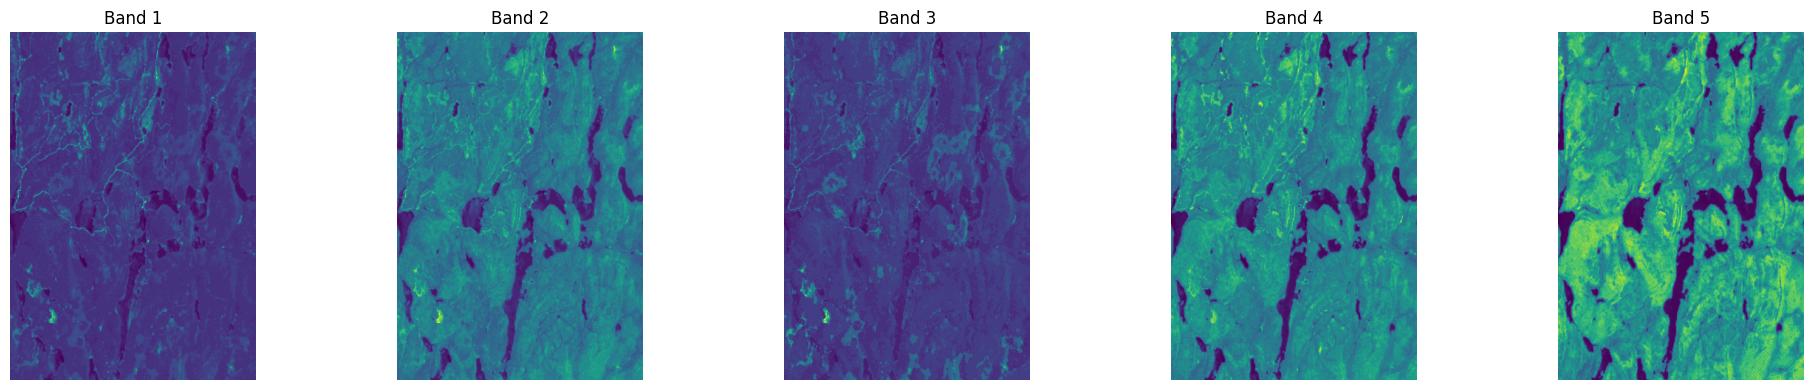

In [79]:
visualize_bands(training_dataset[3410][0][1], num_bands=5)

### Testing fusion cnn model

In [69]:
# config is a tuple, so use config[0] to access the dict
training_dataset.effective_shapes

[(34, 100, 100)]

In [110]:
# Initialize model with attention pooling and focal loss parameters
from fusion_cnn import SimpleMultiInputCNNv2, training_loop

if __name__ == "__main__":
    # Example configuration for testing
    input_shapes = training_dataset.effective_shapes  # Your actual input shapes

    # You would call it like this:
    # results = run_experiments(input_shapes, training_dataset, validation_dataset)
    
    # Or test individual configurations:
    config = {
            'name': 'Baseline (Max Pooling + Focal loss) + deeper',
            'use_attention': False,
            'use_focal_loss': True,
            'use_spatial_features': False,
            'use_deeper_cnn': True,
            'print_every': 1
        },
    
     # Create model with current configuration
    model = SimpleMultiInputCNNv2(input_shapes, config[0])
    
    # Train model
    trained_model, training_results = training_loop(
        model, training_dataset, validation_dataset, config[0]
    )

    metrics_row = {f"val_{k}": v for k, v in training_results['final_val_metrics'].items()}
    metrics_row.update({f"train_{k}": v for k, v in training_results['final_train_metrics'].items()})

    new_metrics_df = pd.DataFrame([metrics_row])
    new_metrics_df['scenario'] = "Baseline (Max Pooling + Focal loss) + spatial_features"
    metrics_df = pd.concat([metrics_df, new_metrics_df])


Using device: cpu
Model compiled successfully

Training Configuration:
  name: Baseline (Max Pooling + Focal loss) + deeper
  use_attention: False
  use_focal_loss: True
  use_spatial_features: False
  use_deeper_cnn: True
  print_every: 1

Starting training for 10 epochs...


Epoch [1/10]:
  Train - Accuracy: 0.7389, Loss: 0.3704, F1: 0.7560, AUC: 0.8622
  Val   - Accuracy: 0.8068, Loss: 0.2041, F1: 0.2857, AUC: 0.7482
  LR: 0.001000


Epoch [2/10]:
  Train - Accuracy: 0.7543, Loss: 0.2761, F1: 0.7698, AUC: 0.8856
  Val   - Accuracy: 0.6886, Loss: 0.2106, F1: 0.2633, AUC: 0.7598
  LR: 0.001000


Epoch [3/10]:
  Train - Accuracy: 0.7522, Loss: 0.2701, F1: 0.7693, AUC: 0.8904
  Val   - Accuracy: 0.5714, Loss: 0.2556, F1: 0.2352, AUC: 0.7738
  LR: 0.001000


Epoch [4/10]:
  Train - Accuracy: 0.7558, Loss: 0.2635, F1: 0.7728, AUC: 0.8956
  Val   - Accuracy: 0.7257, Loss: 0.2052, F1: 0.2664, AUC: 0.7659
  LR: 0.001000


Epoch [5/10]:
  Train - Accuracy: 0.7607, Loss: 0.2619, F1: 0.7758, AUC: 0.8961
  Val   - Accuracy: 0.8054, Loss: 0.1886, F1: 0.3310, AUC: 0.7936
  LR: 0.001000


Epoch [6/10]:
  Train - Accuracy: 0.7593, Loss: 0.2577, F1: 0.7754, AUC: 0.8996
  Val   - Accuracy: 0.7646, Loss: 0.2010, F1: 0.3174, AUC: 0.8028
  LR: 0.001000


Epoch [7/10]:
  Train - Accuracy: 0.7615, Loss: 0.2556, F1: 0.7767, AUC: 0.9015
  Val   - Accuracy: 0.6955, Loss: 0.2075, F1: 0.2908, AUC: 0.8066
  LR: 0.001000


Epoch [8/10]:
  Train - Accuracy: 0.7662, Loss: 0.2544, F1: 0.7805, AUC: 0.9025
  Val   - Accuracy: 0.8534, Loss: 0.1807, F1: 0.3708, AUC: 0.8080
  LR: 0.001000


Epoch [9/10]:
  Train - Accuracy: 0.7646, Loss: 0.2527, F1: 0.7792, AUC: 0.9035
  Val   - Accuracy: 0.6950, Loss: 0.2085, F1: 0.2947, AUC: 0.8111
  LR: 0.001000


Epoch [10/10]:
  Train - Accuracy: 0.7681, Loss: 0.2473, F1: 0.7823, AUC: 0.9072
  Val   - Accuracy: 0.7409, Loss: 0.1943, F1: 0.3108, AUC: 0.8152
  LR: 0.001000


In [111]:
metrics_df

val_accuracy    val_f1  val_precision  val_recall  val_roc_auc  val_loss  \
0      0.907909  0.345904       0.414330    0.296875     0.818050  0.431677   
0      0.810143  0.350657       0.243690    0.625000     0.823141  0.183728   
0      0.868912  0.329588       0.283871    0.392857     0.735788  0.501351   
0      0.838155  0.288245       0.225441    0.399554     0.738163  0.208598   
0      0.740937  0.310765       0.198754    0.712054     0.815235  0.194344   

   train_accuracy  train_f1  train_precision  train_recall  train_roc_auc  \
0        0.802335  0.804034         0.699928      0.944518       0.909964   
0        0.760145  0.776823         0.646780      0.972320       0.906610   
0        0.802698  0.800817         0.706704      0.923849       0.901221   
0        0.762896  0.776697         0.651953      0.960474       0.899207   
0        0.768085  0.782266         0.655240      0.970386       0.907172   

   train_loss                                           scenario  
0    0.570072                       Baseline (Max Pooling + BCE)  
0    0.251273                Baseline (Max Pooling + Focal loss)  
0    0.597333           Baseline (Max Pooling + BCE) + attention  
0    0.256692    Baseline (Max Pooling + Focal loss) + attention  
0    0.247274  Baseline (Max Pooling + Focal loss) + spatial_...

In [100]:
all_histories_species = pd.read_csv('all_histories_species.csv')

In [101]:
all_histories_species

split_index species  final_train_loss  final_val_loss  final_train_acc  \
0            0     LEG          0.342339        0.515682         0.852447   
1            0     LEG          0.346015        0.646312         0.848272   
2            0     LEG          0.337317        0.524541         0.850475   
3            0     LEG          0.387401        0.489380         0.839029   
4            1     SMR          0.415078        0.460632         0.760399   
5            1     SMR          0.437543        0.423678         0.743243   
6            1     SMR          0.421530        0.367589         0.756810   

   final_val_acc  best_val_acc  best_val_acc_epoch  epochs  split_ratio_diff  \
0       0.752012      0.804050                   4      10          0.000457   
1       0.698096      0.787420                   1       7          0.000457   
2       0.729882      0.785274                   7      10          0.000457   
3       0.783664      0.783664                   5       6          0.000457   
4       0.760764      0.849826                   1       9          0.000115   
5       0.804340      0.902257                   3       6          0.000115   
6       0.830208      0.919618                   7      10          0.000115   

   ...  false_positives  false_negatives   auc_roc    auc_pr        f1  \
0  ...           1751.0            794.0  0.926025  0.846171  0.806007   
1  ...           1915.0            702.0  0.924639  0.848782  0.804307   
2  ...           1940.0            639.0  0.928294  0.855895  0.808438   
3  ...           1949.0            830.0  0.906548  0.817520  0.791037   
4  ...           4365.0            174.0  0.880627  0.318024  0.356262   
5  ...           4676.0            188.0  0.867714  0.285902  0.338051   
6  ...           4440.0            167.0  0.876232  0.302203  0.353948   

   optimal_threshold  best_precision_with_threshold  \
0           0.413713                       0.659555   
1           0.316152                       0.657903   
2           0.505492                       0.663265   
3           0.384933                       0.647276   
4           0.642668                       0.313305   
5           0.277739                       0.244792   
6           0.306271                       0.311077   

   best_recall_with_threshold  best_f1_with_threshold  subset_ratio  
0                    0.823127                0.732318          0.10  
1                    0.809053                0.725691          0.25  
2                    0.791175                0.721596          0.50  
3                    0.799924                0.715550          0.75  
4                    0.502294                0.385903          0.10  
5                    0.538991                0.336676          0.25  
6                    0.470183                0.374429          0.50  

[7 rows x 25 columns]

In [ ]:
from fusion_cnn import training_loop


for scenario in scenarios:
    print(f"Training scenario: {scenario['name']}")
    model = SimpleMultiInputCNNv2(
        input_shapes=training_dataset.input_shapes,
        use_attention=scenario['use_attention'],
        num_classes=1  # Binary classification
    )
    
    training_loop(model, training_dataset, validation_dataset)


ModuleNotFoundError: No module named 'notebooks'

In [27]:
# Count 0 and 1 in the target column from the training dataset
import numpy as np

unique, counts = np.unique(training_targets, return_counts=True)
train_target_counts = dict(zip(unique, counts))
print("Training target counts:")
print(train_target_counts)
print(f"ratio: {train_target_counts[1] / train_target_counts[0]}")
# Count 0 and 1 in the target column from the validation dataset
unique_val, counts_val = np.unique(validation_targets, return_counts=True)
val_target_counts = dict(zip(unique_val, counts_val))
print("Validation target counts:")
print(val_target_counts)
print(f"ratio: {val_target_counts[1] / val_target_counts[0]}")

TypeError: '<' not supported between instances of 'Point' and 'str'

In [84]:
def plot_metrics(train_metrics, val_metrics, epochs):
    metrics = ['loss', 'accuracy', 'f1', 'precision', 'recall', 'roc_auc']
    titles = ['Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC-AUC']
    plt.figure(figsize=(15, 10))
    
    for i, (metric, title) in enumerate(zip(metrics, titles), 1):
        plt.subplot(2, 3, i)
        plt.plot(range(1, epochs + 1), train_metrics[metric], label='Train', color='#1f77b4')
        plt.plot(range(1, epochs + 1), val_metrics[metric], label='Validation', color='#ff7f0e')
        plt.title(f'{title} over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    #plt.savefig('training_metrics.png')
    plt.show()
    plt.close()

Epoch 1 summary => Train Loss: 0.5732, Train Acc: 0.8170, Train F1: 0.6103, Train Precision: 0.4910, Train Recall: 0.8061, Train ROC-AUC: 0.8891
                     Val Loss: 0.4542, Val Acc: 0.7851, Val F1: 0.6073, Val Precision: 0.4497, Val Recall: 0.9352, Val ROC-AUC: 0.9163
                     Learning Rate: 0.001000


Epoch 2 summary => Train Loss: 0.4259, Train Acc: 0.8397, Train F1: 0.6474, Train Precision: 0.5315, Train Recall: 0.8280, Train ROC-AUC: 0.9175
                     Val Loss: 0.4079, Val Acc: 0.8553, Val F1: 0.6676, Val Precision: 0.5639, Val Recall: 0.8180, Val ROC-AUC: 0.9257
                     Learning Rate: 0.001000


Epoch 3 summary => Train Loss: 0.4109, Train Acc: 0.8549, Train F1: 0.6724, Train Precision: 0.5616, Train Recall: 0.8376, Train ROC-AUC: 0.9253
                     Val Loss: 0.4244, Val Acc: 0.8601, Val F1: 0.6720, Val Precision: 0.5760, Val Recall: 0.8066, Val ROC-AUC: 0.9264
                     Learning Rate: 0.001000


Epoch 4 summary => Train Loss: 0.4000, Train Acc: 0.8568, Train F1: 0.6754, Train Precision: 0.5656, Train Recall: 0.8382, Train ROC-AUC: 0.9286
                     Val Loss: 0.4049, Val Acc: 0.8688, Val F1: 0.6792, Val Precision: 0.6005, Val Recall: 0.7816, Val ROC-AUC: 0.9300
                     Learning Rate: 0.001000


Epoch 5 summary => Train Loss: 0.3951, Train Acc: 0.8596, Train F1: 0.6809, Train Precision: 0.5712, Train Recall: 0.8428, Train ROC-AUC: 0.9299
                     Val Loss: 0.5529, Val Acc: 0.8731, Val F1: 0.6175, Val Precision: 0.6645, Val Recall: 0.5768, Val ROC-AUC: 0.9168
                     Learning Rate: 0.001000


Epoch 6 summary => Train Loss: 0.3844, Train Acc: 0.8602, Train F1: 0.6835, Train Precision: 0.5720, Train Recall: 0.8490, Train ROC-AUC: 0.9335
                     Val Loss: 0.3878, Val Acc: 0.8474, Val F1: 0.6821, Val Precision: 0.5414, Val Recall: 0.9215, Val ROC-AUC: 0.9348
                     Learning Rate: 0.001000


Epoch 7 summary => Train Loss: 0.3788, Train Acc: 0.8653, Train F1: 0.6919, Train Precision: 0.5828, Train Recall: 0.8513, Train ROC-AUC: 0.9360
                     Val Loss: 0.4522, Val Acc: 0.8033, Val F1: 0.6282, Val Precision: 0.4730, Val Recall: 0.9352, Val ROC-AUC: 0.9260
                     Learning Rate: 0.001000


Epoch 8 summary => Train Loss: 0.3702, Train Acc: 0.8682, Train F1: 0.6984, Train Precision: 0.5886, Train Recall: 0.8587, Train ROC-AUC: 0.9384
                     Val Loss: 0.5763, Val Acc: 0.8617, Val F1: 0.5128, Val Precision: 0.6857, Val Recall: 0.4096, Val ROC-AUC: 0.9065
                     Learning Rate: 0.001000


Epoch 9 summary => Train Loss: 0.3700, Train Acc: 0.8703, Train F1: 0.7020, Train Precision: 0.5932, Train Recall: 0.8595, Train ROC-AUC: 0.9394
                     Val Loss: 0.4426, Val Acc: 0.8342, Val F1: 0.6555, Val Precision: 0.5197, Val Recall: 0.8874, Val ROC-AUC: 0.9236
                     Learning Rate: 0.001000


Epoch 10 summary => Train Loss: 0.3723, Train Acc: 0.8674, Train F1: 0.6950, Train Precision: 0.5878, Train Recall: 0.8499, Train ROC-AUC: 0.9388
                     Val Loss: 0.3843, Val Acc: 0.8446, Val F1: 0.6754, Val Precision: 0.5369, Val Recall: 0.9101, Val ROC-AUC: 0.9361
                     Learning Rate: 0.001000


Epoch 11 summary => Train Loss: 0.3602, Train Acc: 0.8727, Train F1: 0.7055, Train Precision: 0.5991, Train Recall: 0.8578, Train ROC-AUC: 0.9426
                     Val Loss: 0.4230, Val Acc: 0.8215, Val F1: 0.6544, Val Precision: 0.4988, Val Recall: 0.9511, Val ROC-AUC: 0.9371
                     Learning Rate: 0.001000


Epoch 12 summary => Train Loss: 0.3588, Train Acc: 0.8779, Train F1: 0.7134, Train Precision: 0.6122, Train Recall: 0.8547, Train ROC-AUC: 0.9441
                     Val Loss: 0.3710, Val Acc: 0.8684, Val F1: 0.6990, Val Precision: 0.5888, Val Recall: 0.8601, Val ROC-AUC: 0.9384
                     Learning Rate: 0.001000


Epoch 13 summary => Train Loss: 0.3513, Train Acc: 0.8791, Train F1: 0.7189, Train Precision: 0.6127, Train Recall: 0.8698, Train ROC-AUC: 0.9457
                     Val Loss: 0.4364, Val Acc: 0.8712, Val F1: 0.6823, Val Precision: 0.6075, Val Recall: 0.7782, Val ROC-AUC: 0.9311
                     Learning Rate: 0.001000


Epoch 14 summary => Train Loss: 0.3486, Train Acc: 0.8812, Train F1: 0.7237, Train Precision: 0.6170, Train Recall: 0.8752, Train ROC-AUC: 0.9466
                     Val Loss: 0.3877, Val Acc: 0.8836, Val F1: 0.6900, Val Precision: 0.6547, Val Recall: 0.7292, Val ROC-AUC: 0.9380
                     Learning Rate: 0.001000


Epoch 15 summary => Train Loss: 0.3439, Train Acc: 0.8820, Train F1: 0.7242, Train Precision: 0.6196, Train Recall: 0.8712, Train ROC-AUC: 0.9482
                     Val Loss: 0.3862, Val Acc: 0.8803, Val F1: 0.6936, Val Precision: 0.6363, Val Recall: 0.7622, Val ROC-AUC: 0.9363
                     Learning Rate: 0.001000


Epoch 16 summary => Train Loss: 0.3440, Train Acc: 0.8805, Train F1: 0.7221, Train Precision: 0.6155, Train Recall: 0.8735, Train ROC-AUC: 0.9479
                     Val Loss: 0.4114, Val Acc: 0.8801, Val F1: 0.6800, Val Precision: 0.6468, Val Recall: 0.7167, Val ROC-AUC: 0.9332
                     Learning Rate: 0.001000


Epoch 17 summary => Train Loss: 0.3397, Train Acc: 0.8839, Train F1: 0.7276, Train Precision: 0.6239, Train Recall: 0.8726, Train ROC-AUC: 0.9491
                     Val Loss: 0.3849, Val Acc: 0.8807, Val F1: 0.7041, Val Precision: 0.6296, Val Recall: 0.7986, Val ROC-AUC: 0.9370
                     Learning Rate: 0.000500


Epoch 18 summary => Train Loss: 0.3181, Train Acc: 0.8870, Train F1: 0.7348, Train Precision: 0.6303, Train Recall: 0.8809, Train ROC-AUC: 0.9552
                     Val Loss: 0.3667, Val Acc: 0.8743, Val F1: 0.7058, Val Precision: 0.6040, Val Recall: 0.8487, Val ROC-AUC: 0.9424
                     Learning Rate: 0.000500


Epoch 19 summary => Train Loss: 0.3170, Train Acc: 0.8906, Train F1: 0.7426, Train Precision: 0.6381, Train Recall: 0.8880, Train ROC-AUC: 0.9560
                     Val Loss: 0.3738, Val Acc: 0.8848, Val F1: 0.7130, Val Precision: 0.6396, Val Recall: 0.8055, Val ROC-AUC: 0.9414
                     Learning Rate: 0.000500


Epoch 20 summary => Train Loss: 0.3064, Train Acc: 0.8976, Train F1: 0.7561, Train Precision: 0.6557, Train Recall: 0.8928, Train ROC-AUC: 0.9593
                     Val Loss: 0.3805, Val Acc: 0.8868, Val F1: 0.7104, Val Precision: 0.6512, Val Recall: 0.7816, Val ROC-AUC: 0.9406
                     Learning Rate: 0.000500


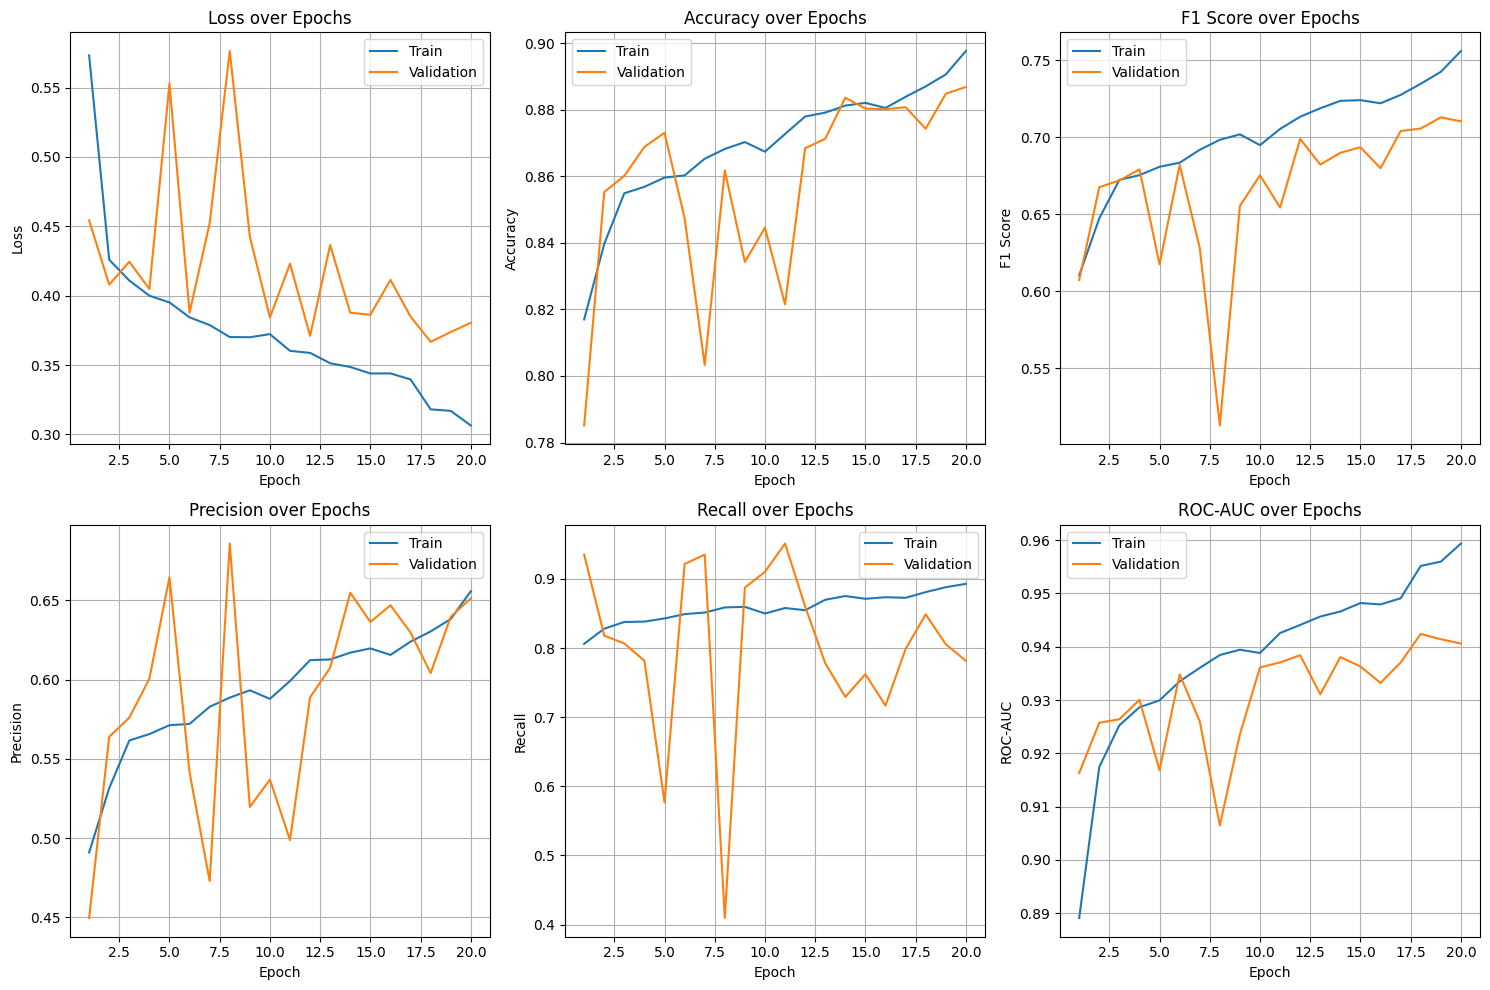

Training completed. Metrics plot saved as 'training_metrics.png'.


In [36]:


# -----------------------------
# PLOTTING FUNCTION
# -----------------------------
def plot_metrics(train_metrics, val_metrics, epochs):
    metrics = ['loss', 'accuracy', 'f1', 'precision', 'recall', 'roc_auc']
    titles = ['Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC-AUC']
    plt.figure(figsize=(15, 10))
    
    for i, (metric, title) in enumerate(zip(metrics, titles), 1):
        plt.subplot(2, 3, i)
        plt.plot(range(1, epochs + 1), train_metrics[metric], label='Train', color='#1f77b4')
        plt.plot(range(1, epochs + 1), val_metrics[metric], label='Validation', color='#ff7f0e')
        plt.title(f'{title} over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    #plt.savefig('training_metrics.png')
    plt.show()
    plt.close()

# -----------------------------
# TRAINING LOOP
# -----------------------------
for epoch in range(epochs):
    # Training Phase
    compiled_model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_targets = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    
    for batch in pbar:
        inputs = [x.to(device).float() for x in batch[:-1]]
        targets = batch[-1].to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = compiled_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * targets.size(0)
        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        all_train_preds.extend(preds)
        all_train_targets.extend(targets.cpu().numpy())

        # Compute batch metrics for progress bar
        batch_preds_binary = [1 if p > 0.5 else 0 for p in preds]
        batch_acc = accuracy_score(targets.cpu().numpy(), batch_preds_binary)
        batch_f1 = f1_score(targets.cpu().numpy(), batch_preds_binary, zero_division=0)
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{batch_acc:.4f}",
            "F1": f"{batch_f1:.4f}"
        })

    # Compute epoch-level training metrics
    train_loss /= len(train_loader.dataset)
    train_preds_binary = [1 if p > 0.5 else 0 for p in all_train_preds]
    train_acc = accuracy_score(all_train_targets, train_preds_binary)
    train_f1 = f1_score(all_train_targets, train_preds_binary, zero_division=0)
    train_precision = precision_score(all_train_targets, train_preds_binary, zero_division=0)
    train_recall = recall_score(all_train_targets, train_preds_binary, zero_division=0)
    train_roc_auc = roc_auc_score(all_train_targets, all_train_preds) if len(np.unique(all_train_targets)) > 1 else 0.0

    # Store training metrics
    train_metrics['loss'].append(train_loss)
    train_metrics['accuracy'].append(train_acc)
    train_metrics['f1'].append(train_f1)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['roc_auc'].append(train_roc_auc)

    # Validation Phase
    compiled_model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        for batch in pbar:
            inputs = [x.to(device).float() for x in batch[:-1]]
            targets = batch[-1].to(device).float().unsqueeze(1)
            outputs = compiled_model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * targets.size(0)
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            all_val_preds.extend(preds)
            all_val_targets.extend(targets.cpu().numpy())

            # Compute batch metrics for progress bar
            batch_preds_binary = [1 if p > 0.5 else 0 for p in preds]
            batch_acc = accuracy_score(targets.cpu().numpy(), batch_preds_binary)
            batch_f1 = f1_score(targets.cpu().numpy(), batch_preds_binary, zero_division=0)
            pbar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Acc": f"{batch_acc:.4f}",
                "F1": f"{batch_f1:.4f}"
            })

    # Compute epoch-level validation metrics
    val_loss /= len(val_loader.dataset)
    val_preds_binary = [1 if p > 0.5 else 0 for p in all_val_preds]
    val_acc = accuracy_score(all_val_targets, val_preds_binary)
    val_f1 = f1_score(all_val_targets, val_preds_binary, zero_division=0)
    val_precision = precision_score(all_val_targets, val_preds_binary, zero_division=0)
    val_recall = recall_score(all_val_targets, val_preds_binary, zero_division=0)
    val_roc_auc = roc_auc_score(all_val_targets, all_val_preds) if len(np.unique(all_val_targets)) > 1 else 0.0

    # Store validation metrics
    val_metrics['loss'].append(val_loss)
    val_metrics['accuracy'].append(val_acc)
    val_metrics['f1'].append(val_f1)
    val_metrics['precision'].append(val_precision)
    val_metrics['recall'].append(val_recall)
    val_metrics['roc_auc'].append(val_roc_auc)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Print epoch summary
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} summary => "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
          f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train ROC-AUC: {train_roc_auc:.4f}")
    print(f"                     Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, "
          f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")
    print(f"                     Learning Rate: {current_lr:.6f}")

# -----------------------------
# PLOT AND SAVE METRICS
# -----------------------------
plot_metrics(train_metrics, val_metrics, epochs)
print("Training completed. Metrics plot saved as 'training_metrics.png'.")

In [37]:
print("Final Training Metrics:")
print(train_metrics)
print("Final Validation Metrics:")
print(val_metrics)


Final Training Metrics:
{'loss': [0.5731673308325018, 0.42592808805935184, 0.4109165803919786, 0.3999656777219818, 0.3951338667594817, 0.38435654404611036, 0.37883258855550733, 0.37018876085385005, 0.3700369088960652, 0.3722807083206403, 0.3602304068032256, 0.35876825511801985, 0.3513111696720485, 0.3485892752053191, 0.34393005033680546, 0.3439706526141231, 0.339662300639602, 0.3180736492069978, 0.31697894389472103, 0.3064407942962068], 'accuracy': [0.8169825625473843, 0.8396765226181451, 0.8548900682335102, 0.8568107151882739, 0.8595905989385898, 0.8602476623704827, 0.8652514531210513, 0.8681829668941117, 0.8702552438716199, 0.8673742734394744, 0.872681324235532, 0.8779378316906747, 0.8791003285317159, 0.881223148850139, 0.8820318423047764, 0.8805155420773313, 0.8838514025777103, 0.8869850897144301, 0.8905736669193833, 0.8975991913065453], 'f1': [0.6102680012915724, 0.6473988439306358, 0.672372475179733, 0.6754496505899874, 0.6809097174362508, 0.6835298157262218, 0.691934365611278, 0.

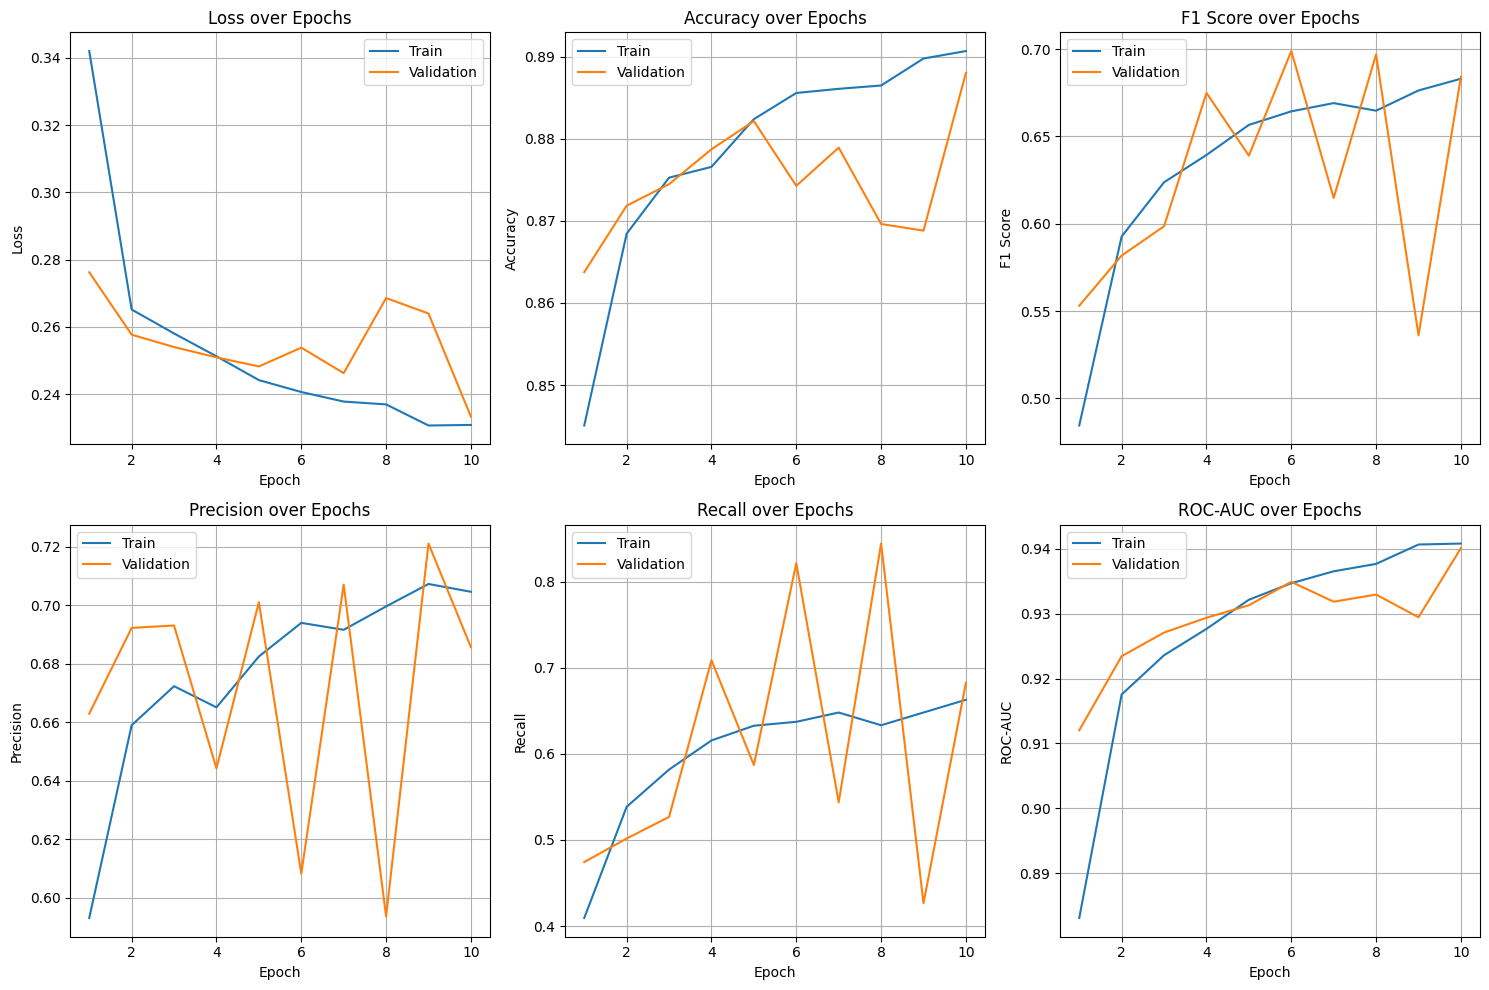

In [85]:
plot_metrics(train_metrics, val_metrics, epochs)

### Compressing the npy dataset

In [ ]:
import numpy as np
import os
from tqdm import tqdm

def compress_large_npy(input_path: str, output_path: str, chunk_size: int = 1000):
    """
    Compresses a large .npy file into a .npz file by processing it in chunks.

    This function uses memory mapping to avoid loading the entire file into memory.

    Parameters
    ----------
    input_path : str
        The path to the large, uncompressed .npy file.
    output_path : str
        The path to save the compressed .npz file.
    chunk_size : int, optional
        The number of items (e.g., patches) to process in each chunk.
        Adjust based on available RAM. Defaults to 1000.
    """
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file not found: {input_path}")
    
    # Get metadata from the original file without loading it
    try:
        source_memmap = np.memmap(input_path, mode='r')
        original_shape = source_memmap.shape
        original_dtype = source_memmap.dtype
        del source_memmap # Release the memory map
    except Exception as e:
        raise IOError(f"Failed to read metadata from {input_path}: {e}")
    
    # Check if the file is empty or not an array
    if len(original_shape) == 0:
        print("Warning: Input file is empty or has a shape of (0,). Skipping compression.")
        return

    total_items = original_shape[0]
    num_chunks = (total_items + chunk_size - 1) // chunk_size

    print(f"Compressing file: {input_path}")
    print(f"Original shape: {original_shape}, dtype: {original_dtype}")
    print(f"Processing in {num_chunks} chunks of size {chunk_size}...")

    # Open the original file in memory-map mode for reading
    source_memmap = np.memmap(input_path, dtype=original_dtype, mode='r', shape=original_shape)
    
    # Use a temporary dictionary to hold the chunks
    chunks_to_save = {}
    
    for i in tqdm(range(num_chunks), desc="Compressing chunks"):
        start_idx = i * chunk_size
        end_idx = min(start_idx + chunk_size, total_items)
        
        # Read a chunk from the memory-mapped file
        chunk = source_memmap[start_idx:end_idx]
        
        # Add the chunk to the dictionary with a unique name
        chunks_to_save[f'chunk_{i}'] = chunk

    # Save all chunks to a single compressed .npz file
    np.savez_compressed(output_path, **chunks_to_save)
    
    # Clean up the memory-mapped file
    del source_memmap
    
    print(f"\nCompression complete. Saved to: {output_path}")
    
    # Verify file sizes
    original_size = os.path.getsize(input_path)
    compressed_size = os.path.getsize(output_path)
    print(f"Original size: {original_size / (1024**3):.2f} GB")
    print(f"Compressed size: {compressed_size / (1024**3):.2f} GB")
    print(f"Compression ratio: {original_size / compressed_size:.2f}x")

# Example Usage:
if __name__ == '__main__':
    # Create a dummy large file for demonstration
    # dummy_data = np.random.rand(50000, 3, 256, 256).astype(np.float32)
    # np.save("large_dummy_file.npy", dummy_data)

    input_file = "../data/npy_data/sentinel2_patches.npy"
    output_file = "../data/npy_data/compressed_sentinel2_patches.npz"

    compress_large_npy(input_file, output_file)

Compressing file: ../data/npy_data/sentinel2_patches.npy
Original shape: (34911369684,), dtype: uint8
Processing in 34911370 chunks of size 1000...


Compressing chunks: 100%|██████████| 34911370/34911370 [02:08<00:00, 272032.99it/s]


In [4]:

import gzip
import os
from tqdm import tqdm
def compress_to_npy_gzip(input_path: str, output_path: str, chunk_size: int = 1000):
    """
    Compress a large .npy file using gzip while maintaining the ability to 
    memory-map the decompressed file.
    
    This creates a .npy.gz file that must be decompressed before memory mapping.
    """
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file not found: {input_path}")
    
    print(f"Compressing {input_path} with gzip...")
    # Get file size for progress bar
    file_size = os.path.getsize(input_path)
    chunk_size_bytes = 1024 * 1024  # 1MB

    with open(input_path, 'rb') as f_in, gzip.open(output_path, 'wb') as f_out:
        with tqdm(total=file_size, unit='B', unit_scale=True, desc="Compressing") as pbar:
            while True:
                chunk = f_in.read(chunk_size_bytes)
                if not chunk:
                    break
                f_out.write(chunk)
                pbar.update(len(chunk))
    
    print(f"Compression complete. Saved to: {output_path}")
    
    # Verify file sizes
    original_size = os.path.getsize(input_path)
    compressed_size = os.path.getsize(output_path)
    print(f"Original size: {original_size / (1024**3):.2f} GB")
    print(f"Compressed size: {compressed_size / (1024**3):.2f} GB")
    print(f"Compression ratio: {original_size / compressed_size:.2f}x")
compress_to_npy_gzip("../data/npy_data/sentinel2_patches.npy", "../data/npy_data/sentinel2_patches.npy.gz")

Compressing ../data/npy_data/sentinel2_patches.npy with gzip...


Compressing:   0%|          | 0.00/34.9G [00:00<?, ?B/s]

Compressing: 100%|██████████| 34.9G/34.9G [1:55:19<00:00, 5.05MB/s]  

Compression complete. Saved to: ../data/npy_data/sentinel2_patches.npy.gz
Original size: 32.51 GB
Compressed size: 15.44 GB
Compression ratio: 2.11x


### Val training split

In [69]:
from splitting import preprocess_data_for_split_generation
# --- Step 1: Define your grid configuration and target species ---
my_grid_configuration = {
    'grid_rows': 6, # Example: Can be different from geometry creation default
    'grid_cols': 6
}

gdf_with_patches, all_patch_ids = preprocess_data_for_split_generation(
    processed_species_df= processed_species_original_locations,
    grid_config=my_grid_configuration,
)




Grid layout with sequential patch numbers:
+-----------------------+
| 30| 31| 32| 33| 34| 35|
+-----------------------+
| 24| 25| 26| 27| 28| 29|
+-----------------------+
| 18| 19| 20| 21| 22| 23|
+-----------------------+
| 12| 13| 14| 15| 16| 17|
+-----------------------+
|  6|  7|  8|  9| 10| 11|
+-----------------------+
|  0|  1|  2|  3|  4|  5|
+-----------------------+

Total patches: 6 columns x 6 rows = 36 patches
Patches are numbered sequentially from 0 to 35


In [66]:
from splitting import get_train_val_indices
train_indices, val_indices, patches_gdf = get_train_val_indices(
    processed_species_original_locations, 
    my_grid_configuration, 
    validation_patch_numbers=[0, 6, 7, 1, 2, 8])

Grid layout with sequential patch numbers:
+-----------------------+
| 30| 31| 32| 33| 34| 35|
+-----------------------+
| 24| 25| 26| 27| 28| 29|
+-----------------------+
| 18| 19| 20| 21| 22| 23|
+-----------------------+
| 12| 13| 14| 15| 16| 17|
+-----------------------+
|V 6|V 7|V 8|  9| 10| 11|
+-----------------------+
|V 0|V 1|V 2|  3|  4|  5|
+-----------------------+

Validation patches: [0, 6, 7, 1, 2, 8]
Train samples: 18203, Validation samples: 6529
Train/validation ratio: 0.35867714113058285


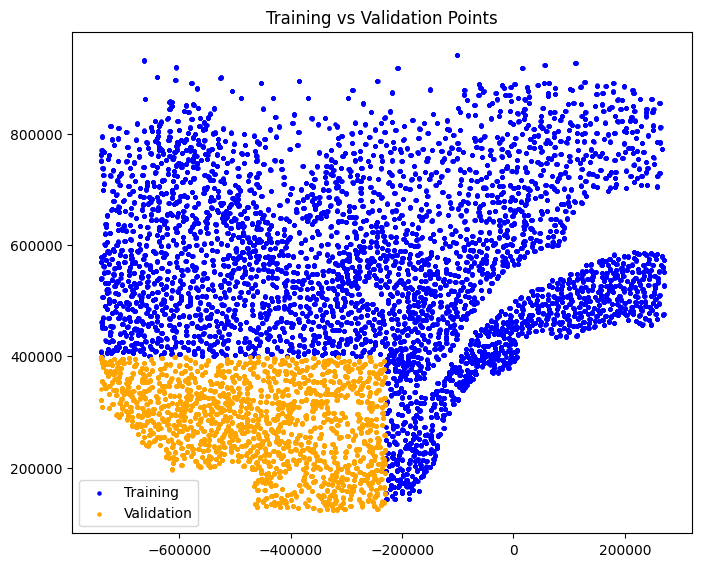

In [67]:
from splitting import plot_split
plot_split(train_indices, val_indices, processed_species_original_locations)

### Boosting tree benchmark

In [57]:
from model_evaluation import evaluate_xgb_for_species

target_species_arr = ['ERP', 'SAB','RUI', 'SOA']

my_grid_configuration = {
    'grid_rows': 6, # Example: Can be different from geometry creation default
    'grid_cols': 6
}

params = {
    'objective': 'binary:logistic',  # for binary classification
    'booster': 'gbtree',
    'eval_metric': ['logloss', 'auc'], # Monitor both during training
    'max_depth': 6,                   # Your good initial guess - controls complexity
    'eta': 0.1,                       # The learning rate - VERY important
    'subsample': 0.8,                 # Randomly sample 80% of data for each tree (prevents overfitting)
    'colsample_bytree': 0.8,          # Randomly sample 80% of features for each tree (prevents overfitting)
    'min_child_weight': 1,            # A smaller value lets the model fit more specific samples
    'tree_method': 'hist',            # Faster training ("hist" for histogram-based)
    'seed': 42                        # For reproducibility
}

splits = [
    [0, 6, 7, 1, 2, 8],
    [30, 31, 32, 24, 25, 26, 18, 19, 20],
    [34, 35, 28, 29, 22, 23],
    [15, 16, 17, 9, 10, 11, 3, 4, 5],
    [13, 14, 15, 7, 8, 9, 1, 2, 3],
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    [0, 1, 6, 7, 12, 13, 18, 19, 24, 25, 30, 31]
]

results_df = evaluate_xgb_for_species(
    target_species_arr=target_species_arr,
    splits=splits,
    grid_config=my_grid_configuration,
    model=model,
    processed_species=processed_species_original_locations,
    model_params = params
)


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/xgboost/callback.py:264: UserWarning: [16:02:19] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  score: str = model.eval_set(evals, epoch, self.metric, self._output_margin)
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/metrics/_cl

In [ ]:
# Compute mean and std for each species for each metric
metrics = ['val_accuracy', 'train_accuracy', 'val_f1', 'val_roc_auc', 'val_recall']
agg_stats = results_df.groupby('species')[metrics].agg(['mean', 'std'])
print(agg_stats)

        val_accuracy           train_accuracy              val_f1            \
                mean       std           mean       std      mean       std   
species                                                                       
ERP         0.842732  0.116578       0.935849  0.032775  0.562807  0.258986   
RUI         0.628749  0.160800       0.795467  0.021698  0.437288  0.165428   
SAB         0.805585  0.128539       0.874596  0.025367  0.826514  0.212715   
SOA         0.638612  0.070239       0.830584  0.022657  0.524060  0.085529   

        val_roc_auc           val_recall            
               mean       std       mean       std  
species                                             
ERP        0.874949  0.074353   0.620181  0.295627  
RUI        0.650682  0.092835   0.562294  0.275875  
SAB        0.748167  0.058592   0.816836  0.285270  
SOA        0.711866  0.049470   0.644894  0.186422  


In [63]:
# Compute mean and std for each species for each metric
metrics = ['val_accuracy', 'train_accuracy', 'val_f1', 'val_roc_auc', 'val_recall']
agg_stats = results_df.groupby('split')[metrics].agg(['mean', 'std'])
print(agg_stats)

                                             val_accuracy            \
                                                     mean       std   
split                                                                 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]           0.659705  0.170935   
[0, 1, 6, 7, 12, 13, 18, 19, 24, 25, 30, 31]     0.744430  0.088194   
[0, 6, 7, 1, 2, 8]                               0.673227  0.155228   
[13, 14, 15, 7, 8, 9, 1, 2, 3]                   0.708007  0.153570   
[15, 16, 17, 9, 10, 11, 3, 4, 5]                 0.723865  0.179965   
[30, 31, 32, 24, 25, 26, 18, 19, 20]             0.782923  0.183154   
[34, 35, 28, 29, 22, 23]                         0.810281  0.182763   

                                             train_accuracy            \
                                                       mean       std   
split                                                                   
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]             0.872899  0.070324 